# **Mortgage Prediction Model Project- 3**  
-  **Loan - HPI - Unemployment Datasets**  

  In this notebook,I added the House Price Index dataset and the Unemployment dataset to improve the model that I used in Project 2, the Fanimie Single Loan dataset. By inserting extra datas, I aimed to increase the accuracy of our predictions and enhance the model's explainability.

This notebook was prepared by <a href="https://www.linkedin.com/in/betul-ozkaldi-0580a8273/">Betul Ozkaldi</a>

# Libraries

In [3]:
!pip install xgboost --user

In [2]:
! pip install scikit-learn --user

In [1]:
import xgboost as xgb
xgb.__version__

'1.7.0'

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from matplotlib import gridspec
import gc
#import imp
import os
import joblib
from random import sample
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

In [2]:
from copy import deepcopy
from itertools import product
from collections import defaultdict

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,RandomizedSearchCV,train_test_split,KFold
from sklearn.metrics import make_scorer,roc_auc_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder,PowerTransformer, MinMaxScaler

In [4]:
seed = 0

# Data

In [9]:
csv_path = 'C:/Users/btloz/JupyterNotes/Group_Project/group_project_part_2/Clean_data_1.csv'
hpa_path = 'C:/Users/btloz/JupyterNotes/Group_Project/economic_project/home_price_m.csv'

In [10]:
df_raw = pd.read_csv(csv_path, sep=',', dtype={'zip':'str'})
df_raw.head()

loan_id  act_period channel  orig_rate  orig_upb  orig_term  \
0  265674961865  2018-02-28       R      4.125  183000.0      360.0   
1  747888204871  2020-07-28       R      4.625  108000.0      360.0   
2  939243187741  2021-06-28       C      3.375  417000.0      360.0   
3  492457754312  2012-12-28       C      2.750  393000.0      180.0   
4      99982734  2021-11-28       R      3.250   86000.0      360.0   

    orig_date   first_pay  loan_age  rem_months  ... target  last_period  \
0  2017-01-20  2017-03-20      12.0       348.0  ...      A          NaN   
1  2013-09-20  2013-11-20      81.0       279.0  ...      A          NaN   
2  2016-08-20  2016-10-20      57.0       303.0  ...      D   2021-06-20   
3  2012-08-20  2012-10-20       3.0       177.0  ...      A          NaN   
4  2020-05-20  2020-07-20      17.0       343.0  ...      A          NaN   

   calc_age  age_dif  calc_rem_months  cscore_min       orig_val Vintage  \
0        14      2.0              348       767.0  435714.285714    2017   
1        83      2.0              279       763.0  158823.529412    2013   
2        59      2.0              303       755.0  834000.000000    2016   
3         5      2.0              177       802.0  714545.454545    2012   
4        19      2.0              343       701.0   90526.315789    2020   

  Prepay Default  
0      0       0  
1      0       0  
2      0       1  
3      0       0  
4      0       0  

[5 rows x 43 columns]

In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        557576 non-null  int64  
 1   act_period                     557576 non-null  object 
 2   channel                        557576 non-null  object 
 3   orig_rate                      557576 non-null  float64
 4   orig_upb                       557576 non-null  float64
 5   orig_term                      557576 non-null  float64
 6   orig_date                      557576 non-null  object 
 7   first_pay                      557576 non-null  object 
 8   loan_age                       557576 non-null  float64
 9   rem_months                     557576 non-null  float64
 10  matr_dt                        379617 non-null  object 
 11  oltv                           557576 non-null  float64
 12  ocltv                         

In [12]:
df_raw['cscore_min'].head()

0    767.0
1    763.0
2    755.0
3    802.0
4    701.0
Name: cscore_min, dtype: float64

In [13]:
df_raw.shape

(557576, 43)

In [14]:
df_raw['target'].value_counts()

target
A    228695
P    170874
D    158007
Name: count, dtype: int64

In [15]:
# Check if zip column has lenght 3
df_raw['zip'].str.len().value_counts(dropna= False)

zip
3    557576
Name: count, dtype: int64

In [16]:
#just to make sure if we need to pad
df_raw['zip']=df_raw['zip'].str.pad(width=3, side='left', fillchar='0')

**Fraction**

In [17]:
df= df_raw.sample(frac= 0.5)

In [18]:
df.shape

(278788, 43)

In [19]:
df['target'].value_counts()

target
A    114272
P     85598
D     78918
Name: count, dtype: int64

In [20]:
df.columns

Index(['loan_id', 'act_period', 'channel', 'orig_rate', 'orig_upb',
       'orig_term', 'orig_date', 'first_pay', 'loan_age', 'rem_months',
       'matr_dt', 'oltv', 'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c',
       'first_flag', 'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'msa',
       'zip', 'mi_pct', 'dlq_status', 'zero_bal_code', 'zb_dte', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'target', 'last_period', 'calc_age',
       'age_dif', 'calc_rem_months', 'cscore_min', 'orig_val', 'Vintage',
       'Prepay', 'Default'],
      dtype='object')

In [21]:
# lets convert the date variables just incase we them for future calculations,
#so far we only need it for orig_date for merging with HPA and unemployment

parse_dates= ['orig_date', 'first_pay', 'zb_dte', 'act_period', 'matr_dt']
for i in parse_dates:
    df[i]= pd.to_datetime(df[i])

In [22]:
# drop prepays

index_names = df[(df['target'] == 'P')].index
df.drop(index_names, inplace =True)

In [23]:
df['Default'].value_counts()

Default
0    114272
1     78918
Name: count, dtype: int64

In [24]:
list(df)

['loan_id',
 'act_period',
 'channel',
 'orig_rate',
 'orig_upb',
 'orig_term',
 'orig_date',
 'first_pay',
 'loan_age',
 'rem_months',
 'matr_dt',
 'oltv',
 'ocltv',
 'num_bo',
 'dti',
 'cscore_b',
 'cscore_c',
 'first_flag',
 'purpose',
 'prop',
 'no_units',
 'occ_stat',
 'state',
 'msa',
 'zip',
 'mi_pct',
 'dlq_status',
 'zero_bal_code',
 'zb_dte',
 'mi_type',
 'homeready_program_indicator',
 'relocation_mortgage_indicator',
 'high_balance_loan_indicator',
 'target',
 'last_period',
 'calc_age',
 'age_dif',
 'calc_rem_months',
 'cscore_min',
 'orig_val',
 'Vintage',
 'Prepay',
 'Default']

- Let's convert the date variables just in case we them for future calculations. So far we only need it for orig_date for merging with HPA and unemployment in a same format ie 'M082009'

In [25]:
df['orig_mnth']= 'M'+df['orig_date'].dt.month.map('{:02}'.format).astype(str)+df['orig_date'].dt.year.astype(str)
df.head()

loan_id act_period channel  orig_rate  orig_upb  orig_term  \
494497  656546097939 2009-11-28       B      7.375  232000.0      360.0   
401825  437091671407 2001-11-28       B      7.875  157000.0      360.0   
277579  229734449168 2013-04-28       C      6.375  125000.0      180.0   
415063  289217096658 2021-10-28       R      4.250  174000.0      360.0   
116653  509538265690 2006-01-28       B      5.875  150000.0      360.0   

        orig_date  first_pay  loan_age  rem_months  ... last_period  calc_age  \
494497 2008-05-20 2008-07-20      17.0       343.0  ...  2009-11-20        19   
401825 2000-09-20 2000-11-20      13.0       347.0  ...         NaN        15   
277579 2001-05-20 2001-07-20     142.0        38.0  ...         NaN       144   
415063 2014-10-20 2014-12-20      83.0       277.0  ...         NaN        85   
116653 2003-11-20 2004-01-20      25.0       335.0  ...         NaN        27   

        age_dif  calc_rem_months  cscore_min       orig_val  Vintage Prepay  \
494497      2.0              343       698.0  252173.913043     2008      0   
401825      2.0              347       663.0  174444.444444     2000      0   
277579      2.0               38       755.0  192307.692308     2001      0   
415063      2.0              277       740.0  183157.894737     2014      0   
116653      2.0              335       632.0  230769.230769     2003      0   

       Default orig_mnth  
494497       1   M052008  
401825       0   M092000  
277579       0   M052001  
415063       0   M102014  
116653       0   M112003  

[5 rows x 44 columns]

In [26]:
earliest_orig= df['orig_date'].min() #to avoid merging or performance issues

In [27]:
earliest_orig

Timestamp('1999-01-19 00:00:00')

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
- Data on local economic conditions, house prices, and employment- unemployment rates in specific regions are crucial indicator for assessing default risk in mortgages.  
- Economic data helps lenders assess the risk of borrowers defaulting on their mortgage loans.  

That is why, I decided to implement the House Prices Indexes and Unemployment Datasets to my Mortgage Loan Dataset. Let's start to import the datasets.  

****------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------****

**ROAD MAP**

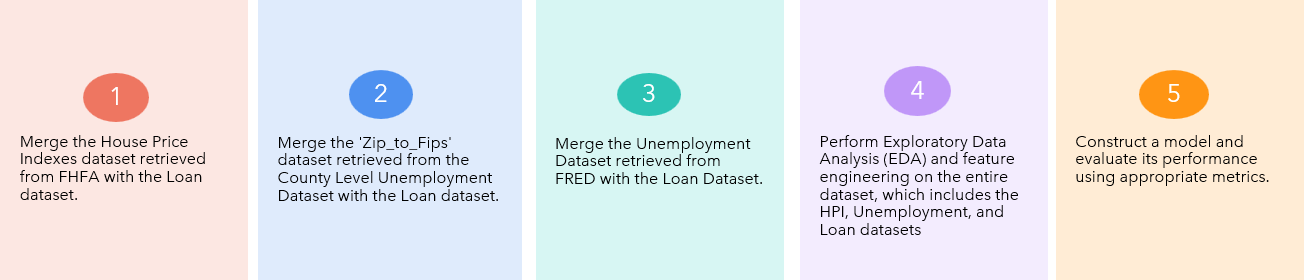

In [11]:
Image('roadmap3.png')

# HPI Dataset    

**House Prices Indexes**

- Home prices are crucial when it comes to predicting mortgage defaults. They help us understand how the housing market is doing and whether people are likely to have trouble paying their mortgages.

- If home prices are going up, it means the housing market is strong, and there's less risk of defaults.  
But if home prices are going down, it's a warning sign – the housing market is weak, and the risk of people not being able to pay their mortgages goes up.

- Home prices also tell us how much properties are worth and how much homeowners actually own. This helps us figure out the risk of people defaulting on their mortgages, both for individual homeowners and for the entire mortgage market.  

I pulled the HPI dataset from The Federal Housing Finance  Agency (FHFA).  
FHA is a government agency that provides mortgage insuarance for loans. Fannie Mae is a government sponsored enterprise and supports FHA- insured mortgages. And also FHA provides an index for FHA-insured mortgages. I selected quarterly data based on three-Digit ZIP Codes (Devolepmental Index: Not Seasonally Adjusted)
  

https://fred.stlouisfed.org/  
https://www.fhfa.gov/

**Read HPA**

In [28]:
hpa= pd.read_csv(hpa_path, dtype= {'zip': 'str'})
hpa.head()

Unnamed: 0        Date zip    Year   Quarter  Index (NSA)  \
0           0  1995-03-31  10  1995.0  1.000000       100.00   
1           1  1995-04-30  10  1995.0  1.333333       100.46   
2           2  1995-05-31  10  1995.0  1.666667       100.92   
3           3  1995-06-30  10  1995.0  2.000000       101.38   
4           4  1995-07-31  10  1995.0  2.333333       102.13   

                 Index Type orig_qrtr orig_qrtr_date  12M Change  36M Change  \
0  Native 3-Digit ZIP index    Q11995         1995Q1      0.0496      0.0793   
1  Native 3-Digit ZIP index    Q21995         1995Q2      0.0496      0.0793   
2  Native 3-Digit ZIP index    Q21995         1995Q2      0.0496      0.0793   
3  Native 3-Digit ZIP index    Q21995         1995Q2      0.0496      0.0793   
4  Native 3-Digit ZIP index    Q31995         1995Q3      0.0496      0.0793   

   60M Change  
0      0.1721  
1      0.1721  
2      0.1721  
3      0.1721  
4      0.1721

In [29]:
hpa['zip'] =hpa['zip'].str.pad(width =3, side ='left', fillchar ='0')

In [30]:
periods_to_drop =hpa[pd.to_datetime(hpa['Date'])< earliest_orig].index
hpa.drop(periods_to_drop, inplace= True)

In [31]:
### check if zip column has length 3
hpa['zip'].str.len().value_counts(dropna=False)

zip
3    259308
Name: count, dtype: int64

In [32]:
hpa.head()

Unnamed: 0        Date  zip         Year   Quarter  Index (NSA)  \
46          46  1999-01-31  010  1998.333333  3.000000   110.563333   
47          47  1999-02-28  010  1998.666667  2.000000   110.696667   
48          48  1999-03-31  010  1999.000000  1.000000   110.830000   
49          49  1999-04-30  010  1999.000000  1.333333   111.163333   
50          50  1999-05-31  010  1999.000000  1.666667   111.496667   

                  Index Type orig_qrtr orig_qrtr_date  12M Change  36M Change  \
46  Native 3-Digit ZIP index    Q11999         1999Q1    0.033206    0.062156   
47  Native 3-Digit ZIP index    Q11999         1999Q1    0.030024    0.059028   
48  Native 3-Digit ZIP index    Q11999         1999Q1    0.026869    0.055926   
49  Native 3-Digit ZIP index    Q21999         1999Q2    0.027736    0.063934   
50  Native 3-Digit ZIP index    Q21999         1999Q2    0.028599    0.072015   

    60M Change  
46      0.1721  
47      0.1721  
48      0.1721  
49      0.1721  
50      0.1721

**Creating orig_mnth column**

In [33]:
hpa['Date'].dtype

dtype('O')

In [34]:
# create the orig_mnth variable to use for merging with loan dataset
hpa['Date']= pd.to_datetime(hpa['Date'])
hpa['orig_mnth'] = 'M'+hpa['Date'].dt.month.map('{:02}'.format).astype(str)+hpa['Date'].dt.year.astype(str)

In [35]:
hpa.dtypes

Unnamed: 0                 int64
Date              datetime64[ns]
zip                       object
Year                     float64
Quarter                  float64
Index (NSA)              float64
Index Type                object
orig_qrtr                 object
orig_qrtr_date            object
12M Change               float64
36M Change               float64
60M Change               float64
orig_mnth                 object
dtype: object

In [36]:
df.dtypes

loan_id                                   int64
act_period                       datetime64[ns]
channel                                  object
orig_rate                               float64
orig_upb                                float64
orig_term                               float64
orig_date                        datetime64[ns]
first_pay                        datetime64[ns]
loan_age                                float64
rem_months                              float64
matr_dt                          datetime64[ns]
oltv                                    float64
ocltv                                   float64
num_bo                                  float64
dti                                     float64
cscore_b                                float64
cscore_c                                float64
first_flag                               object
purpose                                  object
prop                                     object
no_units                                

## Merge Loan and HPA  Datasets
- Merge loan table with hpa table by zip and origination month.
- Note that we only pull the columns that we are interested from the HPA data

In [37]:
df = pd.merge(df, hpa[['zip', '12M Change', '36M Change', '60M Change','orig_mnth']], on = ['zip', 'orig_mnth'], how ='left', indicator= True)

In [38]:
df.shape

(193190, 48)

In [39]:
df.columns

Index(['loan_id', 'act_period', 'channel', 'orig_rate', 'orig_upb',
       'orig_term', 'orig_date', 'first_pay', 'loan_age', 'rem_months',
       'matr_dt', 'oltv', 'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c',
       'first_flag', 'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'msa',
       'zip', 'mi_pct', 'dlq_status', 'zero_bal_code', 'zb_dte', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'target', 'last_period', 'calc_age',
       'age_dif', 'calc_rem_months', 'cscore_min', 'orig_val', 'Vintage',
       'Prepay', 'Default', 'orig_mnth', '12M Change', '36M Change',
       '60M Change', '_merge'],
      dtype='object')

In [40]:
df['_merge'].value_counts() #it looks we have bunch of zips in loan dataset that we can not find in HPA dataset(left_only)

_merge
both          191921
left_only       1269
right_only         0
Name: count, dtype: int64

In [41]:
### check the loan data zips that I can not find a match for
df[['zip','orig_date','orig_mnth']][df['_merge']=='left_only']

zip  orig_date orig_mnth
44      009 2012-11-20   M112012
264     007 2012-08-20   M082012
345     009 2004-02-20   M022004
426     345 2006-11-20   M112006
575     007 2000-06-20   M062000
...     ...        ...       ...
191940  009 2018-11-20   M112018
192334  009 2006-07-20   M072006
192620  006 2012-04-20   M042012
192847  007 2012-09-20   M092012
192953  006 2013-09-20   M092013

[1269 rows x 3 columns]

In [42]:
### I have this code for diagnosis in case I have problems with the merge
#hpa[(hpa['zip']=='009') &(hpa['Year']==2008)].head(200)
# we may need to go back and check our original xls file if that zipcode exists, for now we will impute
hpa[(hpa['zip']=='009') ].head(200)

Empty DataFrame
Columns: [Unnamed: 0, Date, zip, Year, Quarter, Index (NSA), Index Type, orig_qrtr, orig_qrtr_date, 12M Change, 36M Change, 60M Change, orig_mnth]
Index: []

In [43]:
## just another way to check unmatched zips
df[['zip']][df['_merge']=='left_only'].value_counts()

zip
009    518
007    365
006    277
008     82
969     11
000      5
102      4
345      2
965      2
702      1
929      1
962      1
Name: count, dtype: int64

In [44]:
# yet another way to check unmatched zips

df_zip=df.loc[df['_merge']=='left_only']
df_zip[['zip','loan_id']].groupby('zip').count()

loan_id
zip         
000        5
006      277
007      365
008       82
009      518
102        4
345        2
702        1
929        1
962        1
965        2
969       11

In [45]:
df.drop(['_merge'], axis= 1, inplace =True)

# County Level Unemployment Dataset

Now we will add County Level unemployment here  
- First we will add FIPS from zip3 to fips lookup table to data table.  
- Then create orig_month for both unemployment file and the data file.
- Merge by Fips and origination month.
- I downloaded the zip_to_fip dataset from The U.S. Department of Housing and Urban Development (HUD) also provides data on housing and economic conditions.  

https://www.huduser.gov/portal/datasets/usps_crosswalk.html    
And I did some operations then I saved it in unemployment_count file.  

In [46]:
zip3_fips_lookup= "C:/Users/btloz/JupyterNotes/Group_Project/economic_project/zip3_fips_lookup.pkl"

In [47]:
zip_to_fips= pd.read_pickle(zip3_fips_lookup)

In [48]:
zip_to_fips.rename(columns={'ZIP_3':'zip'}, inplace=True)
zip_to_fips['zip']=zip_to_fips['zip'].str.pad(width=3, side='left', fillchar='0')
zip_to_fips['FIPS']=zip_to_fips['FIPS'].str.pad(width=5, side='left', fillchar='0')

In [49]:
zip_to_fips.head()

zip                                       Zipcode   Latitude  Longitude  \
0  005                                         501.0  40.810000 -73.040000   
1  006                                           inf  18.296436 -66.797327   
2  007                                           inf  18.177714 -66.074476   
3  008  891120344535556570601648150762133338980352.0  18.141111 -64.855556   
4  009                                           inf  18.394000 -66.094696   

    FIPS  
0  36103  
1  72141  
2  72025  
3  0None  
4  72127

In [50]:
zip_to_fips.drop(['Zipcode'],axis= 1, inplace =True)

In [51]:
zip_to_fips.shape, zip_to_fips.dtypes

((911, 4),
 zip           object
 Latitude     float64
 Longitude    float64
 FIPS          object
 dtype: object)

In [52]:
list(zip_to_fips), zip_to_fips.shape, zip_to_fips.head().dtypes

(['zip', 'Latitude', 'Longitude', 'FIPS'],
 (911, 4),
 zip           object
 Latitude     float64
 Longitude    float64
 FIPS          object
 dtype: object)

## Merge Zip_to_Fip to Loan Dataset

In [53]:
df= pd.merge(df, zip_to_fips[['zip', 'FIPS']], on =['zip'], how ='left', indicator =True)

In [54]:
df.head()

loan_id act_period channel  orig_rate  orig_upb  orig_term  orig_date  \
0  656546097939 2009-11-28       B      7.375  232000.0      360.0 2008-05-20   
1  437091671407 2001-11-28       B      7.875  157000.0      360.0 2000-09-20   
2  229734449168 2013-04-28       C      6.375  125000.0      180.0 2001-05-20   
3  289217096658 2021-10-28       R      4.250  174000.0      360.0 2014-10-20   
4  509538265690 2006-01-28       B      5.875  150000.0      360.0 2003-11-20   

   first_pay  loan_age  rem_months  ...       orig_val  Vintage  Prepay  \
0 2008-07-20      17.0       343.0  ...  252173.913043     2008       0   
1 2000-11-20      13.0       347.0  ...  174444.444444     2000       0   
2 2001-07-20     142.0        38.0  ...  192307.692308     2001       0   
3 2014-12-20      83.0       277.0  ...  183157.894737     2014       0   
4 2004-01-20      25.0       335.0  ...  230769.230769     2003       0   

   Default  orig_mnth  12M Change  36M Change 60M Change   FIPS _merge  
0        1    M052008   -0.013360    0.084945   0.195388  13121   both  
1        0    M092000    0.112830    0.251518   0.336043  12103   both  
2        0    M052001    0.049956    0.103744   0.190175  28089   both  
3        0    M102014    0.032621    0.049384   0.036373  31055   both  
4        0    M112003    0.056074    0.192601   0.455671  53033   both  

[5 rows x 49 columns]

In [55]:
df['_merge'].value_counts()

_merge
both          193178
left_only         12
right_only         0
Name: count, dtype: int64

In [56]:
df.drop(['_merge'], axis =1, inplace= True)

In [57]:
df.shape

(193190, 48)

In [58]:
df.columns

Index(['loan_id', 'act_period', 'channel', 'orig_rate', 'orig_upb',
       'orig_term', 'orig_date', 'first_pay', 'loan_age', 'rem_months',
       'matr_dt', 'oltv', 'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c',
       'first_flag', 'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'msa',
       'zip', 'mi_pct', 'dlq_status', 'zero_bal_code', 'zb_dte', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'target', 'last_period', 'calc_age',
       'age_dif', 'calc_rem_months', 'cscore_min', 'orig_val', 'Vintage',
       'Prepay', 'Default', 'orig_mnth', '12M Change', '36M Change',
       '60M Change', 'FIPS'],
      dtype='object')

# Unemployment Dataset    

The unemployment rate is important in understanding mortgage defaults.  
- When unemployment is high, it means people might struggle to make their mortgage payments.  
- When unemployment is low, it's a sign that people have steady jobs and are more likely to make their payments on time.  

The unemployment rate can also tell us about the future economy, which affects mortgage defaults."  

I pulled the data from The Federal Reserve Economic Data (FRED) is an extensive online database and economic research tool mainted by the Federal Reserved Bank of St. Louis.
It provides access to a wide range of economic datat, statistics and time series from various sources, including government agencies, central banks and international organizations.

https://www.hud.gov/program_offices/housing/hsgrroom/loanperformance



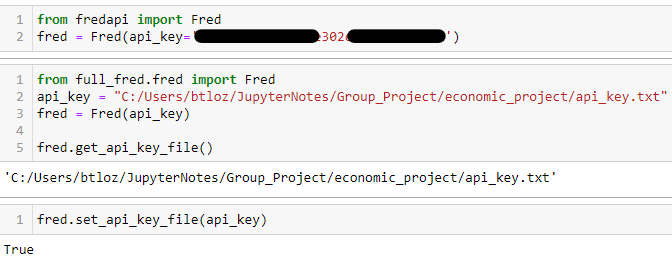

In [9]:
Image('apikeyunemployment.png')

- With this Api_key, I created the url_base then with finction I pulled the data 1000 by 1000.

**Read Unemployment Datasets**

In [59]:
unemp_county_shrt= "C:/Users/btloz/JupyterNotes/Group_Project/economic_project/unemp_county_shrt.pkl"

In [60]:
df_unemp = pd.read_pickle(unemp_county_shrt)
# Now, proceed with the following line to pad the 'FIPS' column
df_unemp['FIPS'] = df_unemp['FIPS'].str.pad(width=5, side='left', fillchar='0')

In [61]:
df_unemp.dtypes

realtime_start      object
realtime_end        object
date                object
value               object
id                  object
County              object
State               object
fips               float64
name                object
FIPS                object
_merge            category
dtype: object

- we created County column from 'name' column and FIPS from 'fips' column,  I forgot to drop them at unemployment dataset  and saved it now i will drop them 

In [62]:
df_unemp.drop(['fips'], axis =1, inplace= True)

In [63]:
df_unemp.drop(['name'], axis =1, inplace= True)

In [64]:
df_unemp.dtypes

realtime_start      object
realtime_end        object
date                object
value               object
id                  object
County              object
State               object
FIPS                object
_merge            category
dtype: object

In [65]:
## check if value columns is string
(df_unemp[df_unemp['value'].apply(lambda x: isinstance(x, str))])

realtime_start realtime_end        date  value          id  \
0           2023-09-13   2023-09-13  1990-01-01  0.700  AKALEU0URN   
1           2023-09-13   2023-09-13  1990-02-01  0.600  AKALEU0URN   
2           2023-09-13   2023-09-13  1990-03-01    0.7  AKALEU0URN   
3           2023-09-13   2023-09-13  1990-04-01  0.700  AKALEU0URN   
4           2023-09-13   2023-09-13  1990-05-01    0.7  AKALEU0URN   
...                ...          ...         ...    ...         ...   
1251686     2023-09-13   2023-09-13  2023-03-01    2.7  WYWEST5URN   
1251687     2023-09-13   2023-09-13  2023-04-01    2.2  WYWEST5URN   
1251688     2023-09-13   2023-09-13  2023-05-01    1.9  WYWEST5URN   
1251689     2023-09-13   2023-09-13  2023-06-01    2.2  WYWEST5URN   
1251690     2023-09-13   2023-09-13  2023-07-01    2.1  WYWEST5URN   

                             County State   FIPS _merge  
0        Aleutians West Census Area    AK  02016   both  
1        Aleutians West Census Area    AK  02016   both  
2        Aleutians West Census Area    AK  02016   both  
3        Aleutians West Census Area    AK  02016   both  
4        Aleutians West Census Area    AK  02016   both  
...                             ...   ...    ...    ...  
1251686                      Weston    WY  56045   both  
1251687                      Weston    WY  56045   both  
1251688                      Weston    WY  56045   both  
1251689                      Weston    WY  56045   both  
1251690                      Weston    WY  56045   both  

[1251691 rows x 9 columns]

In [66]:
#try to see why value column is read as str
print( df_unemp['value'][pd.to_numeric(df_unemp['value'], errors ='coerce').isnull()].value_counts())

value
.    118
Name: count, dtype: int64


- Looks like the original file has non zero dots that forces value column to be string , change dots to Nans

In [68]:
df_unemp.replace('.',np.NaN, inplace =True)

In [69]:
# backfill them
df_unemp['value'] = df_unemp.groupby(['FIPS'])['value'].bfill()

In [70]:
# check does it work?
print(df_unemp['value'][pd.to_numeric(df_unemp['value'], errors= 'coerce').isnull()].value_counts())

Series([], Name: count, dtype: int64)


In [71]:
df_unemp.dtypes

realtime_start      object
realtime_end        object
date                object
value               object
id                  object
County              object
State               object
FIPS                object
_merge            category
dtype: object

In [72]:
df_unemp['value'] = df_unemp['value'].astype(float)

In [73]:
df_unemp.dtypes

realtime_start      object
realtime_end        object
date                object
value              float64
id                  object
County              object
State               object
FIPS                object
_merge            category
dtype: object

In [75]:
list(df_unemp)

['realtime_start',
 'realtime_end',
 'date',
 'value',
 'id',
 'County',
 'State',
 'FIPS',
 '_merge']

In [76]:
df_unemp['date'] = pd.to_datetime(df_unemp['date'])

In [77]:
df_unemp['orig_mnth'] ='M'+df_unemp['date'].dt.month.map('{:02}'.format).astype(str)+df_unemp['date'].dt.year.astype(str)
df_unemp.head()

realtime_start realtime_end       date  value          id  \
0     2023-09-13   2023-09-13 1990-01-01    0.7  AKALEU0URN   
1     2023-09-13   2023-09-13 1990-02-01    0.6  AKALEU0URN   
2     2023-09-13   2023-09-13 1990-03-01    0.7  AKALEU0URN   
3     2023-09-13   2023-09-13 1990-04-01    0.7  AKALEU0URN   
4     2023-09-13   2023-09-13 1990-05-01    0.7  AKALEU0URN   

                       County State   FIPS _merge orig_mnth  
0  Aleutians West Census Area    AK  02016   both   M011990  
1  Aleutians West Census Area    AK  02016   both   M021990  
2  Aleutians West Census Area    AK  02016   both   M031990  
3  Aleutians West Census Area    AK  02016   both   M041990  
4  Aleutians West Census Area    AK  02016   both   M051990

In [78]:
df_unemp.groupby(['FIPS'])['orig_mnth'].min().value_counts()

orig_mnth
M011990    3048
M011994       1
Name: count, dtype: int64

In [79]:
df_unemp.FIPS =df_unemp.FIPS.astype(str)

In [80]:
df_unemp.drop(['_merge'], axis =1, inplace= True)

## Merge Unemployment and Loan Datasets

In [81]:
df = pd.merge(df, df_unemp[['orig_mnth', 'value', 'FIPS']], on = ['orig_mnth', 'FIPS'], how ='left', indicator= True)

In [82]:
df.shape

(193190, 50)

In [83]:
df.columns

Index(['loan_id', 'act_period', 'channel', 'orig_rate', 'orig_upb',
       'orig_term', 'orig_date', 'first_pay', 'loan_age', 'rem_months',
       'matr_dt', 'oltv', 'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c',
       'first_flag', 'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'msa',
       'zip', 'mi_pct', 'dlq_status', 'zero_bal_code', 'zb_dte', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'target', 'last_period', 'calc_age',
       'age_dif', 'calc_rem_months', 'cscore_min', 'orig_val', 'Vintage',
       'Prepay', 'Default', 'orig_mnth', '12M Change', '36M Change',
       '60M Change', 'FIPS', 'value', '_merge'],
      dtype='object')

In [84]:
df['_merge'].value_counts()

_merge
both          185384
left_only       7806
right_only         0
Name: count, dtype: int64

In [85]:
df[['orig_mnth', 'FIPS','zip','value']].loc[df['_merge']=='left_only']

orig_mnth   FIPS  zip  value
20       M092008  0None  114    NaN
44       M112012  72127  009    NaN
49       M012009  0None  967    NaN
58       M032009  0None  114    NaN
84       M022014  24510  212    NaN
...          ...    ...  ...    ...
192993   M042002  08031  802    NaN
193028   M092009  0None  967    NaN
193039   M122008  0None  114    NaN
193086   M052021  15003  968    NaN
193101   M082020  42101  191    NaN

[7806 rows x 4 columns]

In [86]:
df_unemp[ df_unemp['FIPS']=='72141']

Empty DataFrame
Columns: [realtime_start, realtime_end, date, value, id, County, State, FIPS, orig_mnth]
Index: []

In [87]:
df.rename(columns = {'value':'unemp'}, inplace =True)

In [88]:
list(df)

['loan_id',
 'act_period',
 'channel',
 'orig_rate',
 'orig_upb',
 'orig_term',
 'orig_date',
 'first_pay',
 'loan_age',
 'rem_months',
 'matr_dt',
 'oltv',
 'ocltv',
 'num_bo',
 'dti',
 'cscore_b',
 'cscore_c',
 'first_flag',
 'purpose',
 'prop',
 'no_units',
 'occ_stat',
 'state',
 'msa',
 'zip',
 'mi_pct',
 'dlq_status',
 'zero_bal_code',
 'zb_dte',
 'mi_type',
 'homeready_program_indicator',
 'relocation_mortgage_indicator',
 'high_balance_loan_indicator',
 'target',
 'last_period',
 'calc_age',
 'age_dif',
 'calc_rem_months',
 'cscore_min',
 'orig_val',
 'Vintage',
 'Prepay',
 'Default',
 'orig_mnth',
 '12M Change',
 '36M Change',
 '60M Change',
 'FIPS',
 'unemp',
 '_merge']

In [89]:
df.dtypes

loan_id                                   int64
act_period                       datetime64[ns]
channel                                  object
orig_rate                               float64
orig_upb                                float64
orig_term                               float64
orig_date                        datetime64[ns]
first_pay                        datetime64[ns]
loan_age                                float64
rem_months                              float64
matr_dt                          datetime64[ns]
oltv                                    float64
ocltv                                   float64
num_bo                                  float64
dti                                     float64
cscore_b                                float64
cscore_c                                float64
first_flag                               object
purpose                                  object
prop                                     object
no_units                                

# Save the Data

In [90]:
full_data = 'loan_hpi_unemp.csv'
df.to_csv(full_data, index=False)

In [91]:
df= pd.read_csv(full_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        193190 non-null  int64  
 1   act_period                     193190 non-null  object 
 2   channel                        193190 non-null  object 
 3   orig_rate                      193190 non-null  float64
 4   orig_upb                       193190 non-null  float64
 5   orig_term                      193190 non-null  float64
 6   orig_date                      193190 non-null  object 
 7   first_pay                      193190 non-null  object 
 8   loan_age                       193190 non-null  float64
 9   rem_months                     193190 non-null  float64
 10  matr_dt                        189602 non-null  object 
 11  oltv                           193190 non-null  float64
 12  ocltv                         

## Transformation

In [92]:
df['homeready_program_indicator'].value_counts()

homeready_program_indicator
N    191318
Y      1872
Name: count, dtype: int64

- _homeready_program_indicator_ created some problem. When I checked before 2014 there is no data for this column in train set. If we check the disrtibution of labels in test set and see big differences between Yes and No, we would say: this column is impactful for our model.For this case, we can do On-Top-Adjustment. I mean, we may need to create a new model for test set for only homeready_program_indicator. In my case dropping the column is okay.

In [93]:
df.columns

Index(['loan_id', 'act_period', 'channel', 'orig_rate', 'orig_upb',
       'orig_term', 'orig_date', 'first_pay', 'loan_age', 'rem_months',
       'matr_dt', 'oltv', 'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c',
       'first_flag', 'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'msa',
       'zip', 'mi_pct', 'dlq_status', 'zero_bal_code', 'zb_dte', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'target', 'last_period', 'calc_age',
       'age_dif', 'calc_rem_months', 'cscore_min', 'orig_val', 'Vintage',
       'Prepay', 'Default', 'orig_mnth', '12M Change', '36M Change',
       '60M Change', 'FIPS', 'unemp', '_merge'],
      dtype='object')

Drop the columns that we will not use as model features by following the reasons below for
your decision making:  
- _Data columns that contain **future information**:_ 
       'rem_months', 'calc_rem_months'
  
- _Data columns that contain **information about the target**:_  
      'act_period','dlq_status', 'zero_bal_code','zb_dte','target','act_period'
- _Data columns that contain **date/loan identifier**:_  
       'orig_date', 'matr_dt', 'last_period','first_pay'
- _Data columns that will **create high cardinality**:_  
      'zip'  
- _Data column related to the **property used as collateral for the mortgage loan**:_  
      'msa'
- Homeready_program_indicator was **creating singularity** in logistic regression.  

In [94]:
cols_to_drop = ['loan_id','first_pay','act_period','orig_date','matr_dt','msa','zip','zero_bal_code','zb_dte','last_period',
            'calc_age','age_dif','calc_rem_months' ,'Prepay','target','dlq_status','_merge','state',
              'FIPS','orig_mnth','_merge','homeready_program_indicator','rem_months']

In [95]:
df_models =df.drop(columns = cols_to_drop, axis= 1)

In [96]:
df_models.columns

Index(['channel', 'orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv',
       'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c', 'first_flag',
       'purpose', 'prop', 'no_units', 'occ_stat', 'mi_pct', 'mi_type',
       'relocation_mortgage_indicator', 'high_balance_loan_indicator',
       'cscore_min', 'orig_val', 'Vintage', 'Default', '12M Change',
       '36M Change', '60M Change', 'unemp'],
      dtype='object')

In [97]:
df_models.to_csv('df_models.csv')

In [98]:
df_models = pd.read_csv('df_models.csv')

In [99]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     193190 non-null  int64  
 1   channel                        193190 non-null  object 
 2   orig_rate                      193190 non-null  float64
 3   orig_upb                       193190 non-null  float64
 4   orig_term                      193190 non-null  float64
 5   loan_age                       193190 non-null  float64
 6   oltv                           193190 non-null  float64
 7   ocltv                          193190 non-null  float64
 8   num_bo                         193190 non-null  float64
 9   dti                            193190 non-null  float64
 10  cscore_b                       193190 non-null  float64
 11  cscore_c                       193190 non-null  float64
 12  first_flag                    

### Imputation  
-  interpolate method

In [100]:
df_models = df_models.sort_values(by='Vintage')

# Interpolate the missing values in the specified columns
columns_to_interpolate = ['12M Change', '36M Change', '60M Change', 'unemp']
df_models[columns_to_interpolate] = df_models[columns_to_interpolate].interpolate(method='linear')
# Reset the index if needed
df.reset_index(drop=True, inplace=True)

In [101]:
df_models.isnull().sum()

Unnamed: 0                       0
channel                          0
orig_rate                        0
orig_upb                         0
orig_term                        0
loan_age                         0
oltv                             0
ocltv                            0
num_bo                           0
dti                              0
cscore_b                         0
cscore_c                         0
first_flag                       0
purpose                          0
prop                             0
no_units                         0
occ_stat                         0
mi_pct                           0
mi_type                          0
relocation_mortgage_indicator    0
high_balance_loan_indicator      0
cscore_min                       0
orig_val                         0
Vintage                          0
Default                          0
12M Change                       0
36M Change                       0
60M Change                       0
unemp               

In [102]:
df_models['unemp'] = pd.to_numeric(df_models['unemp'],errors='coerce')

### Indicator  
- Let's create a **Bad Vintage Indicator** for economic analysis to account for the impact of economic recessions during specific time periods, which occurred in the USA in 2006, 2007, and 2008.  

Check the 'Vintage' value in each row. If the 'Vintage' value is in the list [2006, 2007, 2008], it assigns the value 1; otherwise, it assigns 0

In [103]:
df_models['bad_vintage']=df_models.apply(lambda x: 1 if x.Vintage in [2006,2007,2008] else 0,axis=1)

In [104]:
df_models[['bad_vintage','Default']].value_counts()

bad_vintage  Default
0            0          103969
             1           49541
1            1           29377
             0           10303
Name: count, dtype: int64

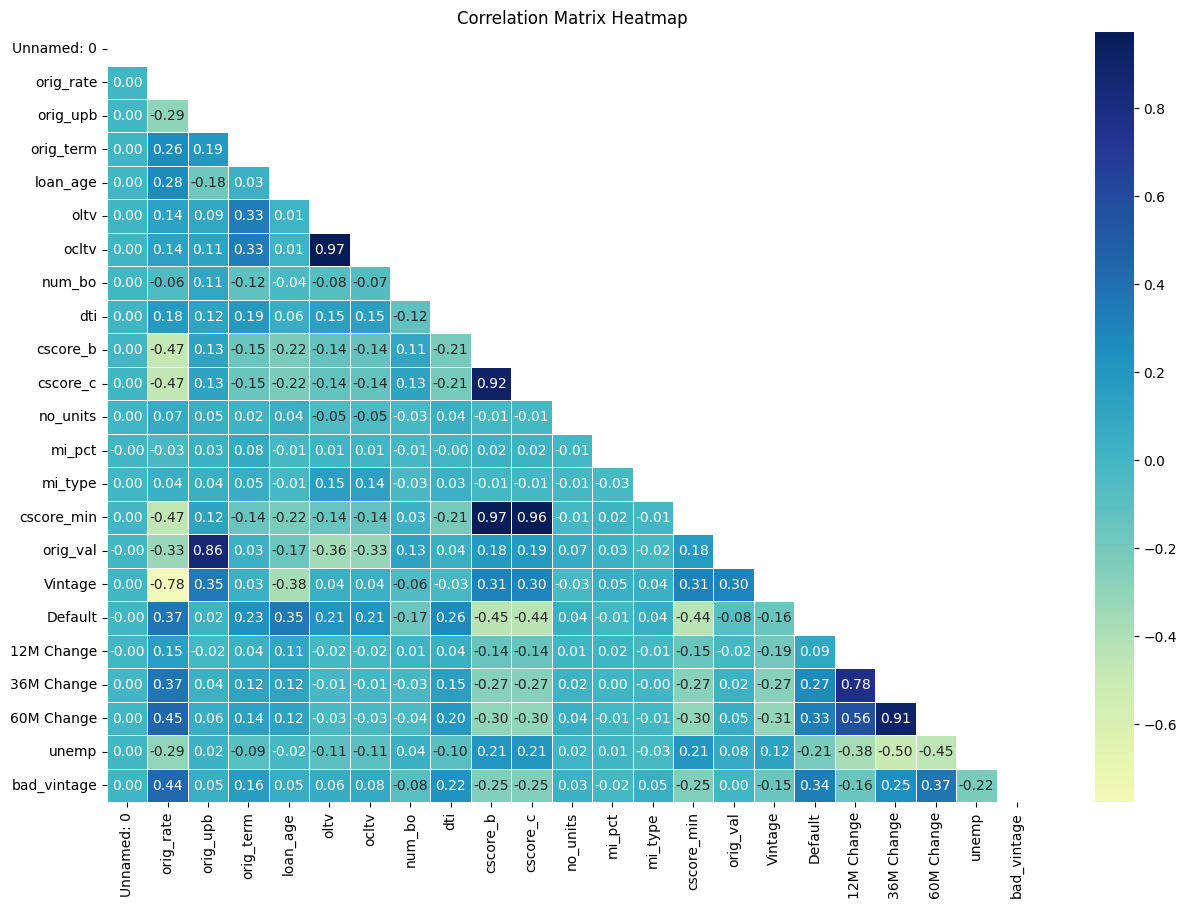

In [105]:
# Create a DataFrame with only numeric columns
numeric_df = df_models.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()
matrix = np.triu(corr_matrix)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt='.2f', cmap='YlGnBu', center=0, mask=matrix,annot_kws={"size": 10})

plt.title('Correlation Matrix Heatmap')
plt.show()


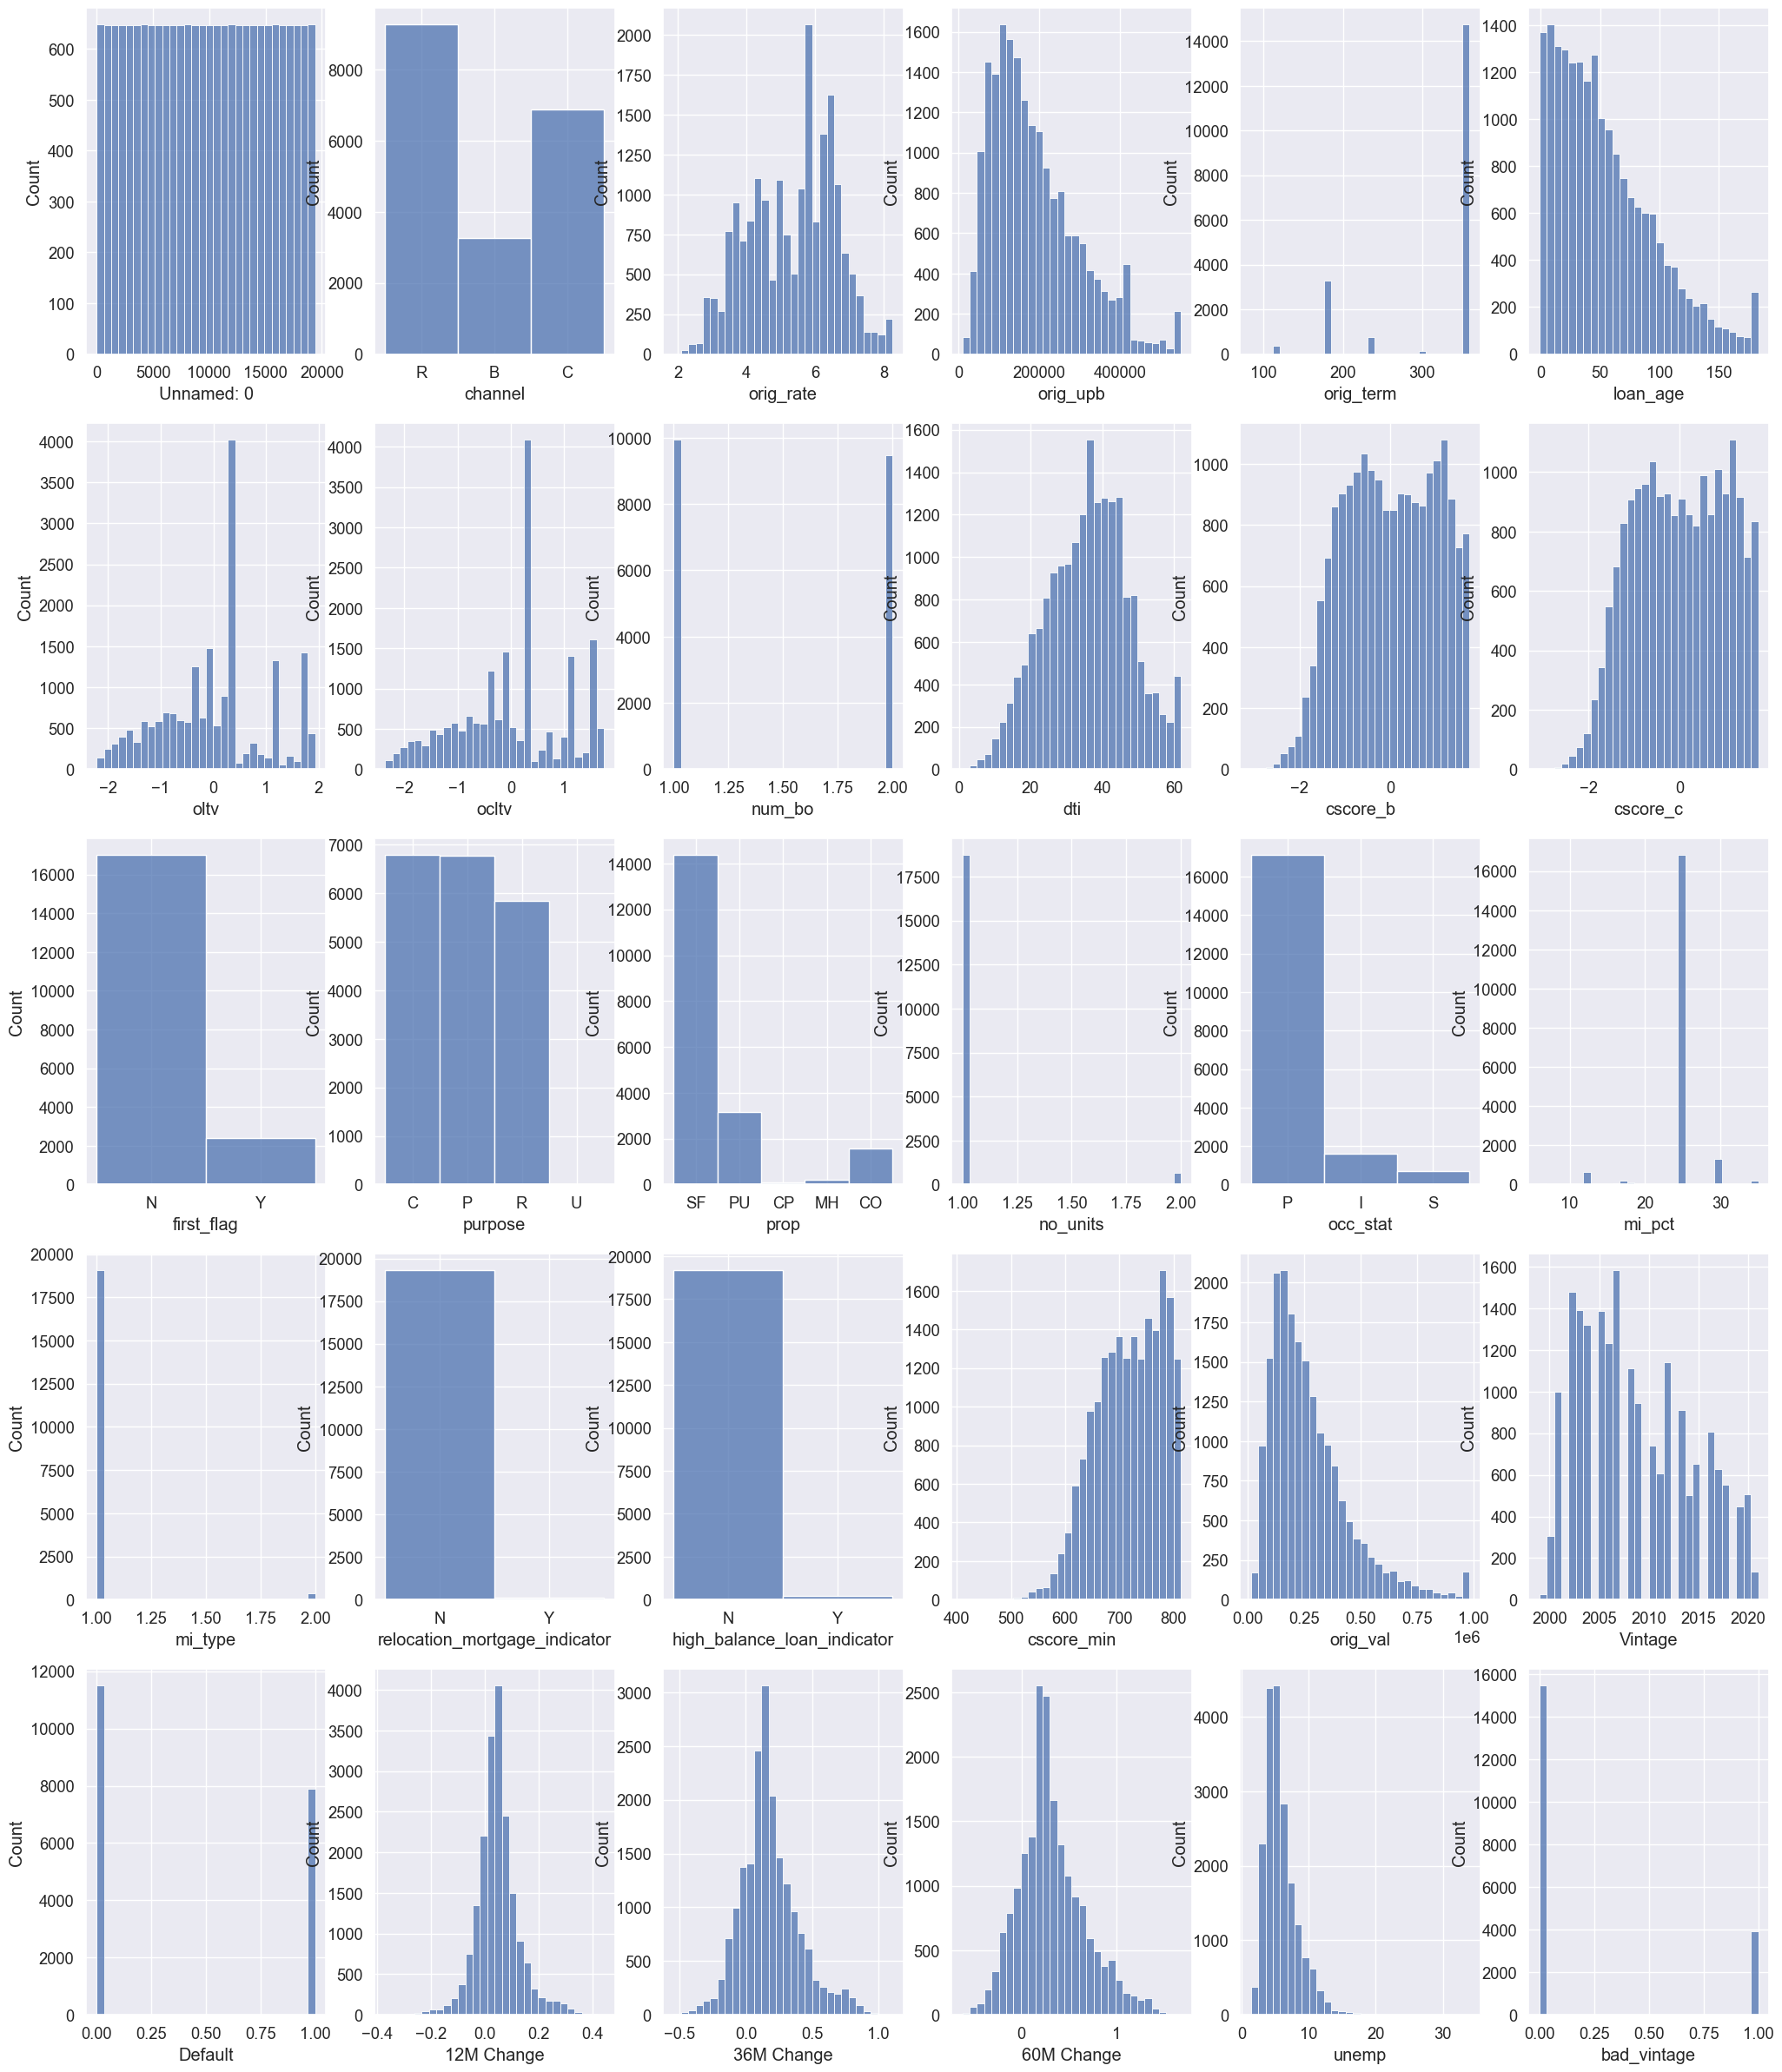

In [1058]:
plt.figure(figsize=(25,30))

for i in range(len(df_models.keys())):
    plt.subplot(5, 6, i+1)
    sns.histplot(df_models.iloc[:, i], bins=30)

- Converting to normal distribution for Logistic Regression

### Transformation
**np.sqrt Method**

- Loan Age

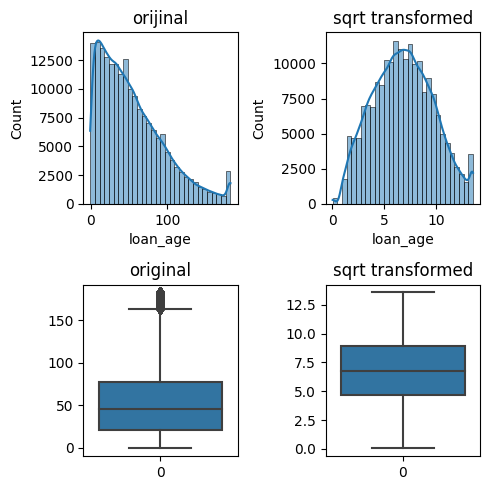

In [106]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['loan_age'], bins=30, kde=True)
plt.title('orijinal')
plt.subplot(2,2,2)
shifted_data = df_models['loan_age']-df_models['loan_age'].min()+0.001
sns.histplot(np.sqrt(shifted_data), bins=30, kde=True)
plt.title('sqrt transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models['loan_age'])
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(shifted_data))
plt.title('sqrt transformed')
plt.tight_layout();

-**Origination Value**

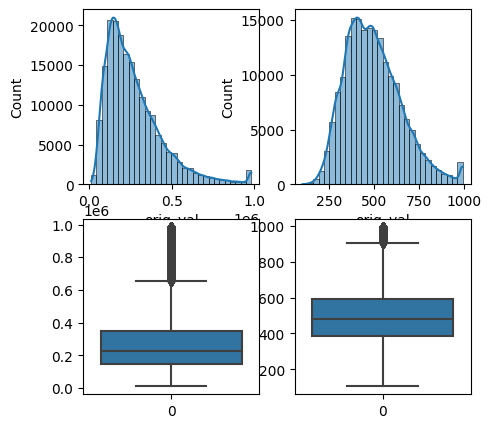

In [107]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['orig_val'], bins=30, kde= True)
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df_models['orig_val']), bins=30 , kde= True)
plt.subplot(2,2,3)
sns.boxplot(df_models['orig_val'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df_models['orig_val']));

- **Orig_upb**

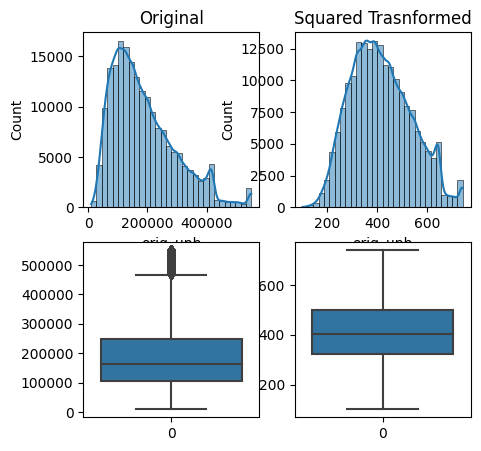

In [108]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['orig_upb'], bins=30, kde= True)
plt.title('Original')
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df_models['orig_upb']), bins=30 , kde= True)
plt.title('Squared Trasnformed')
plt.subplot(2,2,3)
sns.boxplot(df_models['orig_upb'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df_models['orig_upb']));

- **Unemployment**

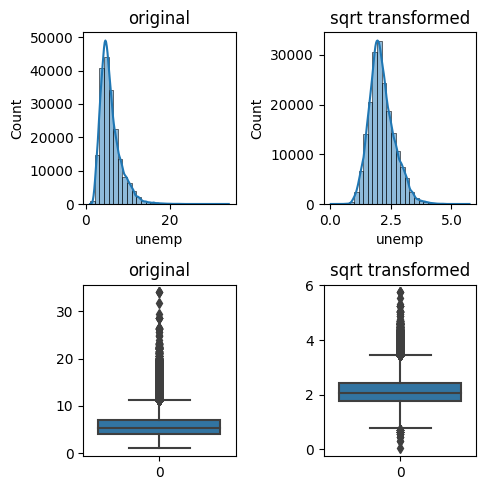

In [109]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['unemp'], bins=30, kde=True)
plt.title('original')
plt.subplot(2,2,2)
shifted_data = df_models['unemp']-df_models['unemp'].min()+0.001
sns.histplot(np.sqrt(shifted_data), bins=30, kde=True)
plt.title('sqrt transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models['unemp'])
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(shifted_data))
plt.title('sqrt transformed')
plt.tight_layout();

- **60 Month Change**

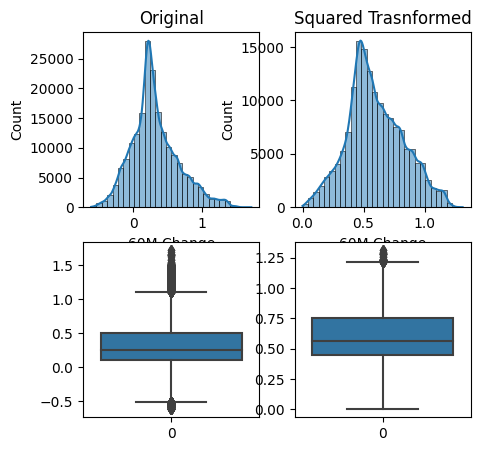

In [110]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['60M Change'], bins=30, kde= True)
plt.title('Original')
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df_models['60M Change']), bins=30 , kde= True)
plt.title('Squared Trasnformed')
plt.subplot(2,2,3)
sns.boxplot(df_models['60M Change'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df_models['60M Change']));

- **36 Month Change**

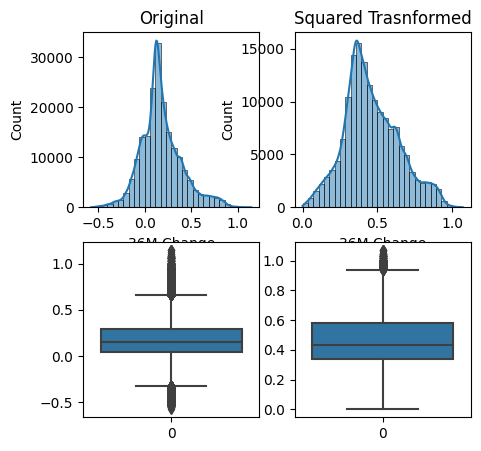

In [111]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models['36M Change'], bins=30, kde= True)
plt.title('Original')
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df_models['36M Change']), bins=30 , kde= True)
plt.title('Squared Trasnformed')
plt.subplot(2,2,3)
sns.boxplot(df_models['36M Change'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df_models['36M Change']));

**Yeo- Jhonson Method**

- **OLTV**

In [112]:
df_models_oltv= df_models['oltv']
transformer= PowerTransformer(method = 'yeo-johnson')
oltv =df_models['oltv'].values.reshape(-1,1) # reshape 2dim array
transformed_oltv = transformer.fit_transform(oltv)

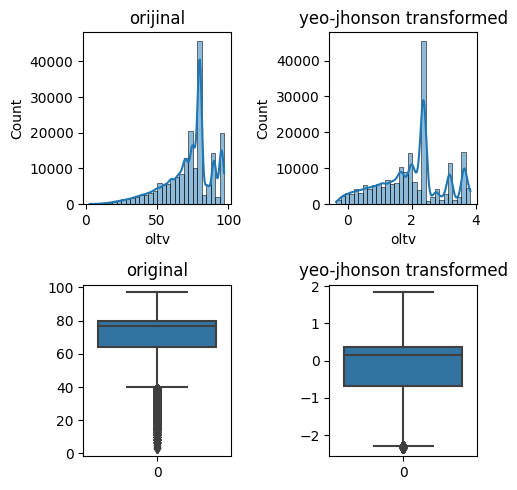

In [113]:
df_models['oltv'] = transformed_oltv.ravel()
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models_oltv, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df_models['oltv']+2, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models_oltv)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df_models['oltv'])
plt.title('yeo-jhonson transformed')
plt.tight_layout();

- **OCLTV**

In [114]:
df_models_ocltv= df_models['ocltv']
transformer= PowerTransformer(method = 'yeo-johnson')
ocltv =df_models['ocltv'].values.reshape(-1,1) 
transformed_ocltv = transformer.fit_transform(ocltv)

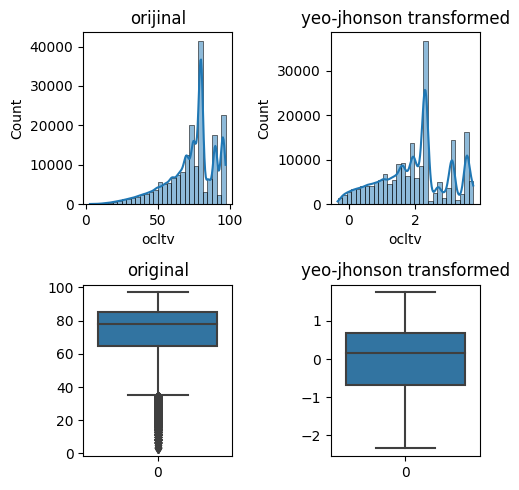

In [115]:
df_models['ocltv'] = transformed_ocltv.ravel()
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models_ocltv, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df_models['ocltv']+2, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models_ocltv)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df_models['ocltv'])
plt.title('yeo-jhonson transformed')
plt.tight_layout();

- **Coborrower CreditScore**

In [116]:
df_models_cscore_c=df_models['cscore_c']
transformer= PowerTransformer(method = 'yeo-johnson')
cscore_c =df_models['cscore_c'].values.reshape(-1,1) 
transformed_cscore_c = transformer.fit_transform(cscore_c)

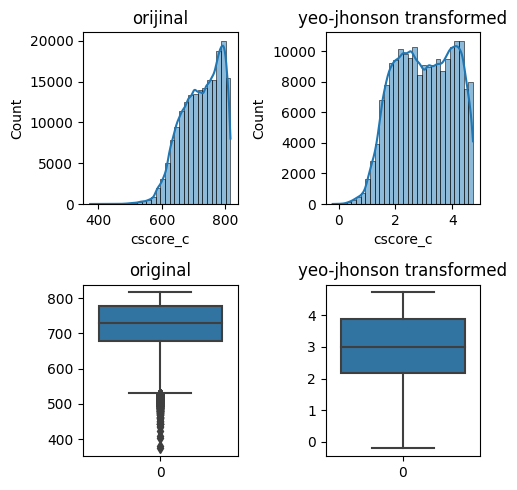

In [117]:
df_models['cscore_c'] = transformed_cscore_c.ravel()
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models_cscore_c, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df_models['cscore_c']+3, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models_cscore_c)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df_models['cscore_c']+3)
plt.title('yeo-jhonson transformed')
plt.tight_layout();

- **Borrower Credit Score**

In [118]:
df_models_cscore_b=df['cscore_b']
transformer= PowerTransformer(method = 'yeo-johnson')
cscore_b =df_models['cscore_b'].values.reshape(-1,1) # reshape 2dim array
transformed_cscore_b = transformer.fit_transform(cscore_b)

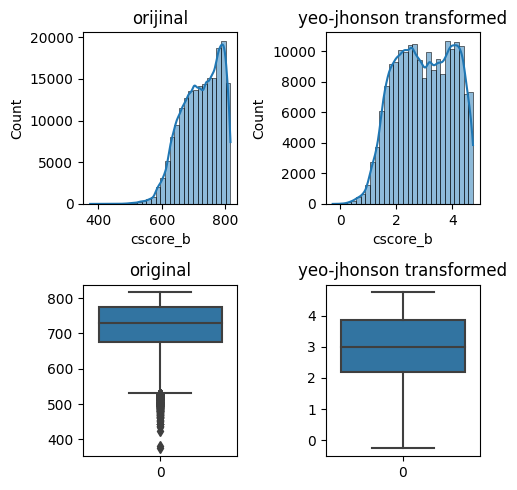

In [119]:
df_models['cscore_b'] = transformed_cscore_b.ravel()
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
sns.histplot(df_models_cscore_b, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df_models['cscore_b']+3, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_models_cscore_b)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df_models['cscore_b']+ 3)
plt.title('yeo-jhonson transformed')
plt.tight_layout();

In [120]:
df_models.drop('Unnamed: 0', axis= 1, inplace =True)

In [121]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193190 entries, 130792 to 77122
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        193190 non-null  object 
 1   orig_rate                      193190 non-null  float64
 2   orig_upb                       193190 non-null  float64
 3   orig_term                      193190 non-null  float64
 4   loan_age                       193190 non-null  float64
 5   oltv                           193190 non-null  float64
 6   ocltv                          193190 non-null  float64
 7   num_bo                         193190 non-null  float64
 8   dti                            193190 non-null  float64
 9   cscore_b                       193190 non-null  float64
 10  cscore_c                       193190 non-null  float64
 11  first_flag                     193190 non-null  object 
 12  purpose                        

In [122]:
df_models.to_csv('df_models1.csv')

In [123]:
df_models1 = pd.read_csv('df_models1.csv')

In [124]:
df_models1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     193190 non-null  int64  
 1   channel                        193190 non-null  object 
 2   orig_rate                      193190 non-null  float64
 3   orig_upb                       193190 non-null  float64
 4   orig_term                      193190 non-null  float64
 5   loan_age                       193190 non-null  float64
 6   oltv                           193190 non-null  float64
 7   ocltv                          193190 non-null  float64
 8   num_bo                         193190 non-null  float64
 9   dti                            193190 non-null  float64
 10  cscore_b                       193190 non-null  float64
 11  cscore_c                       193190 non-null  float64
 12  first_flag                    

In [125]:
df_models1.drop(columns ='Unnamed: 0', axis= 1, inplace =True)

# Split the Dataset

##  oot sample 

we will split the data like time series. We don't want our model mixed the years. rank of years is important.

In [126]:
df_models1['Vintage'].sort_values()

0         1999
283       1999
282       1999
281       1999
280       1999
          ... 
192263    2021
192262    2021
192261    2021
192269    2021
193189    2021
Name: Vintage, Length: 193190, dtype: int64

In [127]:
oot_index_names = df_models1[(df_models1['Vintage'] >= 2014)].index

In [128]:
oot_index_names

Index([151598, 151599, 151600, 151601, 151602, 151603, 151604, 151605, 151606,
       151607,
       ...
       193180, 193181, 193182, 193183, 193184, 193185, 193186, 193187, 193188,
       193189],
      dtype='int64', length=41592)

In [129]:
df_models1.loc[oot_index_names].columns

Index(['channel', 'orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv',
       'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c', 'first_flag',
       'purpose', 'prop', 'no_units', 'occ_stat', 'mi_pct', 'mi_type',
       'relocation_mortgage_indicator', 'high_balance_loan_indicator',
       'cscore_min', 'orig_val', 'Vintage', 'Default', '12M Change',
       '36M Change', '60M Change', 'unemp', 'bad_vintage'],
      dtype='object')

In [130]:
df_oot =df_models1.loc[oot_index_names]
print(df_oot.columns)

Index(['channel', 'orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv',
       'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c', 'first_flag',
       'purpose', 'prop', 'no_units', 'occ_stat', 'mi_pct', 'mi_type',
       'relocation_mortgage_indicator', 'high_balance_loan_indicator',
       'cscore_min', 'orig_val', 'Vintage', 'Default', '12M Change',
       '36M Change', '60M Change', 'unemp', 'bad_vintage'],
      dtype='object')


In [131]:
df_oot.shape #X_train

(41592, 29)

In [132]:
df_oot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41592 entries, 151598 to 193189
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   channel                        41592 non-null  object 
 1   orig_rate                      41592 non-null  float64
 2   orig_upb                       41592 non-null  float64
 3   orig_term                      41592 non-null  float64
 4   loan_age                       41592 non-null  float64
 5   oltv                           41592 non-null  float64
 6   ocltv                          41592 non-null  float64
 7   num_bo                         41592 non-null  float64
 8   dti                            41592 non-null  float64
 9   cscore_b                       41592 non-null  float64
 10  cscore_c                       41592 non-null  float64
 11  first_flag                     41592 non-null  object 
 12  purpose                        41592 non-null

In [133]:
Y_oot =df_oot['Default'] #y_train

In [134]:
Y_oot.shape

(41592,)

## df_ins 

In [135]:
df_ins=df_models1.drop(oot_index_names)

In [136]:
# in pandas model does not know which data first which is later we sort it then we split

In [137]:
df_ins_cv=df_ins.copy() #cross val
df_ins_cv.set_index('Vintage', inplace=True)
df_ins_cv.sort_index(inplace=True)

In [138]:
df_ins.shape

(151598, 29)

In [139]:
Y_ins=df_ins['Default']
Y_ins_cv=df_ins_cv['Default']

In [140]:
Y_ins.shape

(151598,)

In [141]:
df_oot.drop(['Default','Vintage'],axis=1, inplace=True)

In [142]:
df_ins.drop(['Default','Vintage'],axis=1, inplace=True)

In [143]:
df_ins.shape

(151598, 27)

In [144]:
df_oot.shape , df_ins.shape, Y_oot.shape,Y_ins.shape

((41592, 27), (151598, 27), (41592,), (151598,))

In [145]:
type(Y_oot)

pandas.core.series.Series

Below code is a function that implements grid search with cross validation for XGBoost classifier with early stopping. The function takes in several inputs including the parameter grid, fit parameters, scoring method, cross validation splitting method, input data matrix (X) and ground truth labels (y), and number of random iterations. For each iteration of the cross validation splitting, the function trains the XGBoost model with a randomly chosen combination of parameters from the parameter grid and the given fit parameters, and calculates the performance score using the given scoring method. The function then keeps track of the best set of parameters and the number of boosting rounds for each fold, and outputs the mean score and best set of parameters after all folds have been completed.

In [146]:
num_vars=['orig_rate', 'orig_upb','orig_val',
       'orig_term' ,'loan_age',
       'oltv', 'ocltv',  'dti', 'cscore_b', 'cscore_c','cscore_min',
        'mi_pct','12M Change','36M Change','60M Change','unemp','bad_vintage']
cat_vars=['channel','purpose', 'prop', 'no_units', 'occ_stat',
       'mi_type',
       'num_bo','first_flag',
       'relocation_mortgage_indicator', 'high_balance_loan_indicator']

## Scaling  
**MinMax Scaling**

In [147]:
scaler = MinMaxScaler()
df_ins_scaled = pd.DataFrame(scaler.fit_transform(df_ins[num_vars]), columns =num_vars)
df_oot_scaled = pd.DataFrame(scaler.transform(df_oot[num_vars]), columns= num_vars)

## Encoding  
**Getdummies**

In [148]:
# Use pd.get_dummies to one-hot encode the categorical columns in both train and test datasets
df_ins_encoded = pd.get_dummies(df_ins[cat_vars], columns=cat_vars).astype(float)
df_oot_encoded = pd.get_dummies(df_oot[cat_vars], columns=cat_vars).astype(float)

- **Concantanation**

In [149]:
df_ins1= pd.concat([df_ins_scaled, df_ins_encoded], axis=1)

In [150]:
df_oot_scaled.reset_index(drop=True, inplace=True)  # Reset the index to ensure alignment
df_oot_encoded.reset_index(drop=True, inplace=True)
df_oot1 = pd.concat([df_oot_scaled, df_oot_encoded], axis=1)

In [151]:
df_oot1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41592 entries, 0 to 41591
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   orig_rate                        41592 non-null  float64
 1   orig_upb                         41592 non-null  float64
 2   orig_val                         41592 non-null  float64
 3   orig_term                        41592 non-null  float64
 4   loan_age                         41592 non-null  float64
 5   oltv                             41592 non-null  float64
 6   ocltv                            41592 non-null  float64
 7   dti                              41592 non-null  float64
 8   cscore_b                         41592 non-null  float64
 9   cscore_c                         41592 non-null  float64
 10  cscore_min                       41592 non-null  float64
 11  mi_pct                           41592 non-null  float64
 12  12M Change        

In [152]:
df_oot1.shape, Y_oot.shape, df_ins1.shape,Y_ins.shape

((41592, 44), (41592,), (151598, 45), (151598,))

- df_oot1 does not have Purpose U column I need to drop it from df_ins1

In [154]:
df_ins1.drop(columns= 'purpose_U', axis= 1, inplace= True)

In [155]:
df_oot1.shape, Y_oot.shape, df_ins1.shape,Y_ins.shape

((41592, 44), (41592,), (151598, 44), (151598,))

In [156]:
final_features=list(df_ins1)

In [157]:
len(final_features)

44

# Modeling  (XGBoost)

In [158]:
def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, cv, X, y,n_iter):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (DataFrame): The input data matrix.
        y (Series): The ground truth label.

    Returns:
        dict: The best set of parameters found via grid search.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    param_names, param_values = zip(*list(param_grid.items()))
    GS_unvrs_rand=random.sample(list(product(*param_values)), n_iter)
    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)
        fit_params_cv['eval_set'] = [(X_out, y_out)]

  #      for value_combination in product(*param_values):
        for value_combination in GS_unvrs_rand:
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBClassifier(**dict(param_grid_cv))

            xgboost.fit(X_in, y_in, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, X_out, y_out)
            cv_results[param_grid_cv].append(score)

    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))

    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators


    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))

    return best_params_xgb

In [159]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold

param_grid = {
    'objective': ['binary:logistic'],
    'n_estimators': [200, 500, 1000],
    'max_depth': [2,5,7,9],
    'learning_rate': [0.1,0.05],
    'random_state': [0,42]
}

fit_params = {
    'eval_metric': "logloss",
    'early_stopping_rounds': 10,
    'verbose': False
}

scorer = make_scorer(roc_auc_score)

kf=TimeSeriesSplit(n_splits=4)
n_iter=5
best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, kf, df_ins1, Y_ins,n_iter)

best_xgb = XGBClassifier(**best_params_xgb)

best_xgb.fit(df_ins1, Y_ins, eval_metric=fit_params['eval_metric'], verbose=False)
best_score = scorer(best_xgb, df_oot1, Y_oot)
print("The best score for XGBoost on validation set is {:.3f}".format(best_score))


Best score: 0.721
Best Parameters: {'objective': 'binary:logistic', 'n_estimators': 336, 'max_depth': 2, 'learning_rate': 0.05, 'random_state': 0}
The best score for XGBoost on validation set is 0.546


In [161]:
xgbc= best_xgb

In [162]:
new_params =xgbc.get_params()
new_params

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 2,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 336,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## Feature Importances  
**XGBoost Classifier**

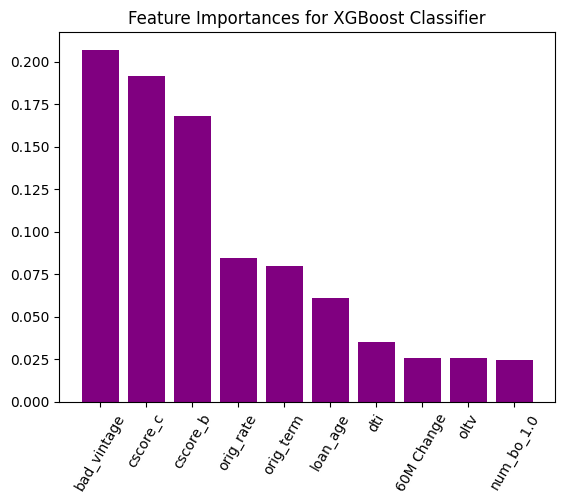

In [163]:
sorted_indices= xgbc.feature_importances_.argsort()[::-1]
top_feature_names=df_ins1.columns[sorted_indices][:10]
top_feature_importances =xgbc.feature_importances_[sorted_indices][:10]

plt.bar(top_feature_names,top_feature_importances, color= 'purple')
plt.xticks(rotation= 60)
plt.title('Feature Importances for XGBoost Classifier')
plt.savefig('xgbimportandce_p3.png');

# Save the Model

In [164]:
model_path_nv = "POC_Model/Model"
model_path_v = "POC_Model/Model"
output_dir = "POC_Model/Output"
train_path = "POC_Model/Data"
test_path = "POC_Model/Data"
data_path="POC_Model/Data"
explainer_pkl = os.path.join(output_dir, 'fitted_shap_explainer_5ct.pkl')
job_lib_path=os.path.join(model_path_nv, 'mortgage.json')
pkl_path=os.path.join(model_path_nv, 'mortgage.pkl')

In [165]:
xgbc.save_model(job_lib_path)

In [166]:
Y_oot.value_counts()

Default
0    28609
1    12983
Name: count, dtype: int64

## Confusion Matrix

[[5.3019458e-01 4.6980542e-01]
 [9.1045010e-01 8.9549884e-02]
 [8.4115261e-01 1.5884741e-01]
 ...
 [9.9627799e-01 3.7220232e-03]
 [9.9924010e-01 7.5987336e-04]
 [9.8630458e-01 1.3695441e-02]]
[[21421  7188]
 [ 2460 10523]]


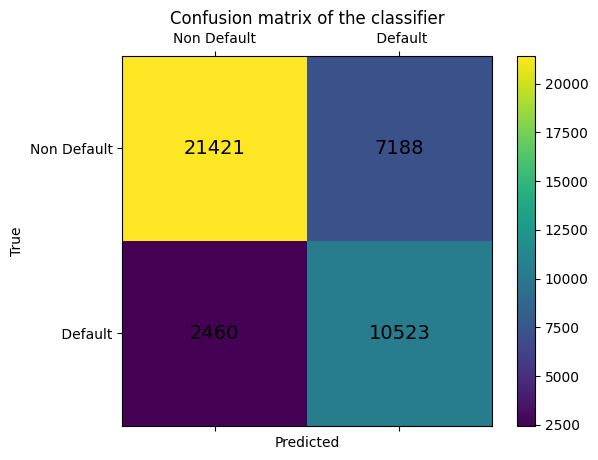

f1: 68.57%


0.8604565901639236

In [167]:
from sklearn.metrics import confusion_matrix, f1_score,roc_auc_score

threshold=0.08
ypred = xgbc.predict_proba(df_oot1.values)
print(ypred)

ypred_binary = (ypred[:, 1] >= threshold).astype(int)
np.unique(ypred_binary,return_counts=True)

cm = confusion_matrix(Y_oot,ypred_binary)
print(cm)
labels=['Non Default', ' Default']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# Add class counts to the heatmap cells
for i in range(2):
    for j in range(2):
        ax.text(j + 0.0, i + 0.0, str(cm[i, j]), ha='center', va='center', color='black',fontsize=14)


plt.show()
f1 = f1_score(Y_oot, ypred_binary)
print("f1: %.2f%%" % (f1 * 100.0))

ypred_p = xgbc.predict_proba(df_oot1.values)
roc_auc_score(Y_oot, ypred_p[:, 1])

0.8605 is good we dont want to increase our model prediction we check roc score and rank oredering

In [168]:
xgbc.predict_proba(df_ins1.values)

array([[0.6673674 , 0.3326326 ],
       [0.99288976, 0.00711022],
       [0.60833275, 0.39166722],
       ...,
       [0.86746234, 0.13253765],
       [0.9787084 , 0.02129162],
       [0.9843863 , 0.01561366]], dtype=float32)

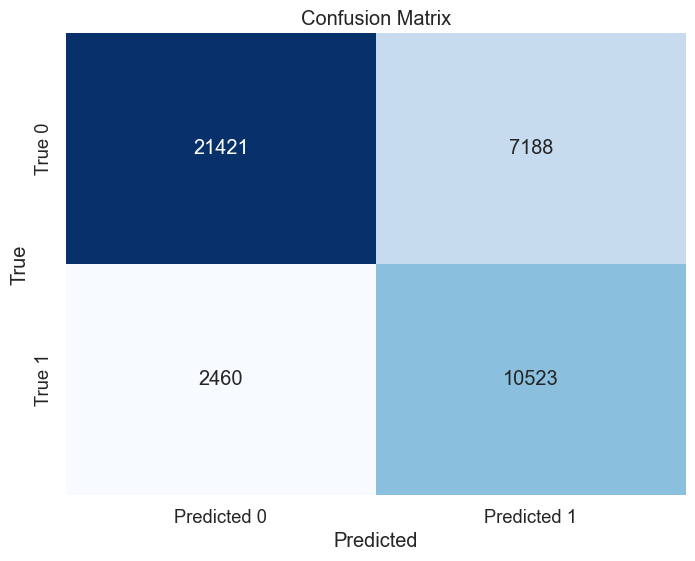

In [170]:
confusion_mat = cm

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot the Data 

In [171]:
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151598 entries, 0 to 151597
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        151598 non-null  object 
 1   orig_rate                      151598 non-null  float64
 2   orig_upb                       151598 non-null  float64
 3   orig_term                      151598 non-null  float64
 4   loan_age                       151598 non-null  float64
 5   oltv                           151598 non-null  float64
 6   ocltv                          151598 non-null  float64
 7   num_bo                         151598 non-null  float64
 8   dti                            151598 non-null  float64
 9   cscore_b                       151598 non-null  float64
 10  cscore_c                       151598 non-null  float64
 11  first_flag                     151598 non-null  object 
 12  purpose                       

In [172]:
final_features

['orig_rate',
 'orig_upb',
 'orig_val',
 'orig_term',
 'loan_age',
 'oltv',
 'ocltv',
 'dti',
 'cscore_b',
 'cscore_c',
 'cscore_min',
 'mi_pct',
 '12M Change',
 '36M Change',
 '60M Change',
 'unemp',
 'bad_vintage',
 'channel_B',
 'channel_C',
 'channel_R',
 'purpose_C',
 'purpose_P',
 'purpose_R',
 'prop_CO',
 'prop_CP',
 'prop_MH',
 'prop_PU',
 'prop_SF',
 'no_units_1.0',
 'no_units_2.0',
 'occ_stat_I',
 'occ_stat_P',
 'occ_stat_S',
 'mi_type_1.0',
 'mi_type_2.0',
 'mi_type_3.0',
 'num_bo_1.0',
 'num_bo_2.0',
 'first_flag_N',
 'first_flag_Y',
 'relocation_mortgage_indicator_N',
 'relocation_mortgage_indicator_Y',
 'high_balance_loan_indicator_N',
 'high_balance_loan_indicator_Y']

In [173]:
df_ins1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151598 entries, 0 to 151597
Data columns (total 44 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   orig_rate                        151598 non-null  float64
 1   orig_upb                         151598 non-null  float64
 2   orig_val                         151598 non-null  float64
 3   orig_term                        151598 non-null  float64
 4   loan_age                         151598 non-null  float64
 5   oltv                             151598 non-null  float64
 6   ocltv                            151598 non-null  float64
 7   dti                              151598 non-null  float64
 8   cscore_b                         151598 non-null  float64
 9   cscore_c                         151598 non-null  float64
 10  cscore_min                       151598 non-null  float64
 11  mi_pct                           151598 non-null  float64
 12  12

In [174]:
ypred = pd.DataFrame(xgbc.predict_proba(df_ins1.values),columns=['predA','pred'])
df1 = pd.DataFrame(df_ins1.values, columns =final_features)
df2 = pd.DataFrame(Y_ins.values, columns =['target'])
df3 = df.drop(oot_index_names)
df_ins_4plot_xgb=pd.concat([df1,df2,df3[['loan_id','act_period','Vintage']],ypred],axis=1)

In [175]:
ypred

predA      pred
0       0.667367  0.332633
1       0.992890  0.007110
2       0.608333  0.391667
3       0.494854  0.505146
4       0.134933  0.865067
...          ...       ...
151593  0.942472  0.057528
151594  0.993600  0.006400
151595  0.867462  0.132538
151596  0.978708  0.021292
151597  0.984386  0.015614

[151598 rows x 2 columns]

In [176]:
ypred_oot = pd.DataFrame(xgbc.predict_proba(df_oot1.values),columns=['predA','pred'])
df1_oot = pd.DataFrame(df_oot1.values, columns =final_features)
df2_oot = pd.DataFrame(Y_oot.values, columns =['target'])
df3_oot=df.loc[oot_index_names] 
df1_oot.reset_index(drop=True, inplace=True)  
df3_oot.reset_index(drop=True, inplace=True)
df_oot_4plot_xgb=pd.concat([df1_oot,df2_oot,df3_oot[['loan_id','act_period','Vintage']],ypred_oot],axis=1)

In [177]:
#X_train, X_test, y_train, y_test
#------------------
#x_var='dti'
#x_var_plot="Debt to Income Ratio"
#x_var='cscore_b'
#x_var_plot="Borrower FICO"
#x_var='loan_age'
#x_var_plot='Loan Age'
#x_var='unemp'
#x_var_plot='Unemployment'
#x_var='loan_age'
#x_var_plot='Loan Age'
#x_var='20Q Change'
#x_var_plot='20Q Change'
#x_var='act_period'
#x_var_plot='act_period'

x_var='Vintage' #x axis
x_var_plot='Vintage'

y_var='target'
y_pred='pred'
bin_size=6


In [178]:
df2['target']

0         0
1         0
2         0
3         1
4         0
         ..
151593    0
151594    0
151595    1
151596    0
151597    0
Name: target, Length: 151598, dtype: int64

In [179]:
df_ins_4plot_xgb['Vintage']

0         2008
1         2000
2         2001
3         2014
4         2003
          ... 
151593    2013
151594    2013
151595    2007
151596    2020
151597    2008
Name: Vintage, Length: 151598, dtype: int64

In [180]:
df_ins_4plot_xgb['act_period'] = pd.to_datetime(df_ins_4plot_xgb['act_period'], errors='coerce')

In [181]:
df_oot_4plot_xgb['act_period'] = pd.to_datetime(df_oot_4plot_xgb['act_period'], errors='coerce')

In [182]:
def marginal_plots(df_ins_4plot,df_oot_4plot,x_var,x_var_plot,y_var,y_pred,bin_size=6):
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('Default: Marginal Plot for {}.'.format(x_var_plot), fontsize=16)
    gs = gridspec.GridSpec(2, 2, hspace=.1,height_ratios=[2, 1])

    # the first subplot for model performance along the feature of interest in-sample
    ax0 = plt.subplot(gs[0])

    s=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_var]
    line0, = ax0.plot(s.index.astype(str), s.values, color='r',label='line1')
    sp=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_pred]
    line1, = ax0.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Build")

    # the second subplot for counts for that feature in-sample
    # shared axis X
    ax1 = plt.subplot(gs[2], sharex = ax0)
    ax0.grid()
    ax1.grid()

    t=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax0.get_xticklabels(), visible=False)
    line2= ax1.bar(t.index.astype(str), t.values, color='b')
    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    # put legend on first subplot
    ax0.legend((line0, line1), ('Actuals', 'Predictions'), loc='lower left')

    # the third subplot for model performance along the feature of interest in holdout

    ax2 = plt.subplot(gs[1])
    # log scale for axis Y of the first subplot
    s=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_var]
    line4, = ax2.plot(s.index.astype(str), s.values, color='r',label='line1')
    sp=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_pred]+0.20
    line5, = ax2.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Post-Build")

    # # the fourth subplot for counts for that feature in holdout
    # shared axis X
    ax3 = plt.subplot(gs[3], sharex = ax2)
    ax2.grid()
    ax3.grid()

    t=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax2.get_xticklabels(), visible=False)
    line6= ax3.bar(t.index.astype(str), t.values, color='b')

    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax3.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    plt.show()

In [183]:
x_var_list=['Vintage',
            'orig_rate',
 'orig_upb',
 'orig_val',
 'orig_term',
 'loan_age',
 'oltv',
 'ocltv',
 'dti',
 'cscore_b',
 'cscore_c',
 'cscore_min',
 'mi_pct',
 '12M Change',
 '36M Change',
 '60M Change',
 'unemp']
x_var_name=['Vintage',
            'Origination Rate',
            'Origination Balance',
            'Origination Value',
            'Origination Term',
            'Loan Age',
            'Origination LTV',
           'Origination CLTV',
            'Debt to Income',
            'Borrower FICO',
            'CoBorrower FICO',
            'Minimum FICO',
            'Mortgage Insurance Percent',
            '12M HPA',
            '36M HPA',
            '60M HPA',
            'Unemployment']

In [184]:
df_ins_4plot_xgb.shape,df_oot_4plot_xgb.shape

((151598, 50), (41592, 50))

In [185]:
print(df_ins_4plot_xgb[y_var].dtype)


int64


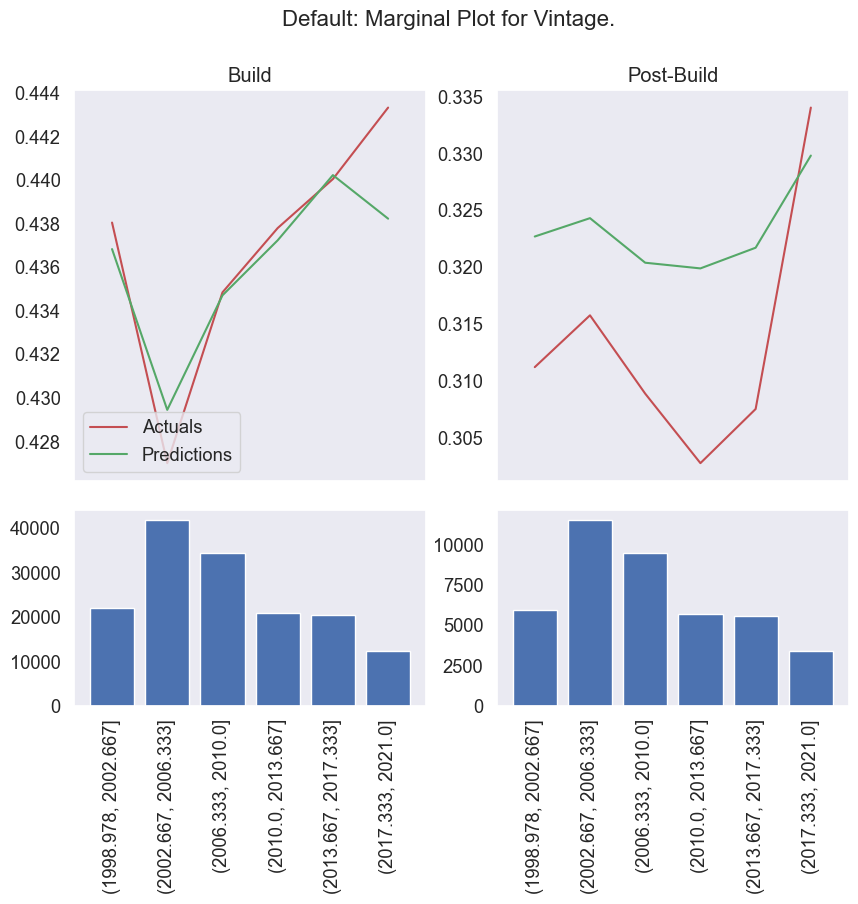

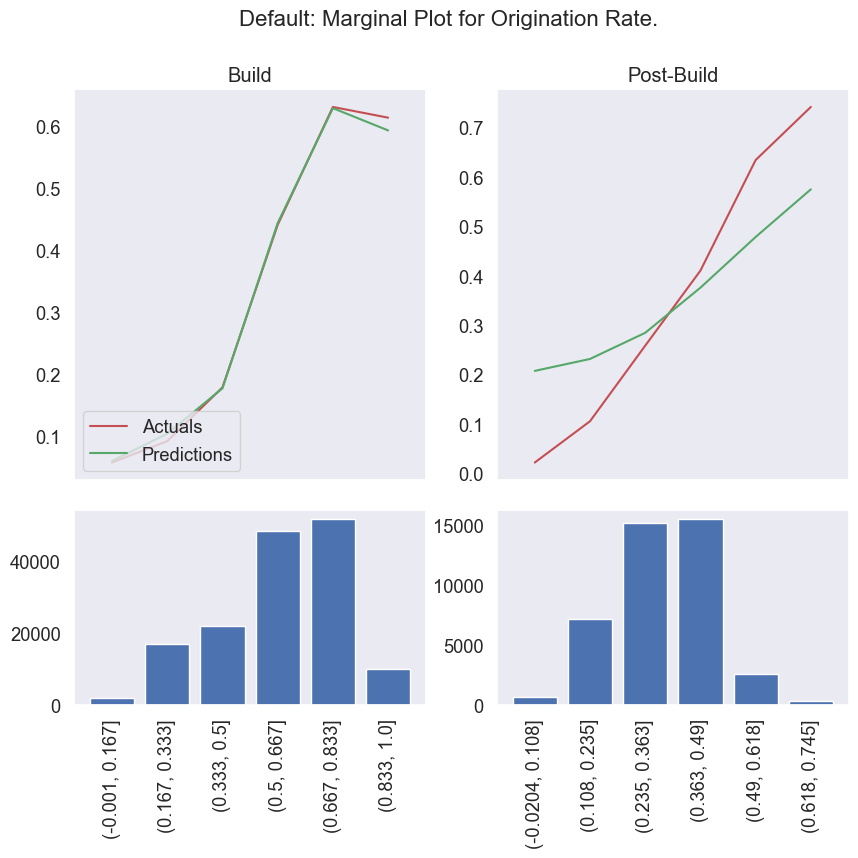

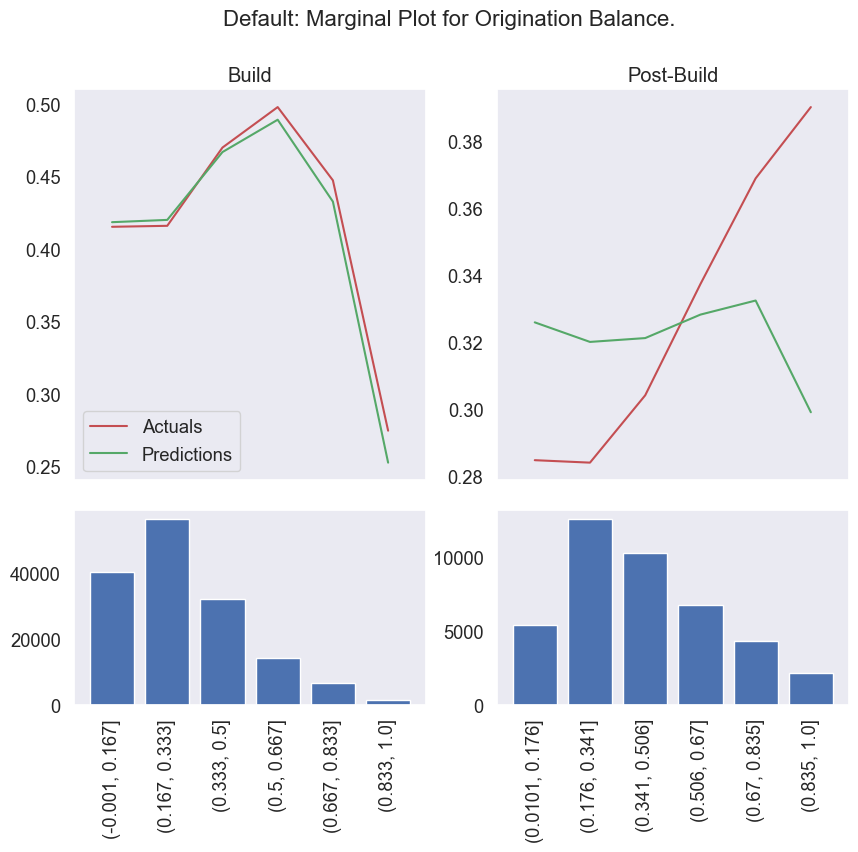

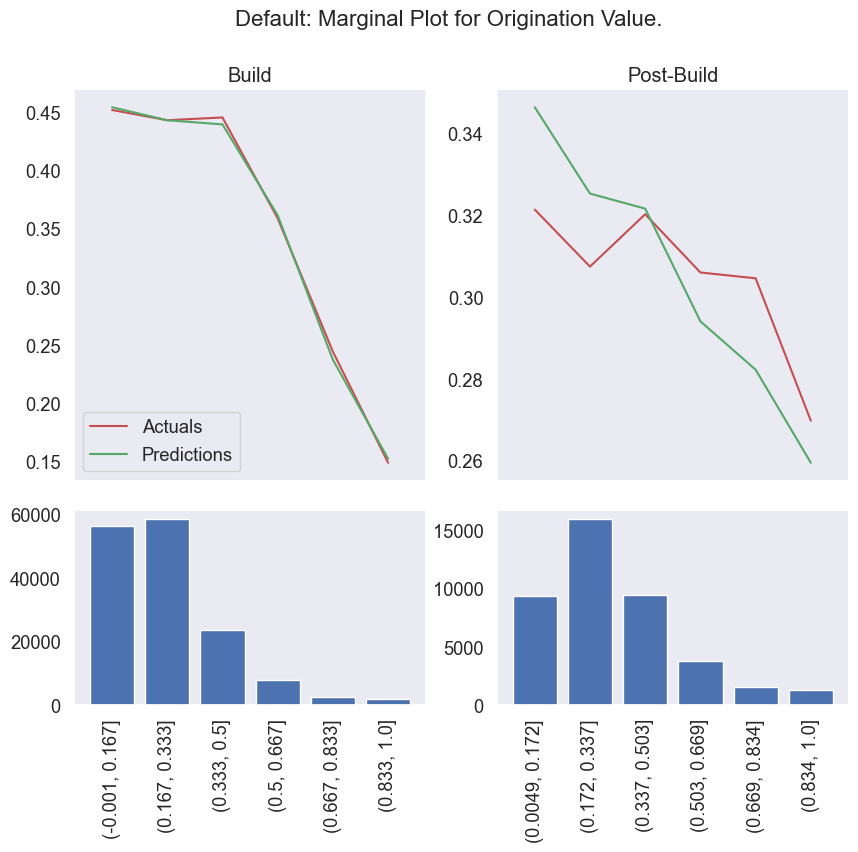

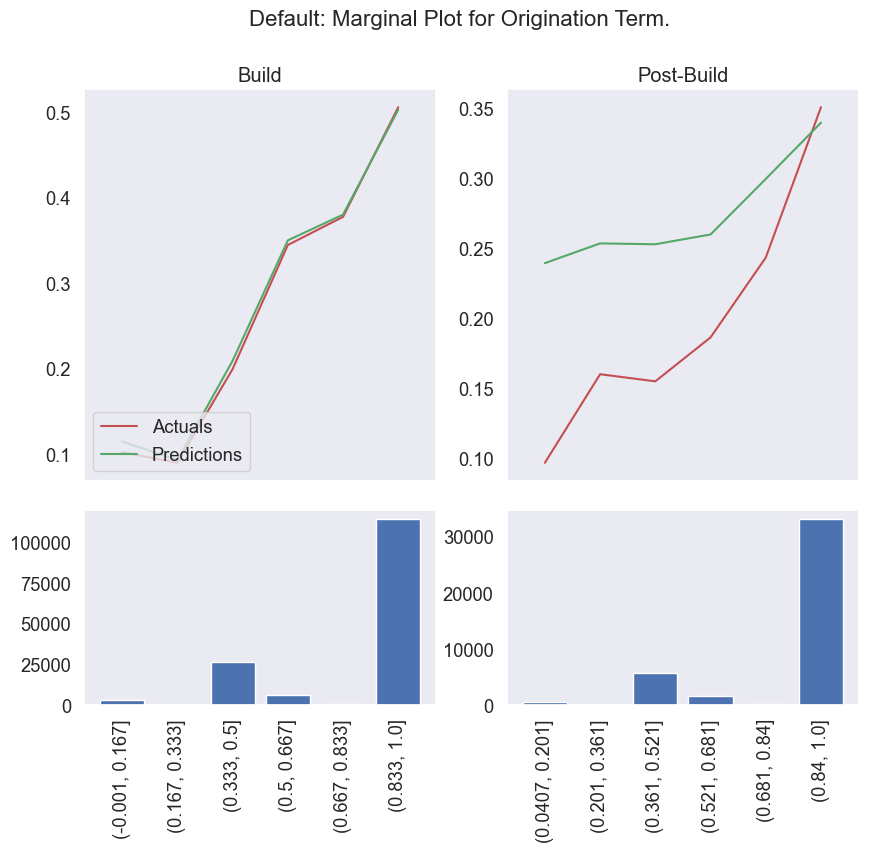

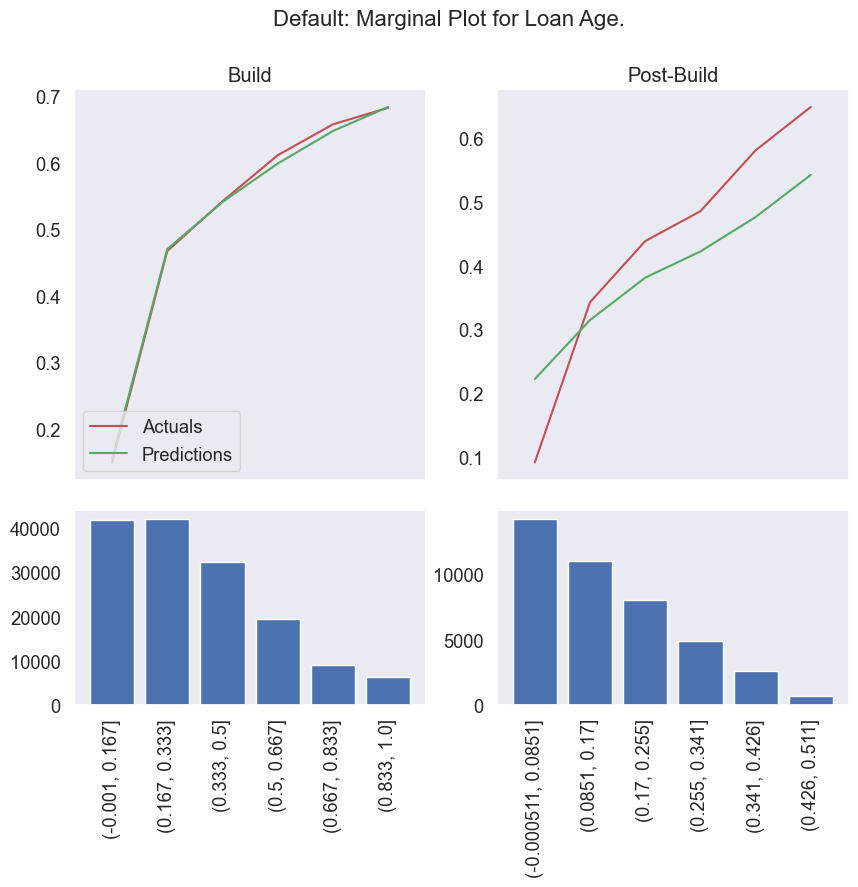

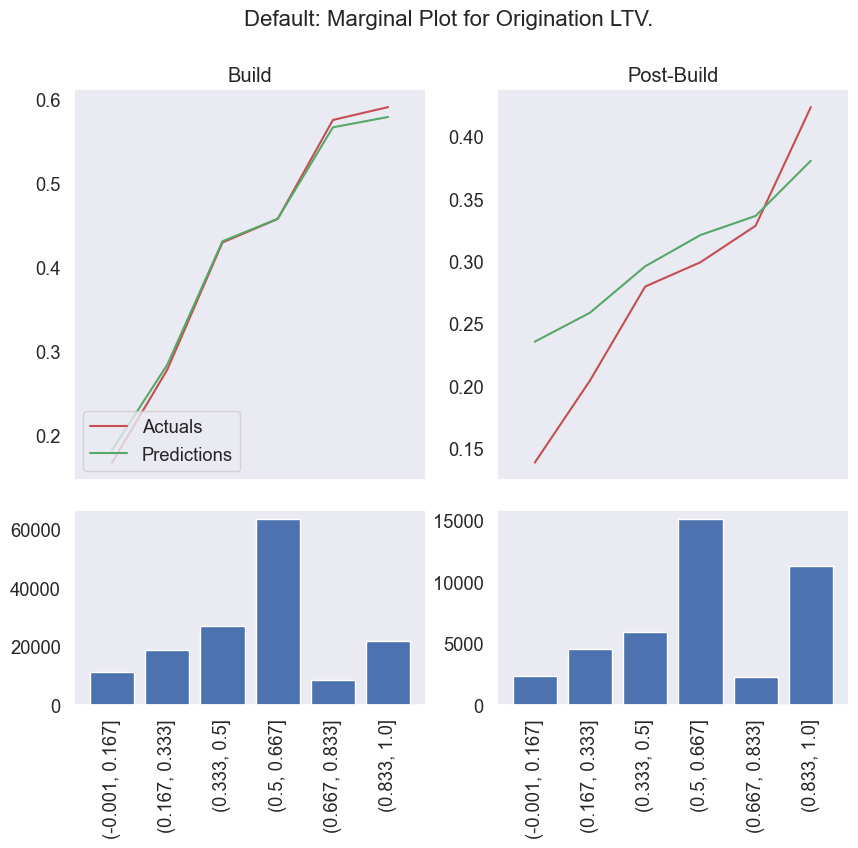

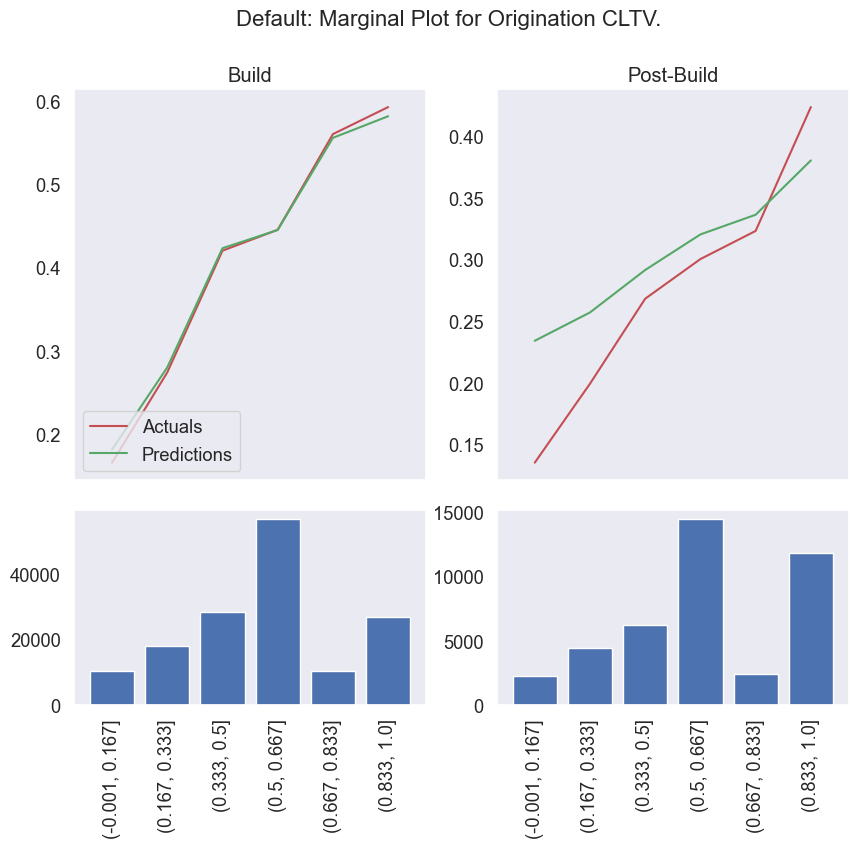

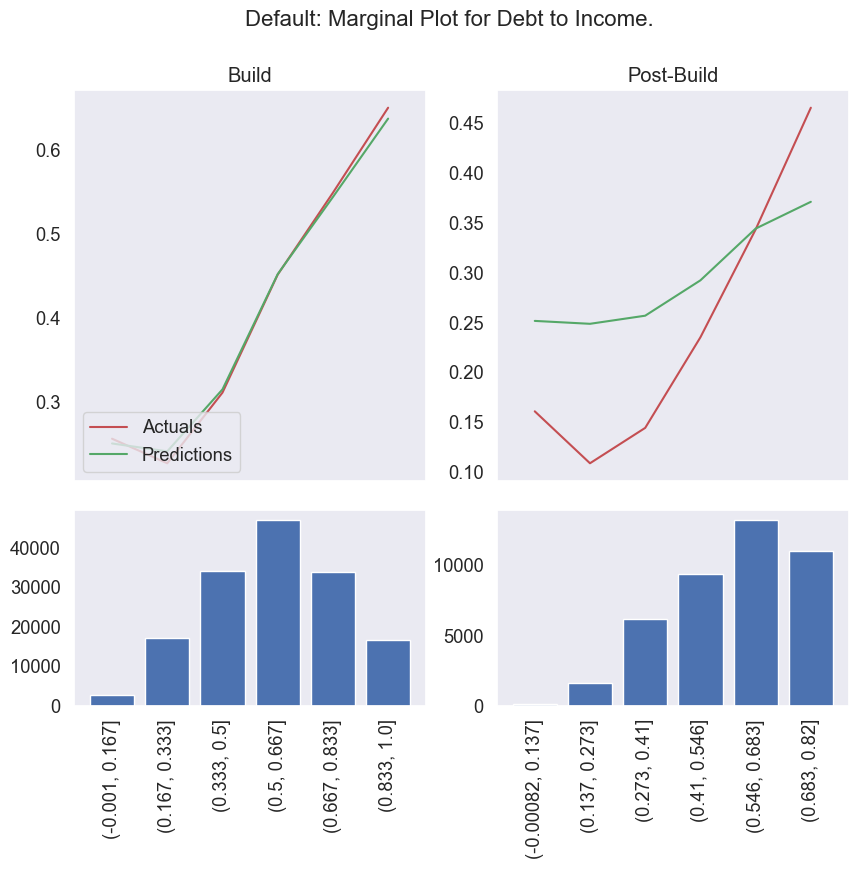

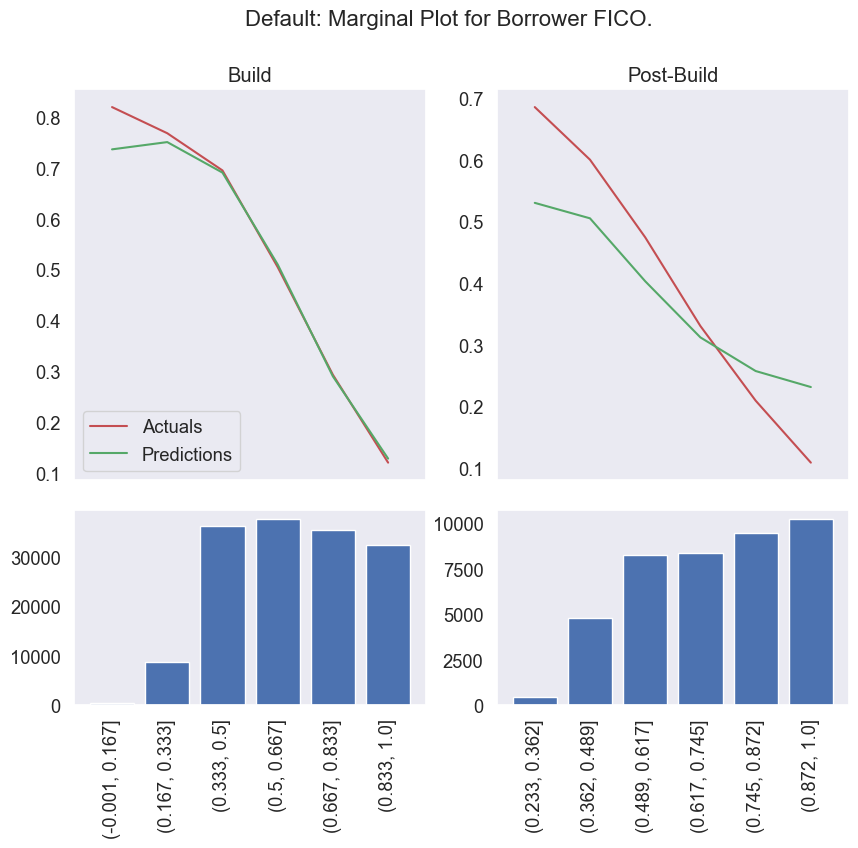

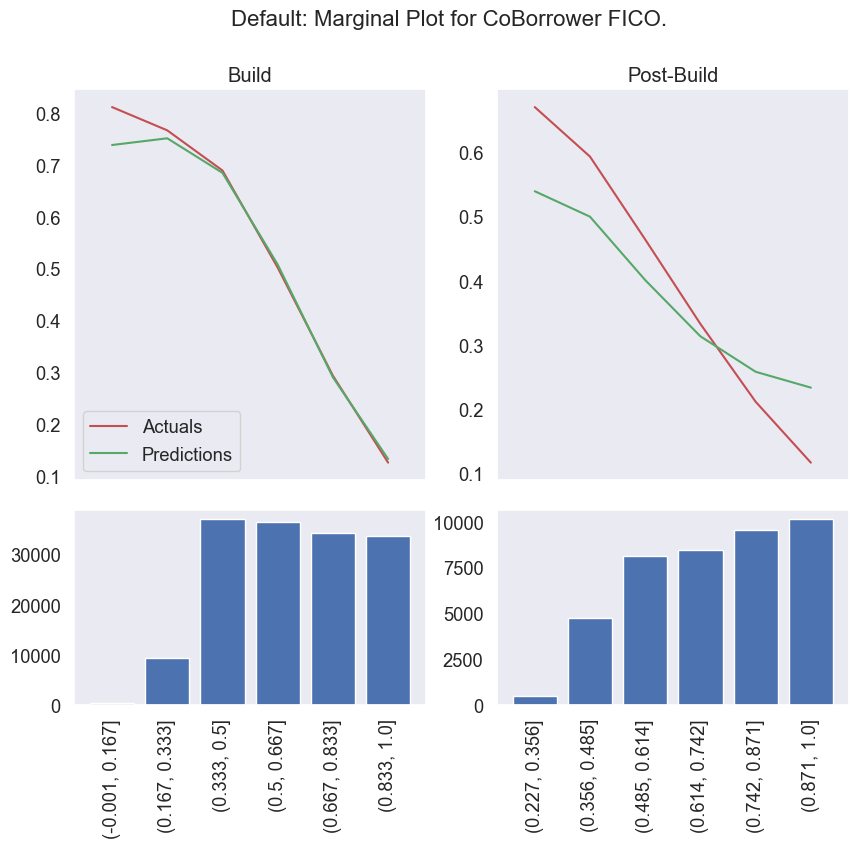

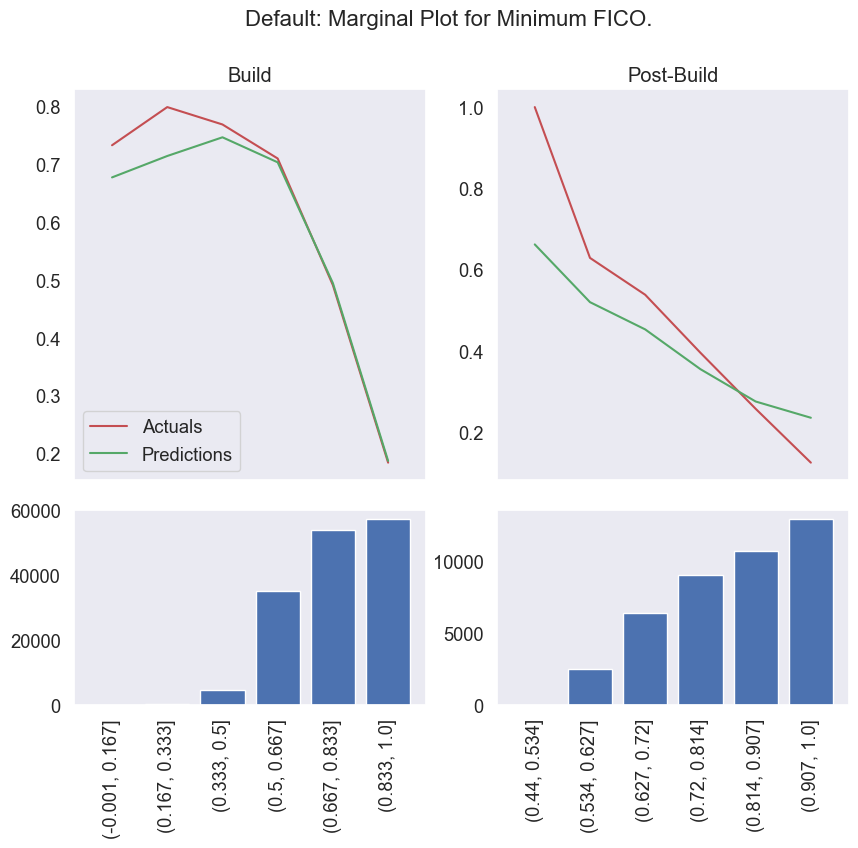

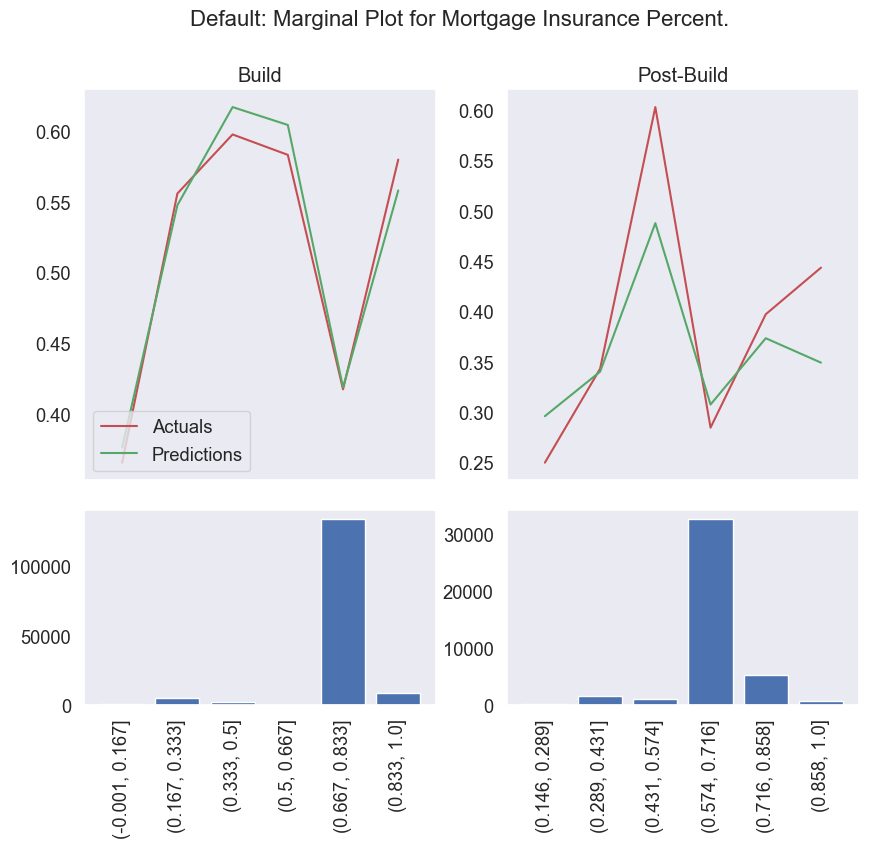

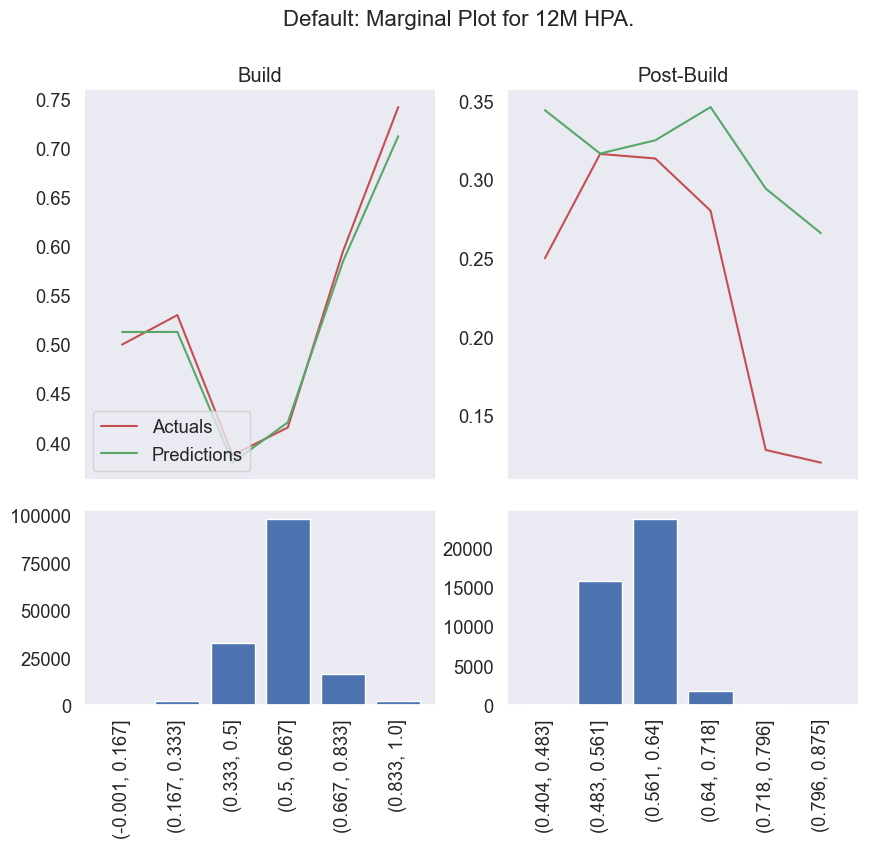

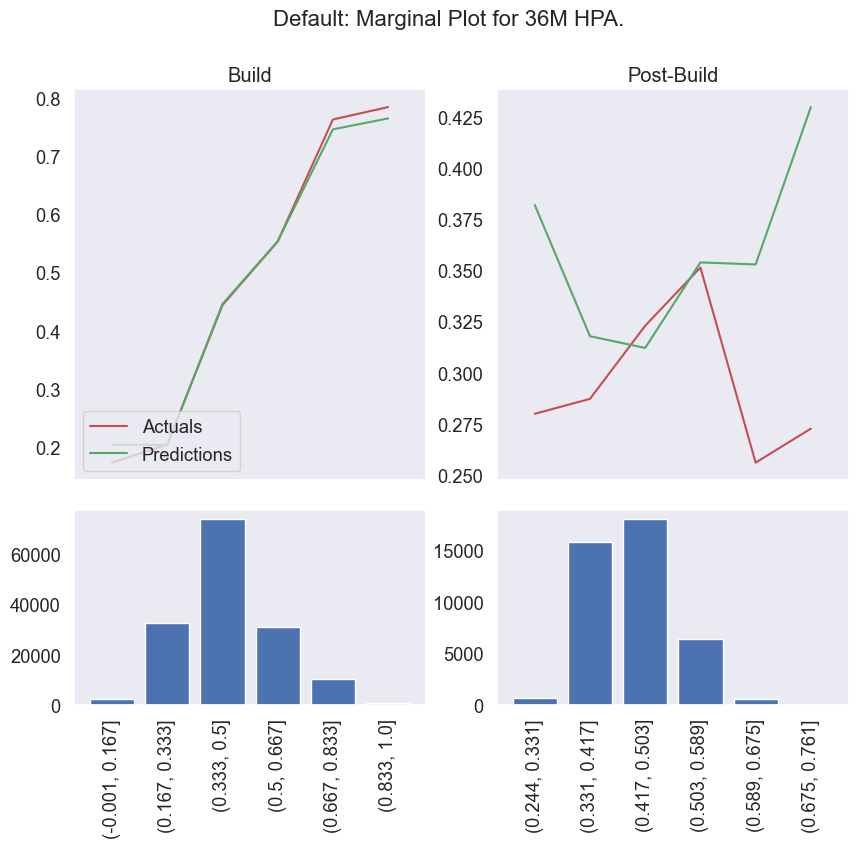

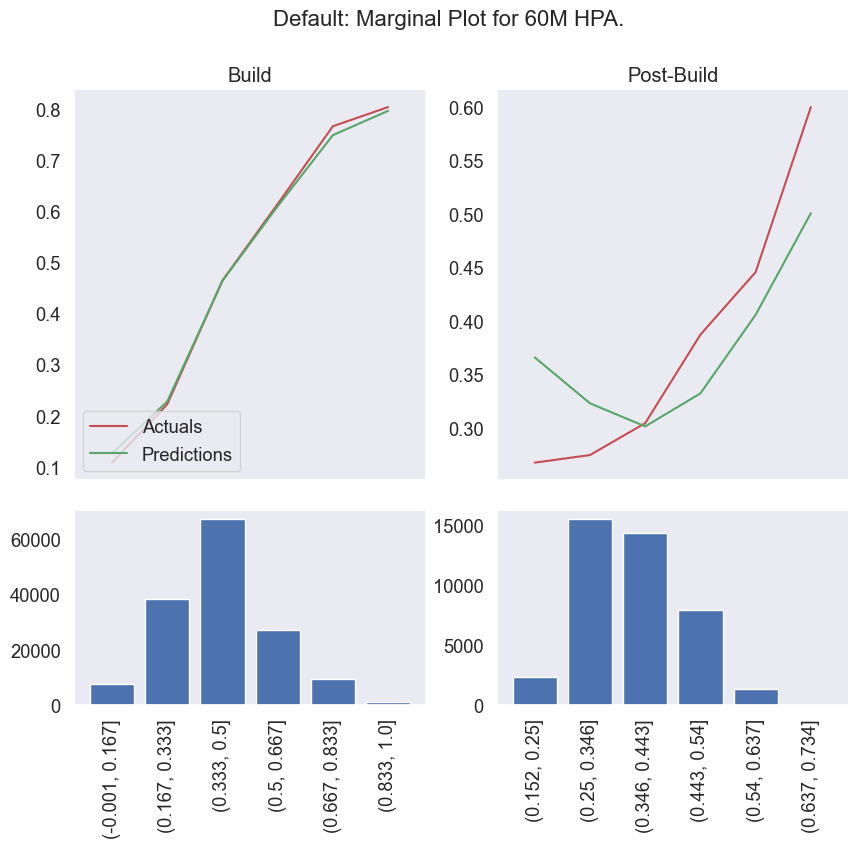

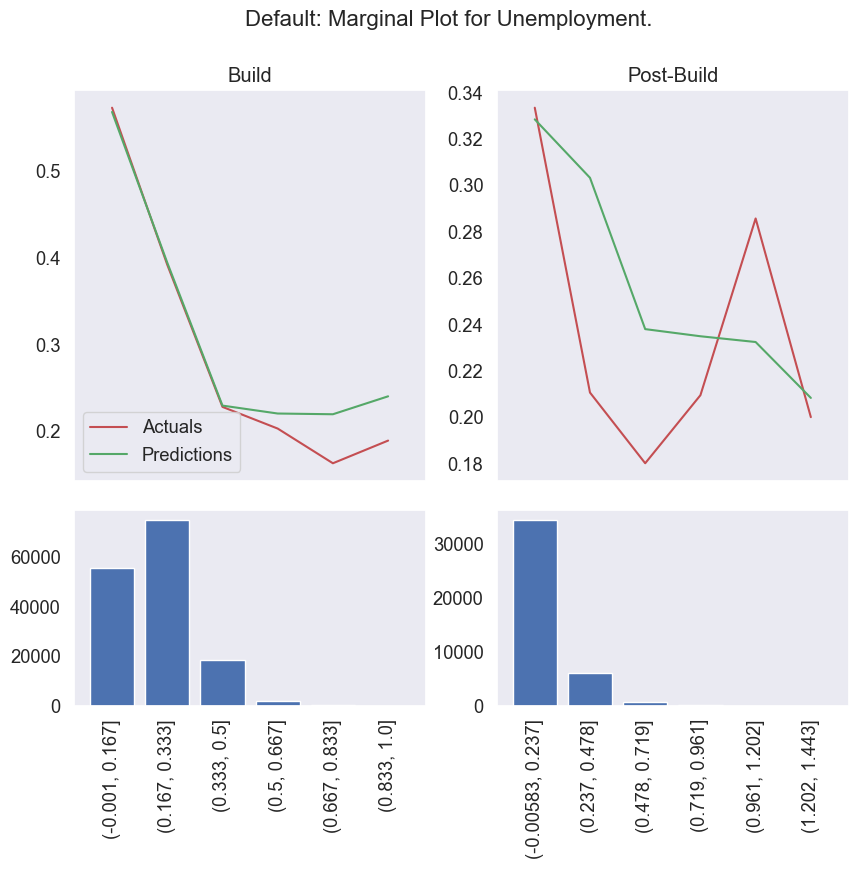

In [186]:
for i,j in zip(x_var_list, x_var_name):
    marginal_plots(df_ins_4plot_xgb,df_oot_4plot_xgb,i,j,y_var,y_pred,bin_size)

In [187]:
df_oot_4plot_xgb['Vintage'].astype(float)

0        2008.0
1        2003.0
2        2005.0
3        2003.0
4        2001.0
          ...  
41587    2009.0
41588    2015.0
41589    2002.0
41590    2010.0
41591    2010.0
Name: Vintage, Length: 41592, dtype: float64

In [188]:
df_ins_4plot_xgb['target']

0         0
1         0
2         0
3         1
4         0
         ..
151593    0
151594    0
151595    1
151596    0
151597    0
Name: target, Length: 151598, dtype: int64

# Save the train - test set

In [189]:
## save the datasets for explainability notebook

df_ins1.to_pickle(os.path.join(data_path, "df_ins.pkl"))

In [190]:
df_oot1.to_pickle(os.path.join(data_path, "df_oot.pkl"))

In [191]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

When you use the get_dummies function in Pandas to convert categorical variables into dummy/indicator variables, you might wonder why it's common practice to drop one of the dummy columns. This is known as "dummy variable trap" or "dummy variable encoding," and it's done to avoid multicollinearity in certain statistical models, especially in linear regression.

Here's why dropping one dummy variable is often necessary:

Avoiding Multicollinearity: When you convert a categorical variable with N unique categories into N-1 dummy variables, you eliminate one level of redundancy. In a linear regression context, if you include all N dummy variables, they become perfectly multicollinear. This multicollinearity can cause issues when estimating coefficients because the linear regression model can't distinguish the individual effects of each category. It may also lead to unstable or non-unique solutions

Note that for logistic regression we need to drop the base variable; The reason for dropping the base category in logistic regression is to avoid perfect multicollinearity, which occurs when one of the predictor variables can be linearly predicted from the others. Perfect multicollinearity leads to unreliable parameter estimates, unstable variance-covariance matrix, and other numerical issues. By dropping one category, you remove the multicollinearity issue and create a reference point to interpret the regression coefficients. This is known as the "reference category" approach. The interpretation of the coefficients becomes the difference between the odds of the event occurring for that category and the odds for the reference category.

In [192]:
df_models1.head()

channel  orig_rate  orig_upb  orig_term  loan_age      oltv     ocltv  \
0       R      7.625   49000.0      180.0      55.0 -0.325064 -0.381694   
1       R      8.000  162000.0      360.0       5.0  0.373707  0.305616   
2       C      7.750  104000.0      360.0      56.0  0.373707  0.305616   
3       R      8.250   38000.0      240.0     131.0  0.373707  0.305616   
4       R      8.000   56000.0      360.0     183.0  0.010075 -0.052463   

   num_bo   dti  cscore_b  ...  high_balance_loan_indicator cscore_min  \
0     2.0  36.0  0.514034  ...                            N      695.0   
1     1.0  43.0 -0.911853  ...                            N      670.0   
2     1.0  13.0  0.609400  ...                            N      762.0   
3     1.0  30.0  0.476319  ...                            N      755.0   
4     1.0  62.0 -0.783698  ...                            N      679.0   

        orig_val Vintage  Default 12M Change  36M Change  60M Change unemp  \
0   70000.000000    1999        0   0.040592    0.175037      0.3326   8.5   
1  202500.000000    1999        0   0.073123    0.169940      0.2102   3.0   
2  130000.000000    1999        0   0.040133    0.137793      0.2920   2.8   
3   47500.000000    1999        1   0.010072    0.095395      0.1787   4.1   
4   74666.666667    1999        0   0.027083    0.082907      0.1063   6.4   

  bad_vintage  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 29 columns]

In [193]:
df_models1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        193190 non-null  object 
 1   orig_rate                      193190 non-null  float64
 2   orig_upb                       193190 non-null  float64
 3   orig_term                      193190 non-null  float64
 4   loan_age                       193190 non-null  float64
 5   oltv                           193190 non-null  float64
 6   ocltv                          193190 non-null  float64
 7   num_bo                         193190 non-null  float64
 8   dti                            193190 non-null  float64
 9   cscore_b                       193190 non-null  float64
 10  cscore_c                       193190 non-null  float64
 11  first_flag                     193190 non-null  object 
 12  purpose                       

## Modeling (Logistic Regression)

In [194]:
df_models1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        193190 non-null  object 
 1   orig_rate                      193190 non-null  float64
 2   orig_upb                       193190 non-null  float64
 3   orig_term                      193190 non-null  float64
 4   loan_age                       193190 non-null  float64
 5   oltv                           193190 non-null  float64
 6   ocltv                          193190 non-null  float64
 7   num_bo                         193190 non-null  float64
 8   dti                            193190 non-null  float64
 9   cscore_b                       193190 non-null  float64
 10  cscore_c                       193190 non-null  float64
 11  first_flag                     193190 non-null  object 
 12  purpose                       

### Encoding

In [195]:
df_model_log = pd.get_dummies(df_models1, drop_first=True,columns=cat_vars).astype(float) #drop_first is impt for get_dumm
df_model_log.drop(['Vintage'],axis=1,inplace=True)

In [196]:
df_model_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193190 entries, 0 to 193189
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   orig_rate                        193190 non-null  float64
 1   orig_upb                         193190 non-null  float64
 2   orig_term                        193190 non-null  float64
 3   loan_age                         193190 non-null  float64
 4   oltv                             193190 non-null  float64
 5   ocltv                            193190 non-null  float64
 6   dti                              193190 non-null  float64
 7   cscore_b                         193190 non-null  float64
 8   cscore_c                         193190 non-null  float64
 9   mi_pct                           193190 non-null  float64
 10  cscore_min                       193190 non-null  float64
 11  orig_val                         193190 non-null  float64
 12  De

In [197]:
missing_cols=df_model_log.columns[df_model_log.isnull().any()]

In [198]:
df_model_log[missing_cols].loc[df_model_log.index[np.isnan(df_model_log).any(axis= 1)]]

Empty DataFrame
Columns: []
Index: []

In [199]:
for i in missing_cols:
    df_model_log[i]=df_model_log[i].fillna(df_model_log[i].mean())
    print(i)

In [200]:
df_model_log[missing_cols].loc[df_model_log.index[np.isnan(df_model_log).any(axis= 1)]]

Empty DataFrame
Columns: []
Index: []

In [201]:
df_model_log.isnull().sum()

orig_rate                          0
orig_upb                           0
orig_term                          0
loan_age                           0
oltv                               0
ocltv                              0
dti                                0
cscore_b                           0
cscore_c                           0
mi_pct                             0
cscore_min                         0
orig_val                           0
Default                            0
12M Change                         0
36M Change                         0
60M Change                         0
unemp                              0
bad_vintage                        0
channel_C                          0
channel_R                          0
purpose_P                          0
purpose_R                          0
purpose_U                          0
prop_CP                            0
prop_MH                            0
prop_PU                            0
prop_SF                            0
n

In [202]:
x = df_model_log[num_vars].values
x

array([[7.62500000e+00, 4.90000000e+04, 7.00000000e+04, ...,
        3.32600000e-01, 8.50000000e+00, 0.00000000e+00],
       [8.00000000e+00, 1.62000000e+05, 2.02500000e+05, ...,
        2.10200000e-01, 3.00000000e+00, 0.00000000e+00],
       [7.75000000e+00, 1.04000000e+05, 1.30000000e+05, ...,
        2.92000000e-01, 2.80000000e+00, 0.00000000e+00],
       ...,
       [2.62500000e+00, 5.48000000e+05, 8.69841270e+05, ...,
        2.47165409e-01, 6.60000000e+00, 0.00000000e+00],
       [2.37500000e+00, 1.76000000e+05, 7.33333333e+05, ...,
        3.60218546e-01, 7.40000000e+00, 0.00000000e+00],
       [3.50000000e+00, 1.48000000e+05, 1.94736842e+05, ...,
        3.35451330e-01, 8.50000000e+00, 0.00000000e+00]])

### Scaling  
**Standard Scaling**

_**Why do we use Standard Scaling ?**_
- Machine learning and numerical optimization, numerical precision is essential for ensuring that the algorithms converge to the correct solutions and produce reliable results. Centering the data or using proper scaling techniques, as mentioned in the previous answer about logistic regression, can help improve numerical precision by reducing the risk of large values that might cause numerical instability during calculations

In [203]:
### there are different types of scalers but for interpretability purposes I will center the numerical variables at their mean


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

x = df_model_log[num_vars].values #returns a numpy array
print(dict(zip(num_vars,x.mean(axis=0))))
print(dict(zip(num_vars,x.std(axis=0))))
scaled_mean=x.mean(axis=0)
scaled_std=x.std(axis=0)
"""
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_model_log = pd.DataFrame(x_scaled, index = df_model_log.index, columns = df_model_log.columns)
"""
"""power_trans=preprocessing.power_transform(x, standardize=True, copy=True)
#x_power_trans=power_trans.fit_transform(x)
df_model_log_num=pd.DataFrame(power_trans, index = df_model_log.index, columns = num_vars)"""

scaler = StandardScaler()

# Fit and transform the data
centered_data = scaler.fit_transform(x)

# The centered data will have a mean close to zero
print(np.mean(centered_data))
# Output: [0.]
df_model_log_num=pd.DataFrame(centered_data, index = df_model_log.index, columns = num_vars)

{'orig_rate': 5.334404032299809, 'orig_upb': 187585.99306382317, 'orig_val': 272176.21697354864, 'orig_term': 319.1532998602412, 'loan_age': 54.15763755887986, 'oltv': 4.2193417178114135e-16, 'ocltv': -1.171058579978342e-16, 'dti': 35.82498576530876, 'cscore_b': 5.649327823011098e-17, 'cscore_c': -3.295441230089807e-17, 'cscore_min': 717.3751229359698, 'mi_pct': 24.750867022102593, '12M Change': 0.047698909190777045, '36M Change': 0.178764847930729, '60M Change': 0.3136866421017028, 'unemp': 5.823961643977432, 'bad_vintage': 0.20539365391583414}
{'orig_rate': 1.2705956241409893, 'orig_upb': 108091.04933532409, 'orig_val': 174099.67988920351, 'orig_term': 75.03199765597805, 'loan_age': 42.04217890660004, 'oltv': 1.0, 'ocltv': 0.9999999999999999, 'dti': 11.627349502388782, 'cscore_b': 1.0, 'cscore_c': 1.0, 'cscore_min': 61.383052875310234, 'mi_pct': 3.3913788552368174, '12M Change': 0.08047358324247847, '36M Change': 0.2214482789399453, '60M Change': 0.3453562459173132, 'unemp': 2.462304

we take  the mean of centered data becaouse we want make  0.

In [204]:
df_model_log_num

orig_rate  orig_upb  orig_val  orig_term  loan_age      oltv  \
0        1.802773 -1.282123 -1.161267  -1.854586  0.020036 -0.325064   
1        2.097911 -0.236708 -0.400209   0.544390 -1.169246  0.373707   
2        1.901152 -0.773292 -0.816637   0.544390  0.043822  0.373707   
3        2.294669 -1.383889 -1.290503  -1.054927  1.827745  0.373707   
4        2.097911 -1.217363 -1.134462   0.544390  3.064598  0.010075   
...           ...       ...       ...        ...       ...       ...   
193185  -2.034010  1.243526  2.840272  -1.854586 -1.193031 -1.698428   
193186  -2.034797 -0.042427  0.673094   0.544390 -1.216817 -1.513495   
193187  -2.132389  3.334356  3.432890   0.544390 -1.264388 -0.747274   
193188  -2.329147 -0.107187  2.648811  -1.854586 -1.169246 -2.163881   
193189  -1.443736 -0.366228 -0.444799   0.544390 -1.121674  0.080507   

           ocltv       dti  cscore_b  cscore_c  cscore_min    mi_pct  \
0      -0.381694  0.015052  0.514034 -0.564382   -0.364516  0.073461   
1       0.305616  0.617081 -0.911853 -0.927482   -0.771795  0.073461   
2       0.305616 -1.963043  0.609400  0.586853    0.726990  0.073461   
3       0.305616 -0.500973  0.476319  0.453674    0.612952  0.073461   
4      -0.052463  2.251159 -0.783698 -0.800675   -0.625175  0.073461   
...          ...       ...       ...       ...         ...       ...   
193185 -1.719111 -1.016998  0.476319  1.701272    0.612952  0.073461   
193186 -1.540588 -0.156956  0.094940  0.072695    0.270838  0.073461   
193187 -0.795178  0.617081  0.904881  0.882963    0.971357  0.073461   
193188 -2.163951  1.219110  1.696108  1.322815    1.313471  0.073461   
193189  0.016828  0.273064 -0.725381 -0.742918   -0.560010  0.073461   

        12M Change  36M Change  60M Change     unemp  bad_vintage  
0        -0.088315   -0.016836    0.054765  1.086802    -0.508414  
1         0.315929   -0.039852   -0.299652 -1.146877    -0.508414  
2        -0.094018   -0.185017   -0.062795 -1.228102    -0.508414  
3        -0.467574   -0.376477   -0.390862 -0.700141    -0.508414  
4        -0.256188   -0.432869   -0.600501  0.233943    -0.508414  
...            ...         ...         ...       ...          ...  
193185    0.172775   -0.123007    0.155550  1.777212    -0.508414  
193186    0.393937    0.139109    0.206550 -0.294018    -0.508414  
193187    0.131063   -0.169994   -0.192616  0.315167    -0.508414  
193188    0.633694   -0.000361    0.134736  0.640066    -0.508414  
193189    0.294782    0.006848    0.063021  1.086802    -0.508414  

[193190 rows x 17 columns]

In [205]:
### since I have only centered numeric features I need to reconstitute the model dataset

l_cat=list(df_model_log.columns)
#l_cat.remove(num_vars)
l_cat = [i for i in l_cat if i not in num_vars]
l_cat.remove('Default')

In [206]:
l_cat

['channel_C',
 'channel_R',
 'purpose_P',
 'purpose_R',
 'purpose_U',
 'prop_CP',
 'prop_MH',
 'prop_PU',
 'prop_SF',
 'no_units_2.0',
 'occ_stat_P',
 'occ_stat_S',
 'mi_type_2.0',
 'mi_type_3.0',
 'num_bo_2.0',
 'first_flag_Y',
 'relocation_mortgage_indicator_Y',
 'high_balance_loan_indicator_Y']

- **Concantanation numeric and cat val**

In [207]:
df_model_log = pd.concat([df_model_log_num, df_model_log[l_cat],df_model_log['Default']], axis=1)

In [208]:
### the variables below created issues with logistic regression. Therefore I dropped them
### TO DO: create a variable for num_bo so I can combine any number of borrowers greater than 1 into one category

l=list(df_model_log.columns)
l.remove('Default')
#l.remove('cscore_c')
#l.remove('cscore_min')
#l.remove('ocltv')
#l.remove('mi_type_3.0')
#l.remove('num_bo_5.0')
#l.remove('num_bo_6.0')
#l.remove('num_bo_7.0')
#l.remove('high_balance_loan_indicator')
#l.remove('Vintage')

# Splitting Data Set
## df_oot (test-set)

In [209]:
type(df_model_log)

pandas.core.frame.DataFrame

In [210]:
df_model_log.shape

(193190, 36)

In [211]:
df_model_log.columns

Index(['orig_rate', 'orig_upb', 'orig_val', 'orig_term', 'loan_age', 'oltv',
       'ocltv', 'dti', 'cscore_b', 'cscore_c', 'cscore_min', 'mi_pct',
       '12M Change', '36M Change', '60M Change', 'unemp', 'bad_vintage',
       'channel_C', 'channel_R', 'purpose_P', 'purpose_R', 'purpose_U',
       'prop_CP', 'prop_MH', 'prop_PU', 'prop_SF', 'no_units_2.0',
       'occ_stat_P', 'occ_stat_S', 'mi_type_2.0', 'mi_type_3.0', 'num_bo_2.0',
       'first_flag_Y', 'relocation_mortgage_indicator_Y',
       'high_balance_loan_indicator_Y', 'Default'],
      dtype='object')

In [213]:
len(oot_index_names)

41592

In [214]:
df_oot_log=df_model_log.loc[oot_index_names]
X_oot_log=df_oot_log[l] 
Y_oot_log=df_oot_log["Default"]

In [215]:
X_oot_log

orig_rate  orig_upb  orig_val  orig_term  loan_age      oltv  \
151598  -0.361566 -0.292217 -0.443288   0.544390  0.210321  0.373707   
151599  -0.271057 -0.828801 -0.901105   0.544390 -0.598390  0.766270   
151600  -0.459945 -1.272871 -1.204346   0.544390 -0.574605  0.373707   
151601  -0.853461  0.410894 -0.160630   0.544390  0.614677  1.639852   
151602  -0.558324 -0.662275 -0.861983   0.544390  0.281678  1.639852   
...           ...       ...       ...        ...       ...       ...   
193185  -2.034010  1.243526  2.840272  -1.854586 -1.193031 -1.698428   
193186  -2.034797 -0.042427  0.673094   0.544390 -1.216817 -1.513495   
193187  -2.132389  3.334356  3.432890   0.544390 -1.264388 -0.747274   
193188  -2.329147 -0.107187  2.648811  -1.854586 -1.169246 -2.163881   
193189  -1.443736 -0.366228 -0.444799   0.544390 -1.121674  0.080507   

           ocltv       dti  cscore_b  cscore_c  ...  prop_SF  no_units_2.0  \
151598  0.305616  0.015052 -1.383589  0.055233  ...      1.0           0.0   
151599  0.693058  0.617081  0.237109  0.397556  ...      1.0           0.0   
151600  0.305616 -1.791035 -0.591058 -0.609764  ...      0.0           0.0   
151601  1.557970  0.789089  1.006552  0.644897  ...      1.0           0.0   
151602  1.557970 -0.070952 -1.479882 -0.800675  ...      1.0           0.0   
...          ...       ...       ...       ...  ...      ...           ...   
193185 -1.719111 -1.016998  0.476319  1.701272  ...      1.0           0.0   
193186 -1.540588 -0.156956  0.094940  0.072695  ...      1.0           0.0   
193187 -0.795178  0.617081  0.904881  0.882963  ...      1.0           0.0   
193188 -2.163951  1.219110  1.696108  1.322815  ...      0.0           0.0   
193189  0.016828  0.273064 -0.725381 -0.742918  ...      1.0           0.0   

        occ_stat_P  occ_stat_S  mi_type_2.0  mi_type_3.0  num_bo_2.0  \
151598         1.0         0.0          0.0          0.0         1.0   
151599         1.0         0.0          0.0          0.0         1.0   
151600         1.0         0.0          0.0          0.0         0.0   
151601         1.0         0.0          0.0          0.0         1.0   
151602         1.0         0.0          0.0          0.0         1.0   
...            ...         ...          ...          ...         ...   
193185         0.0         0.0          0.0          0.0         1.0   
193186         1.0         0.0          0.0          0.0         0.0   
193187         1.0         0.0          0.0          0.0         0.0   
193188         1.0         0.0          0.0          0.0         1.0   
193189         1.0         0.0          0.0          0.0         0.0   

        first_flag_Y  relocation_mortgage_indicator_Y  \
151598           0.0                              0.0   
151599           0.0                              0.0   
151600           1.0                              0.0   
151601           0.0                              0.0   
151602           1.0                              0.0   
...              ...                              ...   
193185           0.0                              0.0   
193186           0.0                              0.0   
193187           0.0                              0.0   
193188           0.0                              0.0   
193189           0.0                              0.0   

        high_balance_loan_indicator_Y  
151598                            0.0  
151599                            0.0  
151600                            0.0  
151601                            0.0  
151602                            0.0  
...                               ...  
193185                            0.0  
193186                            0.0  
193187                            0.0  
193188                            0.0  
193189                            0.0  

[41592 rows x 35 columns]

In [216]:
X_oot_log.shape

(41592, 35)

## df_ins Data Set

In [217]:
df_ins_log=df_model_log.drop(oot_index_names)
X_ins_log=df_ins_log[l]
Y_ins_log=df_ins_log["Default"]

In [218]:
X_ins_log.shape

(151598, 35)

In [219]:
Y_ins_log.value_counts(dropna=False) #dropna=False it counts NaN

Default
0.0    85663
1.0    65935
Name: count, dtype: int64

- After frac the rate

**A**    114272  
**P**     85598  
**D**    78918

In [220]:
78918/114272  #--> D/A

0.6906153738448614

### Intercept adjustment calculation

In [221]:
## Lets calculate intercept adjustment
Original_Data_Actives=2293375111 # this data is frim aws original active numbers
Original_Data_Defaults=17966047
#Original_Data_Event_Rate:
p1=Original_Data_Defaults/(Original_Data_Defaults+Original_Data_Actives)
print(p1)
Sampled_Data_Actives=114272
Sampled_Data_Defaults=78918
#Sampled_Data_Event_Rate:
r1=Sampled_Data_Defaults/(Sampled_Data_Defaults+Sampled_Data_Actives)
print(r1)
#log[(r1*(1-p1)) / ((1-r1)*p1)],
Intercept_Adjustment=np.log((r1*(1-p1)) / ((1-r1)*p1))

Intercept_Adjustment

0.007772996616192304
0.40849940473109375


4.479123927545688

- This adjustment is for only LOgistic Regression
- adjustment is approximately 4.48. This means that when you're building a logistic regression model on your sampled data, you should adjust the intercept (constant term) by adding this value to it.  
- Effect on the Model: The positive value of the intercept adjustment suggests that your sampled data has a higher event rate (probability of defaults) than your original data. By adding this adjustment to the intercept, you are essentially shifting the logistic regression model to better align with the event rate observed in the sampled data.

In [222]:
offset = [ Intercept_Adjustment for i in range(len(X_ins_log.index))]

- Adding the intercept term allows the regression model to capture the baseline prediction when all the independent variables are equal to zero. In some cases, this is necessary for the model to make meaningful predictions, even if your features can never be exactly zero.

- **Y=β 
0
​
 +β 
1
​
 X 
1
​
 +β 
2
​
 X 
2
​
 +…+β 
p
​
 X 
p
​**
 


Y is the target variable.
 
β0
is the intercept term (constant- intercept).

β 
1
​
 ,β 
2
​
 ,…,β 
p
​
  are the coefficients for the independent variables.
 

X 
1
​
 ,X 
2
​
 ,…,X 
p
​
 are features.   
- Adding the intercept term allows the regression model to capture the baseline prediction when all the independent variables are equal to zero. In some cases, this is necessary for the model to make meaningful predictions, even if your features can never be exactly zero.

In [223]:
X_ins_log= sm.add_constant(X_ins_log)
final_features_log=list(X_ins_log.columns)
# Instantiate a binomial family model with the default link function.
#log_model = sm.GLM(Y_ins_log, X_ins_log, family=sm.families.Binomial(),offset=offset)
log_model = sm.GLM(Y_ins_log, X_ins_log, family=sm.families.Binomial())

In [224]:
X_ins_log.shape, len(final_features_log)

((151598, 36), 36)

In [225]:
log_results = log_model.fit()

print(log_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:               151598
Model:                            GLM   Df Residuals:                   151562
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63147.
Date:                Thu, 19 Oct 2023   Deviance:                   1.2629e+05
Time:                        12:52:25   Pearson chi2:                 1.63e+05
No. Iterations:                    19   Pseudo R-squ. (CS):             0.4150
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [226]:
Y_ins_log.dtype

dtype('float64')

**target:**  
**A**    114272  
**P**     85598  
**D**     78918

In [227]:
coeff=log_results.params
coeff

const                               0.176518
orig_rate                           0.176664
orig_upb                            0.469635
orig_val                           -0.346417
orig_term                           0.258386
loan_age                            0.873696
oltv                               -0.007239
ocltv                               0.427591
dti                                 0.218114
cscore_b                           -0.355634
cscore_c                           -0.241554
cscore_min                         -0.206058
mi_pct                              0.001618
12M Change                         -0.003413
36M Change                         -0.284780
60M Change                          0.614546
unemp                              -0.007341
bad_vintage                         0.450057
channel_C                          -0.139881
channel_R                          -0.261182
purpose_P                          -0.522936
purpose_R                          -0.287855
purpose_U 

In [228]:
coeff_new=coeff.drop('const').to_frame(name='coef')

In [229]:
coeff_new

coef
orig_rate                         0.176664
orig_upb                          0.469635
orig_val                         -0.346417
orig_term                         0.258386
loan_age                          0.873696
oltv                             -0.007239
ocltv                             0.427591
dti                               0.218114
cscore_b                         -0.355634
cscore_c                         -0.241554
cscore_min                       -0.206058
mi_pct                            0.001618
12M Change                       -0.003413
36M Change                       -0.284780
60M Change                        0.614546
unemp                            -0.007341
bad_vintage                       0.450057
channel_C                        -0.139881
channel_R                        -0.261182
purpose_P                        -0.522936
purpose_R                        -0.287855
purpose_U                        -0.951145
prop_CP                          -0.503391
prop_MH                           0.327478
prop_PU                          -0.000625
prop_SF                           0.034328
no_units_2.0                      0.024164
occ_stat_P                       -0.327748
occ_stat_S                       -0.327996
mi_type_2.0                       0.210822
mi_type_3.0                     -19.497209
num_bo_2.0                       -0.660948
first_flag_Y                     -0.033619
relocation_mortgage_indicator_Y  -0.653028
high_balance_loan_indicator_Y     0.460727

In [230]:
coeff_new['feat']=coeff_new.index

In [231]:
coeff_new

coef                             feat
orig_rate                         0.176664                        orig_rate
orig_upb                          0.469635                         orig_upb
orig_val                         -0.346417                         orig_val
orig_term                         0.258386                        orig_term
loan_age                          0.873696                         loan_age
oltv                             -0.007239                             oltv
ocltv                             0.427591                            ocltv
dti                               0.218114                              dti
cscore_b                         -0.355634                         cscore_b
cscore_c                         -0.241554                         cscore_c
cscore_min                       -0.206058                       cscore_min
mi_pct                            0.001618                           mi_pct
12M Change                       -0.003413                       12M Change
36M Change                       -0.284780                       36M Change
60M Change                        0.614546                       60M Change
unemp                            -0.007341                            unemp
bad_vintage                       0.450057                      bad_vintage
channel_C                        -0.139881                        channel_C
channel_R                        -0.261182                        channel_R
purpose_P                        -0.522936                        purpose_P
purpose_R                        -0.287855                        purpose_R
purpose_U                        -0.951145                        purpose_U
prop_CP                          -0.503391                          prop_CP
prop_MH                           0.327478                          prop_MH
prop_PU                          -0.000625                          prop_PU
prop_SF                           0.034328                          prop_SF
no_units_2.0                      0.024164                     no_units_2.0
occ_stat_P                       -0.327748                       occ_stat_P
occ_stat_S                       -0.327996                       occ_stat_S
mi_type_2.0                       0.210822                      mi_type_2.0
mi_type_3.0                     -19.497209                      mi_type_3.0
num_bo_2.0                       -0.660948                       num_bo_2.0
first_flag_Y                     -0.033619                     first_flag_Y
relocation_mortgage_indicator_Y  -0.653028  relocation_mortgage_indicator_Y
high_balance_loan_indicator_Y     0.460727    high_balance_loan_indicator_Y

In [232]:
coeff_new.reset_index(inplace=True)

In [233]:
coeff_new.drop('index',inplace=True,axis=1)

In [234]:
coeff_new['feat']

0                           orig_rate
1                            orig_upb
2                            orig_val
3                           orig_term
4                            loan_age
5                                oltv
6                               ocltv
7                                 dti
8                            cscore_b
9                            cscore_c
10                         cscore_min
11                             mi_pct
12                         12M Change
13                         36M Change
14                         60M Change
15                              unemp
16                        bad_vintage
17                          channel_C
18                          channel_R
19                          purpose_P
20                          purpose_R
21                          purpose_U
22                            prop_CP
23                            prop_MH
24                            prop_PU
25                            prop_SF
26          

In [235]:
coeff_new_all=pd.concat([coeff_new,pd.Series(scaled_mean),pd.DataFrame(scaled_std)],axis=1).set_axis(labels=['coeff','feature','scaled_mean','scaled_std'],axis=1)

In [236]:
coeff_new_all

coeff                          feature   scaled_mean     scaled_std
0    0.176664                        orig_rate  5.334404e+00       1.270596
1    0.469635                         orig_upb  1.875860e+05  108091.049335
2   -0.346417                         orig_val  2.721762e+05  174099.679889
3    0.258386                        orig_term  3.191533e+02      75.031998
4    0.873696                         loan_age  5.415764e+01      42.042179
5   -0.007239                             oltv  4.219342e-16       1.000000
6    0.427591                            ocltv -1.171059e-16       1.000000
7    0.218114                              dti  3.582499e+01      11.627350
8   -0.355634                         cscore_b  5.649328e-17       1.000000
9   -0.241554                         cscore_c -3.295441e-17       1.000000
10  -0.206058                       cscore_min  7.173751e+02      61.383053
11   0.001618                           mi_pct  2.475087e+01       3.391379
12  -0.003413                       12M Change  4.769891e-02       0.080474
13  -0.284780                       36M Change  1.787648e-01       0.221448
14   0.614546                       60M Change  3.136866e-01       0.345356
15  -0.007341                            unemp  5.823962e+00       2.462305
16   0.450057                      bad_vintage  2.053937e-01       0.403989
17  -0.139881                        channel_C           NaN            NaN
18  -0.261182                        channel_R           NaN            NaN
19  -0.522936                        purpose_P           NaN            NaN
20  -0.287855                        purpose_R           NaN            NaN
21  -0.951145                        purpose_U           NaN            NaN
22  -0.503391                          prop_CP           NaN            NaN
23   0.327478                          prop_MH           NaN            NaN
24  -0.000625                          prop_PU           NaN            NaN
25   0.034328                          prop_SF           NaN            NaN
26   0.024164                     no_units_2.0           NaN            NaN
27  -0.327748                       occ_stat_P           NaN            NaN
28  -0.327996                       occ_stat_S           NaN            NaN
29   0.210822                      mi_type_2.0           NaN            NaN
30 -19.497209                      mi_type_3.0           NaN            NaN
31  -0.660948                       num_bo_2.0           NaN            NaN
32  -0.033619                     first_flag_Y           NaN            NaN
33  -0.653028  relocation_mortgage_indicator_Y           NaN            NaN
34   0.460727    high_balance_loan_indicator_Y           NaN            NaN

- The exponent of the division of 'coeff' by 'scaled_std' and assigns the result to the 'Beta_adj' column in the coeff_new_all DataFrame. This transformation is often used in the context of logistic regression or other statistical models to transform model coefficients into a more interpretable form, which can be especially useful for making predictions or understanding the impact of features.

In [237]:
coeff_new_all['Beta_adj']=np.exp(coeff_new_all['coeff']/coeff_new_all['scaled_std'])

In [238]:
coeff_new_all

coeff                          feature   scaled_mean     scaled_std  \
0    0.176664                        orig_rate  5.334404e+00       1.270596   
1    0.469635                         orig_upb  1.875860e+05  108091.049335   
2   -0.346417                         orig_val  2.721762e+05  174099.679889   
3    0.258386                        orig_term  3.191533e+02      75.031998   
4    0.873696                         loan_age  5.415764e+01      42.042179   
5   -0.007239                             oltv  4.219342e-16       1.000000   
6    0.427591                            ocltv -1.171059e-16       1.000000   
7    0.218114                              dti  3.582499e+01      11.627350   
8   -0.355634                         cscore_b  5.649328e-17       1.000000   
9   -0.241554                         cscore_c -3.295441e-17       1.000000   
10  -0.206058                       cscore_min  7.173751e+02      61.383053   
11   0.001618                           mi_pct  2.475087e+01       3.391379   
12  -0.003413                       12M Change  4.769891e-02       0.080474   
13  -0.284780                       36M Change  1.787648e-01       0.221448   
14   0.614546                       60M Change  3.136866e-01       0.345356   
15  -0.007341                            unemp  5.823962e+00       2.462305   
16   0.450057                      bad_vintage  2.053937e-01       0.403989   
17  -0.139881                        channel_C           NaN            NaN   
18  -0.261182                        channel_R           NaN            NaN   
19  -0.522936                        purpose_P           NaN            NaN   
20  -0.287855                        purpose_R           NaN            NaN   
21  -0.951145                        purpose_U           NaN            NaN   
22  -0.503391                          prop_CP           NaN            NaN   
23   0.327478                          prop_MH           NaN            NaN   
24  -0.000625                          prop_PU           NaN            NaN   
25   0.034328                          prop_SF           NaN            NaN   
26   0.024164                     no_units_2.0           NaN            NaN   
27  -0.327748                       occ_stat_P           NaN            NaN   
28  -0.327996                       occ_stat_S           NaN            NaN   
29   0.210822                      mi_type_2.0           NaN            NaN   
30 -19.497209                      mi_type_3.0           NaN            NaN   
31  -0.660948                       num_bo_2.0           NaN            NaN   
32  -0.033619                     first_flag_Y           NaN            NaN   
33  -0.653028  relocation_mortgage_indicator_Y           NaN            NaN   
34   0.460727    high_balance_loan_indicator_Y           NaN            NaN   

    Beta_adj  
0   1.149170  
1   1.000004  
2   0.999998  
3   1.003450  
4   1.020999  
5   0.992788  
6   1.533558  
7   1.018936  
8   0.700729  
9   0.785407  
10  0.996649  
11  1.000477  
12  0.958473  
13  0.276378  
14  5.926622  
15  0.997023  
16  3.046622  
17       NaN  
18       NaN  
19       NaN  
20       NaN  
21       NaN  
22       NaN  
23       NaN  
24       NaN  
25       NaN  
26       NaN  
27       NaN  
28       NaN  
29       NaN  
30       NaN  
31       NaN  
32       NaN  
33       NaN  
34       NaN

In [240]:
df_models1.loc[oot_index_names].isnull().sum()

channel                          0
orig_rate                        0
orig_upb                         0
orig_term                        0
loan_age                         0
oltv                             0
ocltv                            0
num_bo                           0
dti                              0
cscore_b                         0
cscore_c                         0
first_flag                       0
purpose                          0
prop                             0
no_units                         0
occ_stat                         0
mi_pct                           0
mi_type                          0
relocation_mortgage_indicator    0
high_balance_loan_indicator      0
cscore_min                       0
orig_val                         0
Vintage                          0
Default                          0
12M Change                       0
36M Change                       0
60M Change                       0
unemp                            0
bad_vintage         

In [241]:
df_models1.loc[oot_index_names]

channel  orig_rate  orig_upb  orig_term  loan_age      oltv     ocltv  \
151598       C      4.875  156000.0      360.0      63.0  0.373707  0.305616   
151599       R      4.990   98000.0      360.0      29.0  0.766270  0.693058   
151600       R      4.750   50000.0      360.0      30.0  0.373707  0.305616   
151601       R      4.250  232000.0      360.0      80.0  1.639852  1.557970   
151602       R      4.625  116000.0      360.0      66.0  1.639852  1.557970   
...        ...        ...       ...        ...       ...       ...       ...   
193185       B      2.750  322000.0      180.0       4.0 -1.698428 -1.719111   
193186       C      2.749  183000.0      360.0       3.0 -1.513495 -1.540588   
193187       C      2.625  548000.0      360.0       1.0 -0.747274 -0.795178   
193188       R      2.375  176000.0      180.0       5.0 -2.163881 -2.163951   
193189       R      3.500  148000.0      360.0       7.0  0.080507  0.016828   

        num_bo   dti  cscore_b  ...  high_balance_loan_indicator cscore_min  \
151598     2.0  36.0 -1.383589  ...                            N      634.0   
151599     2.0  43.0  0.237109  ...                            N      742.0   
151600     1.0  15.0 -0.591058  ...                            N      692.0   
151601     2.0  45.0  1.006552  ...                            N      765.0   
151602     2.0  35.0 -1.479882  ...                            N      626.0   
...        ...   ...       ...  ...                          ...        ...   
193185     2.0  24.0  0.476319  ...                            N      755.0   
193186     1.0  34.0  0.094940  ...                            N      734.0   
193187     1.0  43.0  0.904881  ...                            N      777.0   
193188     2.0  50.0  1.696108  ...                            N      798.0   
193189     1.0  39.0 -0.725381  ...                            N      683.0   

             orig_val Vintage  Default 12M Change  36M Change  60M Change  \
151598  195000.000000    2014        0  -0.009545    0.012961    0.001520   
151599  115294.117647    2014        0   0.008641   -0.032914   -0.100877   
151600   62500.000000    2014        0  -0.002961   -0.023313   -0.076469   
151601  244210.526316    2014        1   0.059517    0.118309   -0.013080   
151602  122105.263158    2014        0   0.025805    0.054988    0.029527   
...               ...     ...      ...        ...         ...         ...   
193185  766666.666667    2021        0   0.061603    0.151525    0.367407   
193186  389361.702128    2021        0   0.079400    0.209570    0.385020   
193187  869841.269841    2021        0   0.058246    0.141120    0.247165   
193188  733333.333333    2021        0   0.098695    0.178685    0.360219   
193189  194736.842105    2021        0   0.071421    0.180281    0.335451   

       unemp bad_vintage  
151598   7.1           0  
151599   6.2           0  
151600   6.9           0  
151601   4.1           0  
151602   5.1           0  
...      ...         ...  
193185  10.2           0  
193186   5.1           0  
193187   6.6           0  
193188   7.4           0  
193189   8.5           0  

[41592 rows x 29 columns]

# Marginal Plot after Intercept Adjustment  
- Marginal Plot is the simpleiest explanation methos that describes how model outputs relate to a feature when all the observations take the actual feature values

In [242]:
ypred_log = pd.DataFrame(log_results.predict(X_ins_log.values),columns=['pred'])

df1=pd.DataFrame(X_ins_log.values,columns=final_features_log)
df2=pd.DataFrame(Y_ins_log.values,columns =['target'])
df3 =df_models.drop(oot_index_names)
df_ins_4plot=pd.concat([df1,df2,df3[['Vintage']],ypred_log],axis=1)

In [243]:
X_ins_log.head()

const  orig_rate  orig_upb  orig_val  orig_term  loan_age      oltv  \
0    1.0   1.802773 -1.282123 -1.161267  -1.854586  0.020036 -0.325064   
1    1.0   2.097911 -0.236708 -0.400209   0.544390 -1.169246  0.373707   
2    1.0   1.901152 -0.773292 -0.816637   0.544390  0.043822  0.373707   
3    1.0   2.294669 -1.383889 -1.290503  -1.054927  1.827745  0.373707   
4    1.0   2.097911 -1.217363 -1.134462   0.544390  3.064598  0.010075   

      ocltv       dti  cscore_b  ...  prop_SF  no_units_2.0  occ_stat_P  \
0 -0.381694  0.015052  0.514034  ...      1.0           1.0         0.0   
1  0.305616  0.617081 -0.911853  ...      0.0           0.0         1.0   
2  0.305616 -1.963043  0.609400  ...      0.0           0.0         1.0   
3  0.305616 -0.500973  0.476319  ...      1.0           0.0         0.0   
4 -0.052463  2.251159 -0.783698  ...      1.0           0.0         1.0   

   occ_stat_S  mi_type_2.0  mi_type_3.0  num_bo_2.0  first_flag_Y  \
0         0.0          0.0          0.0         1.0           0.0   
1         0.0          0.0          0.0         0.0           1.0   
2         0.0          0.0          0.0         0.0           0.0   
3         0.0          0.0          0.0         0.0           0.0   
4         0.0          0.0          0.0         0.0           0.0   

   relocation_mortgage_indicator_Y  high_balance_loan_indicator_Y  
0                              0.0                            0.0  
1                              0.0                            0.0  
2                              0.0                            0.0  
3                              0.0                            0.0  
4                              0.0                            0.0  

[5 rows x 36 columns]

In [244]:
type(X_oot_log)

pandas.core.frame.DataFrame

In [245]:
X_oot_log.shape

(41592, 35)

In [246]:
X_oot_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41592 entries, 151598 to 193189
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   orig_rate                        41592 non-null  float64
 1   orig_upb                         41592 non-null  float64
 2   orig_val                         41592 non-null  float64
 3   orig_term                        41592 non-null  float64
 4   loan_age                         41592 non-null  float64
 5   oltv                             41592 non-null  float64
 6   ocltv                            41592 non-null  float64
 7   dti                              41592 non-null  float64
 8   cscore_b                         41592 non-null  float64
 9   cscore_c                         41592 non-null  float64
 10  cscore_min                       41592 non-null  float64
 11  mi_pct                           41592 non-null  float64
 12  12M Change       

In [249]:
X_oot_log =pd.concat([pd.Series(1, index= X_oot_log.index, name= 'const') , X_oot_log], axis= 1)

In [250]:
X_oot_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41592 entries, 151598 to 193189
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   const                            41592 non-null  int64  
 1   orig_rate                        41592 non-null  float64
 2   orig_upb                         41592 non-null  float64
 3   orig_val                         41592 non-null  float64
 4   orig_term                        41592 non-null  float64
 5   loan_age                         41592 non-null  float64
 6   oltv                             41592 non-null  float64
 7   ocltv                            41592 non-null  float64
 8   dti                              41592 non-null  float64
 9   cscore_b                         41592 non-null  float64
 10  cscore_c                         41592 non-null  float64
 11  cscore_min                       41592 non-null  float64
 12  mi_pct           

In [252]:
X_oot_log= sm.add_constant(X_oot_log)
ypred_log_oot = pd.DataFrame(log_results.predict(X_oot_log.values),columns=['pred'])
df1_oot=pd.DataFrame(X_oot_log.values,columns=final_features_log)
df2_oot=pd.DataFrame(Y_oot_log.values,columns =['target'])
df3_oot=df_models1.loc[oot_index_names]
df1_oot.reset_index(drop=True, inplace=True)
df2_oot.reset_index(drop=True, inplace=True)
df3_oot.reset_index(drop=True, inplace=True)
df_oot_4plot=pd.concat([df1_oot,df2_oot,df3_oot[['Vintage']],ypred_log_oot],axis=1)

In [253]:
#X_train, X_test, y_train, y_test

#x_var='dti'
#x_var_plot="Debt to Income Ratio"

#x_var='cscore_b'
#x_var_plot="Borrower FICO"
#x_var='loan_age'
#x_var_plot='Loan Age'

#x_var='unemp'
#x_var_plot='Unemployment'

#x_var='loan_age'
#x_var_plot='Loan Age'
#x_var='20Q Change'
#x_var_plot='20Q Change'

x_var='Vintage'
x_var_plot='Vintage'


#x_var='act_period'
#x_var_plot='act_period'



y_var='target'
y_pred='pred'
bin_size=6

In [254]:
x_var_list=['Vintage',
            'orig_rate',
 'orig_upb',
 'orig_val',
 'orig_term',
 'loan_age',
 'oltv',
 'ocltv',
 'dti',
 'cscore_b',
 'cscore_c',
 'cscore_min',
 'mi_pct',
 '12M Change',
 '36M Change',
 '60M Change',
 'unemp']
x_var_name=['Vintage',
            'Origination Rate',
            'Origination Balance',
            'Origination Value',
            'Origination Term',
            'Loan Age',
            'Origination LTV',
           'Origination CLTV',
            'Debt to Income',
            'Borrower FICO',
            'CoBorrower FICO',
            'Minimum FICO',
            'Mortgage Insurance Percent',
            '12M HPA',
            '36M HPA',
            '60M HPA',
            'Unemployment']

In [255]:
def marginal_plots(df_ins_4plot,df_oot_4plot,x_var,x_var_plot,y_var,y_pred,bin_size=6):
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('Default: Marginal Plot for {}.'.format(x_var_plot), fontsize=16)
    gs = gridspec.GridSpec(2, 2, hspace=.1,height_ratios=[2, 1])


    # the first subplot for model performance along the feature of interest in-sample
    ax0 = plt.subplot(gs[0])

    s=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_var]
    line0, = ax0.plot(s.index.astype(str), s.values, color='r',label='line1')
    sp=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_pred]
    line1, = ax0.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Build")

    # the second subplot for counts for that feature in-sample
    # shared axis X
    ax1 = plt.subplot(gs[2], sharex = ax0)
    ax0.grid()
    ax1.grid()



    t=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax0.get_xticklabels(), visible=False)
    line2= ax1.bar(t.index.astype(str), t.values, color='b')
    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    # put legend on first subplot
    ax0.legend((line0, line1), ('Actuals', 'Predictions'), loc='lower left')


    # the third subplot for model performance along the feature of interest in holdout

    ax2 = plt.subplot(gs[1])
    ax2_twin = ax2.twinx()
    # log scale for axis Y of the first subplot
    s=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_var] 
    line4, = ax2.plot(s.index.astype(str), s.values, color='r',label='line1')
    ax2_twin.set_ylim(0, max(s.values) * 1.2)  # Adjust the limits as needed
    ax2_twin.set_ylabel(y_var, color='r')
    sp=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_pred]+0.20
    line5, = ax2.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Post-Build")

    # # the fourth subplot for counts for that feature in holdout
    # shared axis X
    ax3 = plt.subplot(gs[3], sharex = ax2)
    ax2.grid()
    ax3.grid()



    t=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax2.get_xticklabels(), visible=False)
    line6= ax3.bar(t.index.astype(str), t.values, color='b')


    #plt.xticks(ax2.get_xticklabels(), [fmt(i) for i in x_sum], rotation=90)
    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax3.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    
    ax0.legend((line0, line1), ('Actuals', 'Predictions'), loc='lower left')
    ax2_twin.legend((line4, ), ('Post-Build Line', ), loc='upper right')  # Add a legend for the secondary Y-axis line

    plt.show()

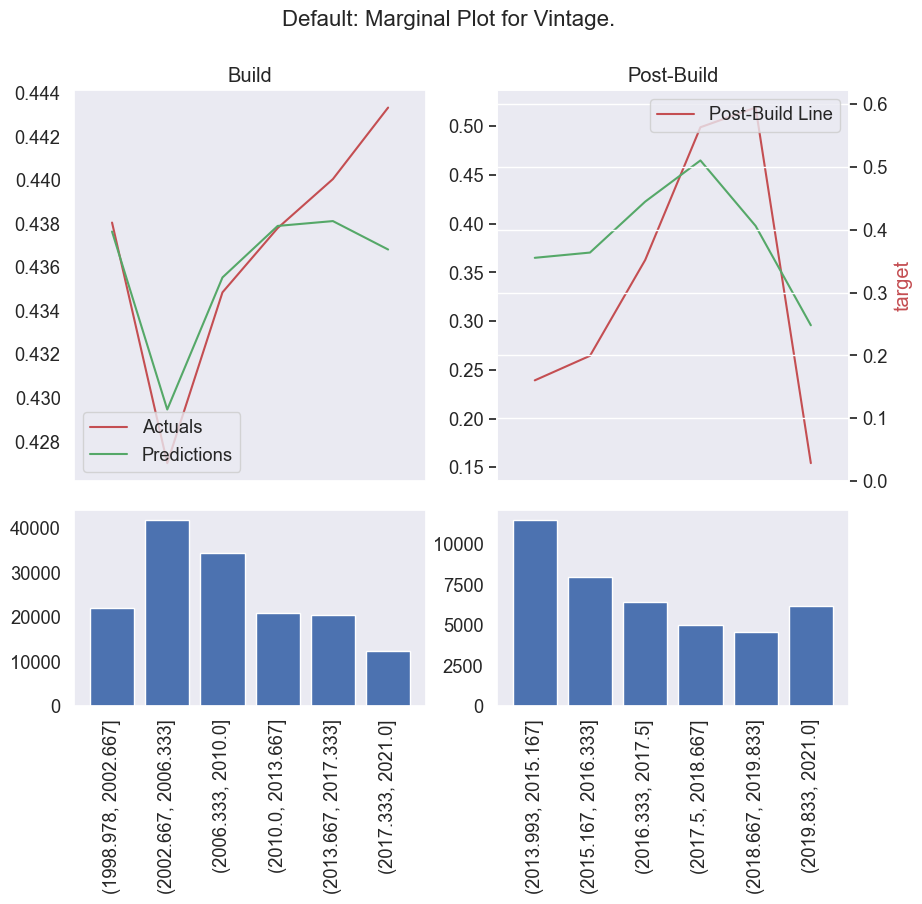

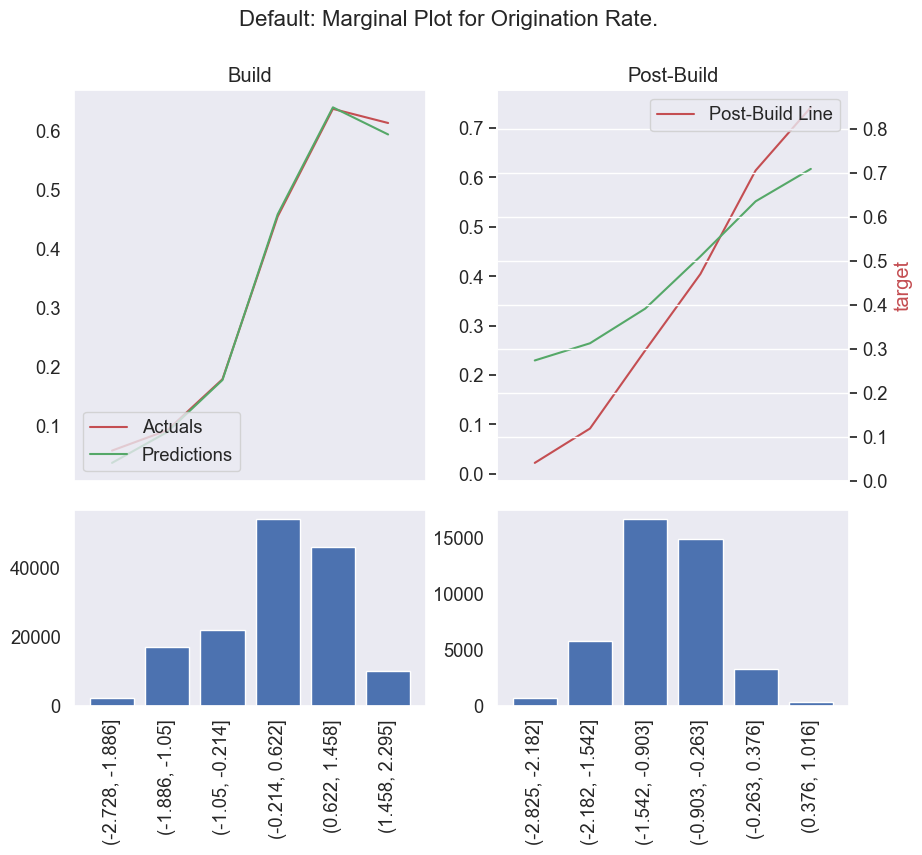

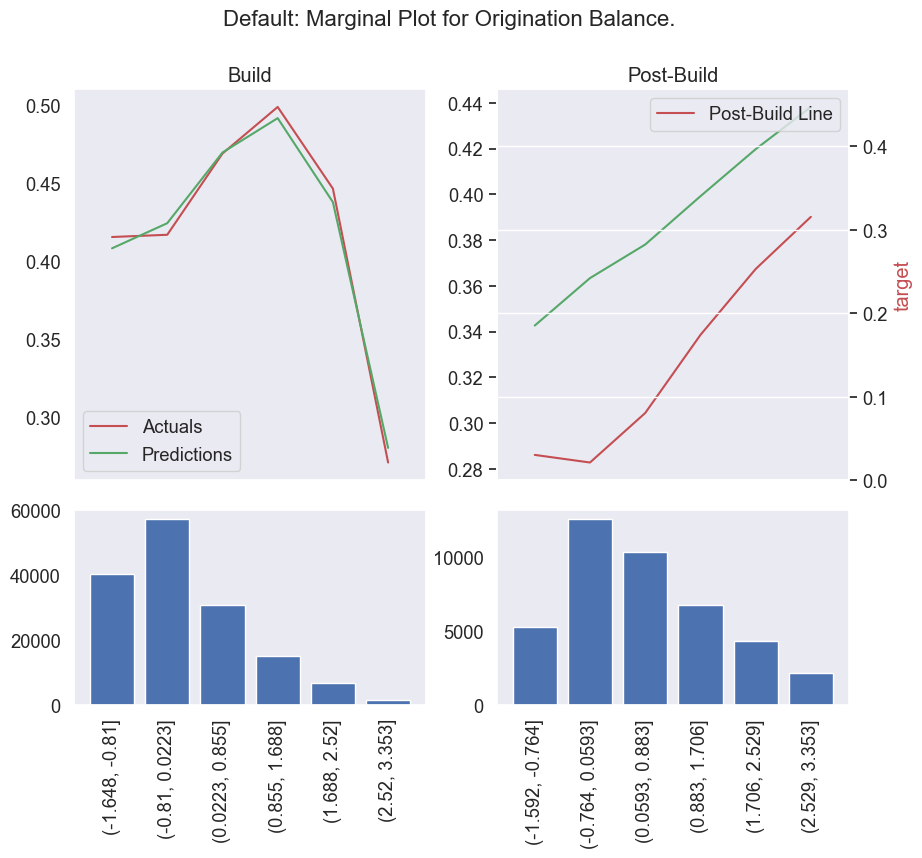

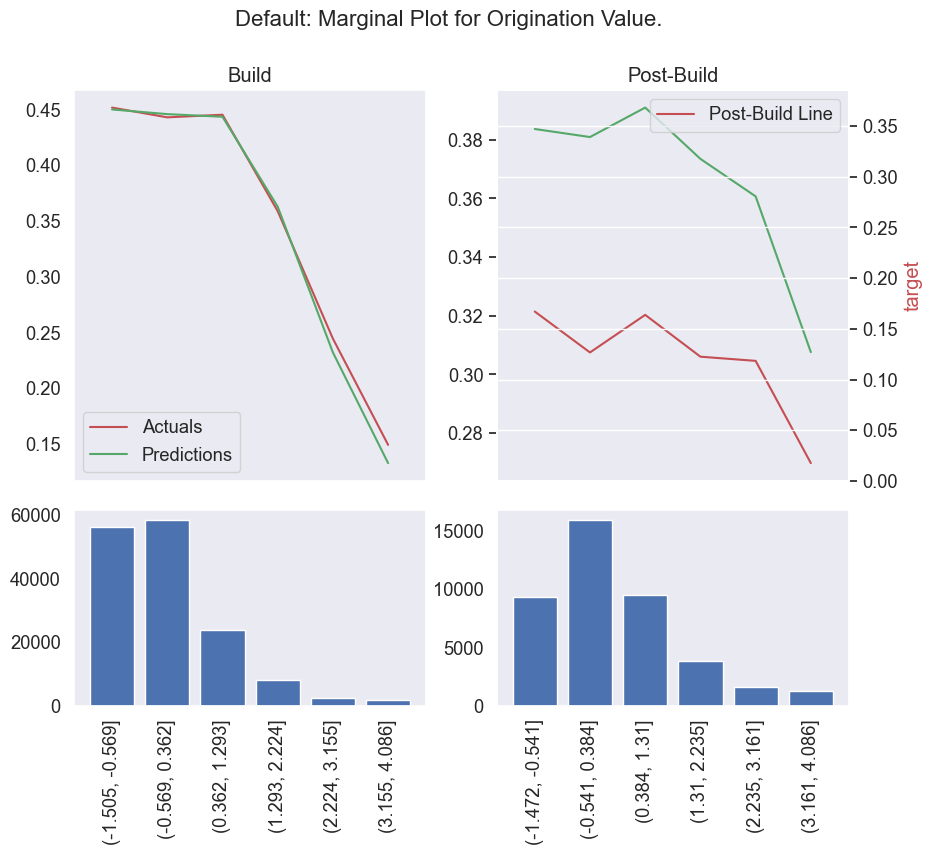

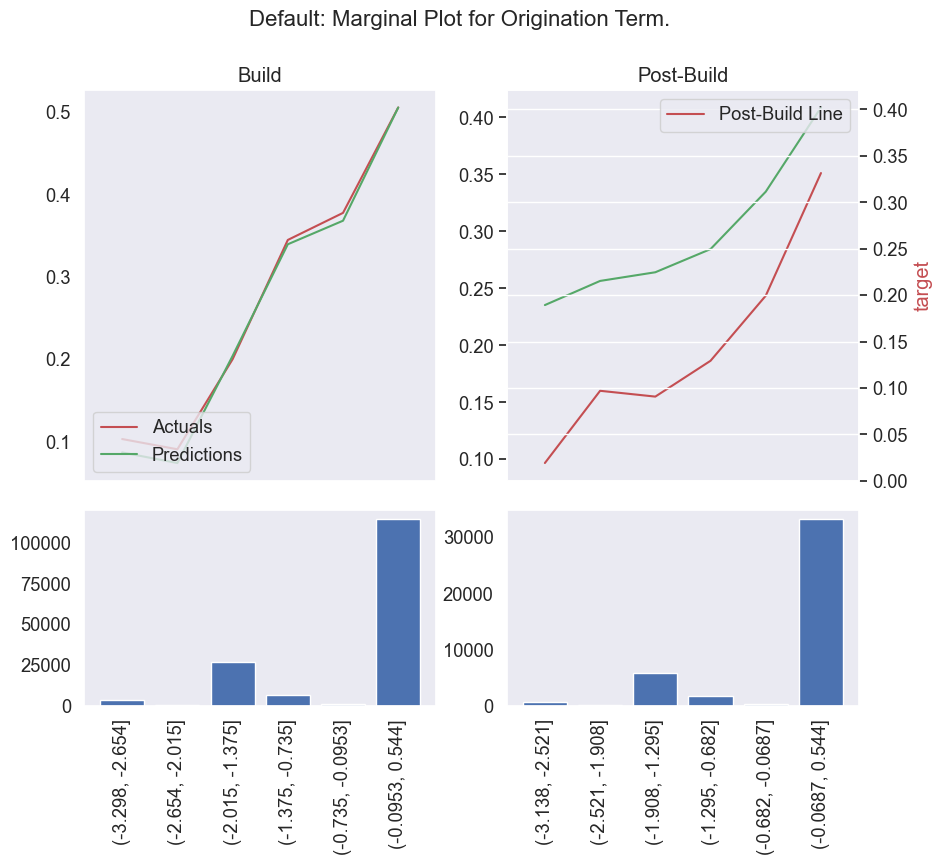

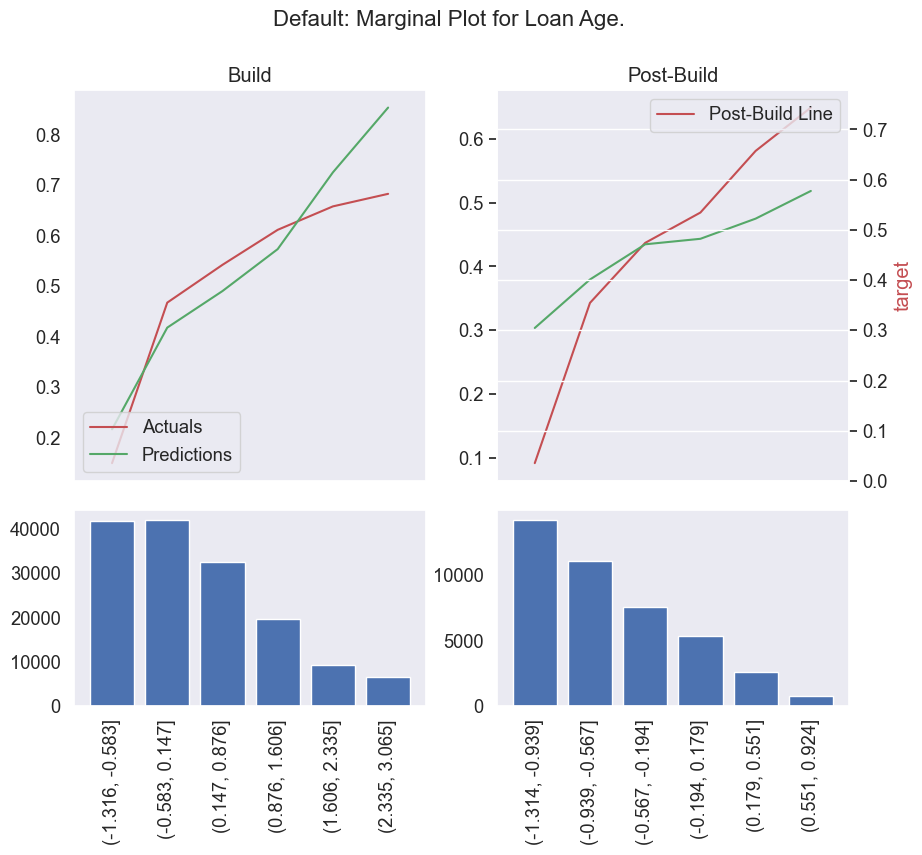

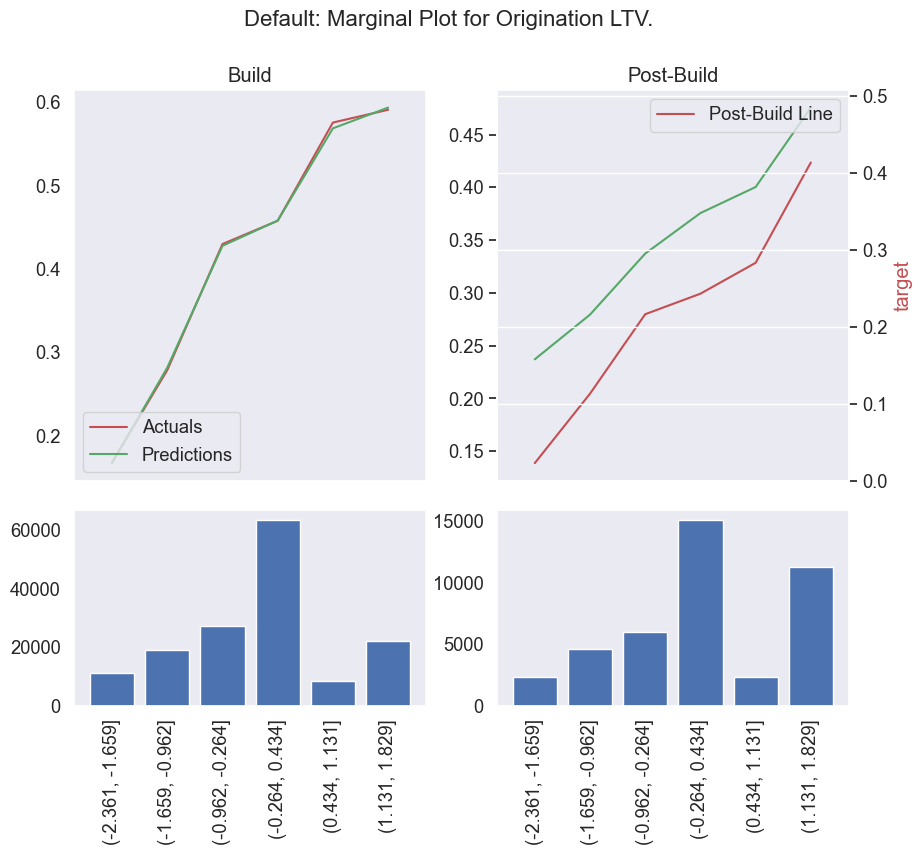

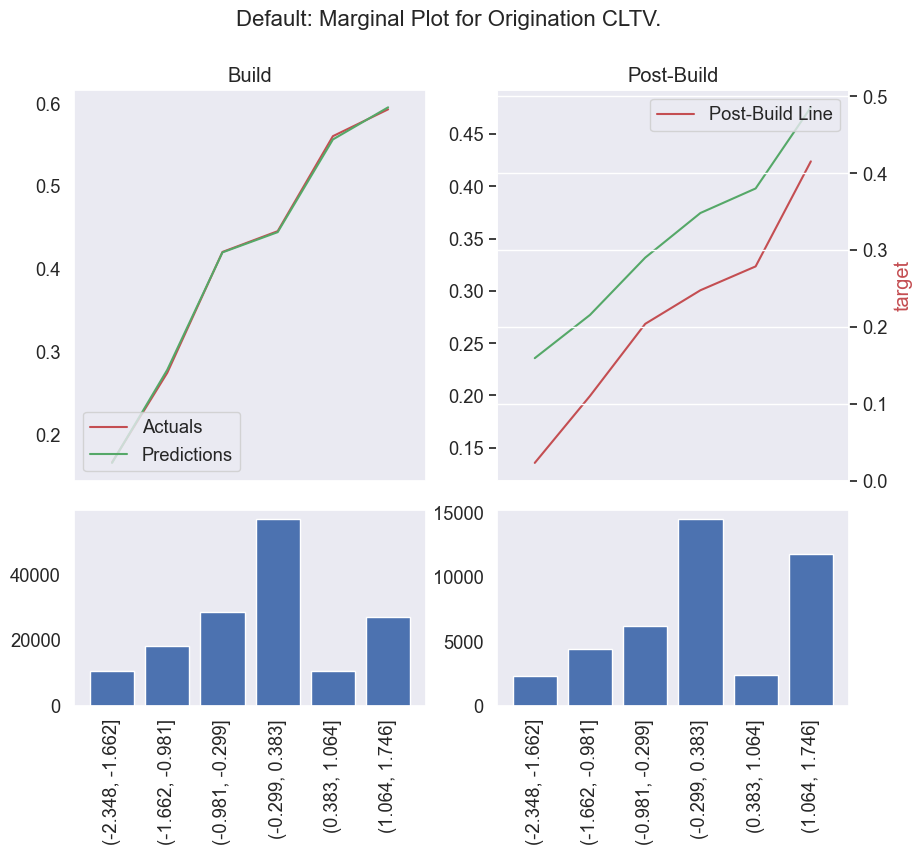

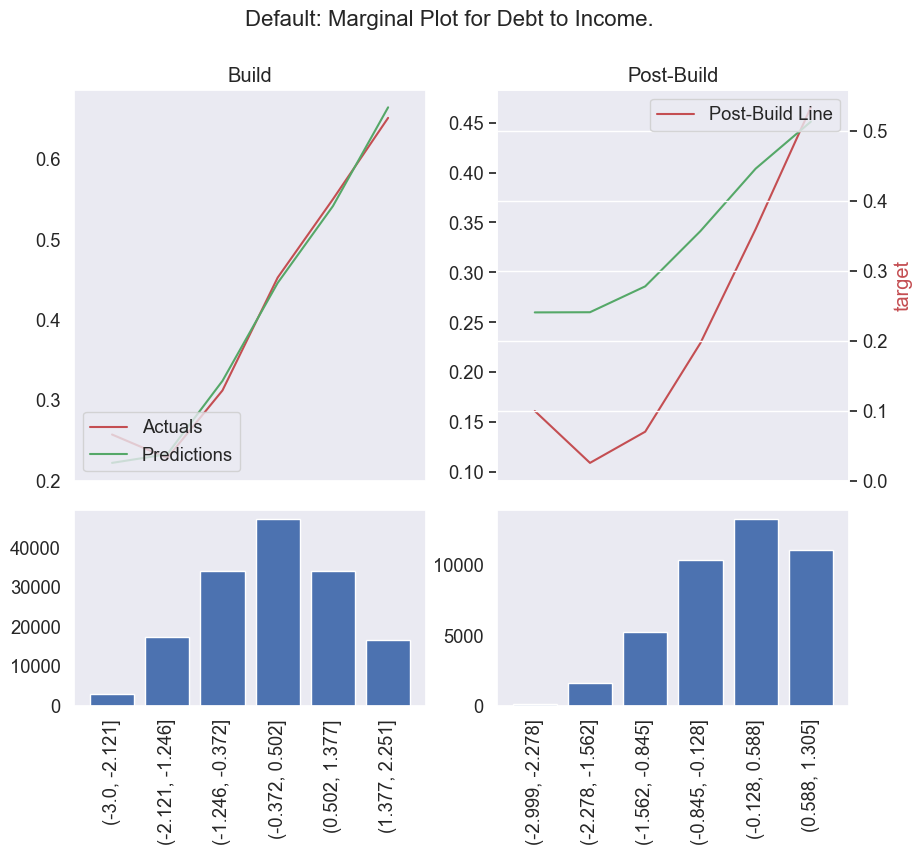

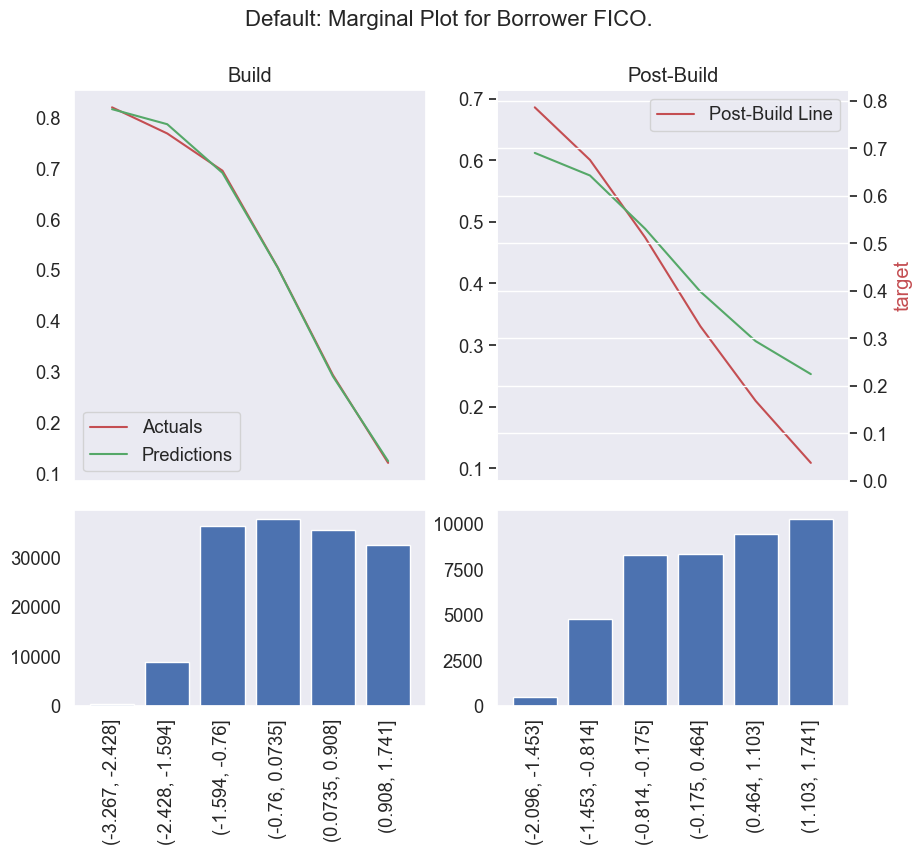

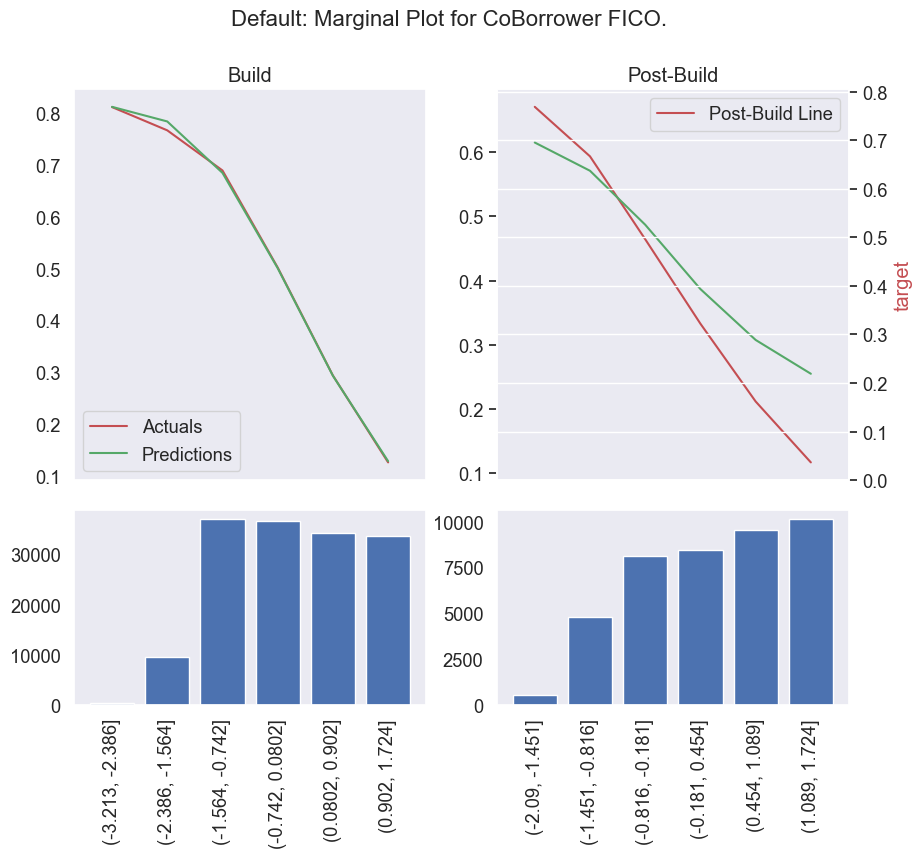

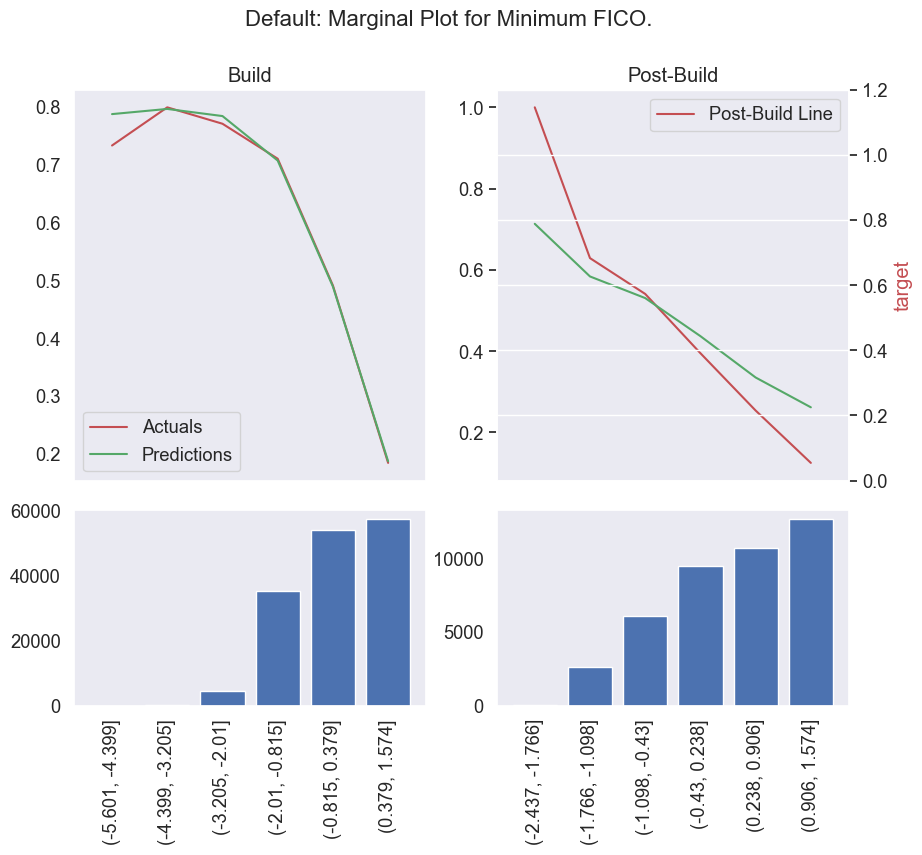

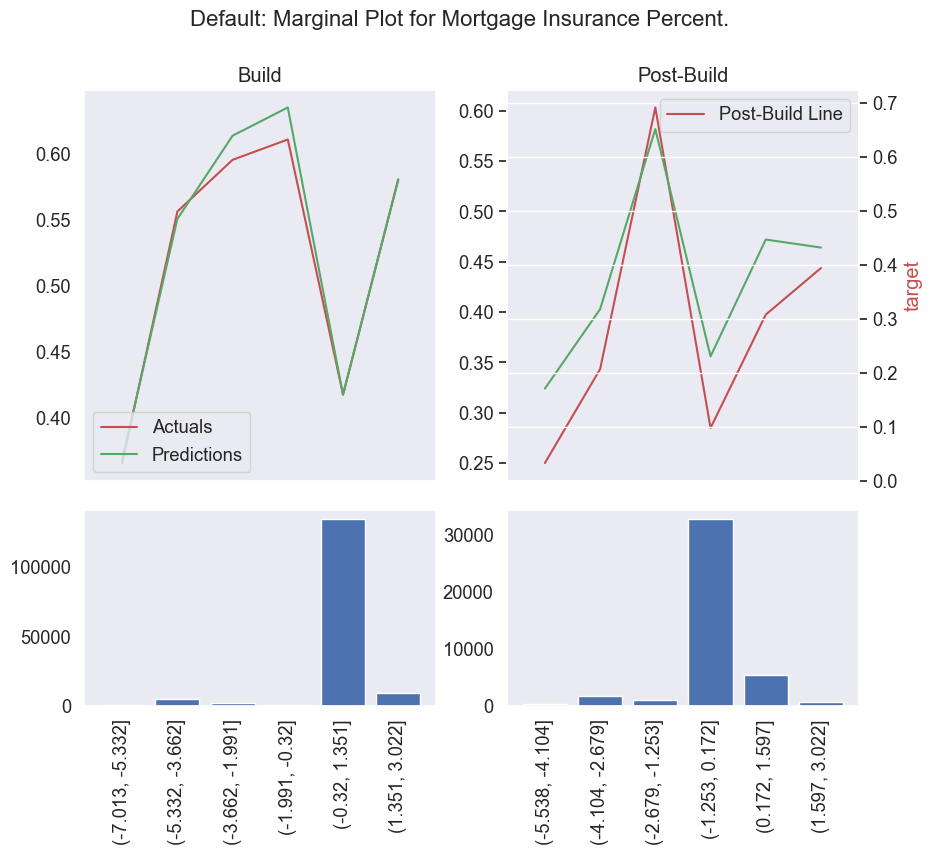

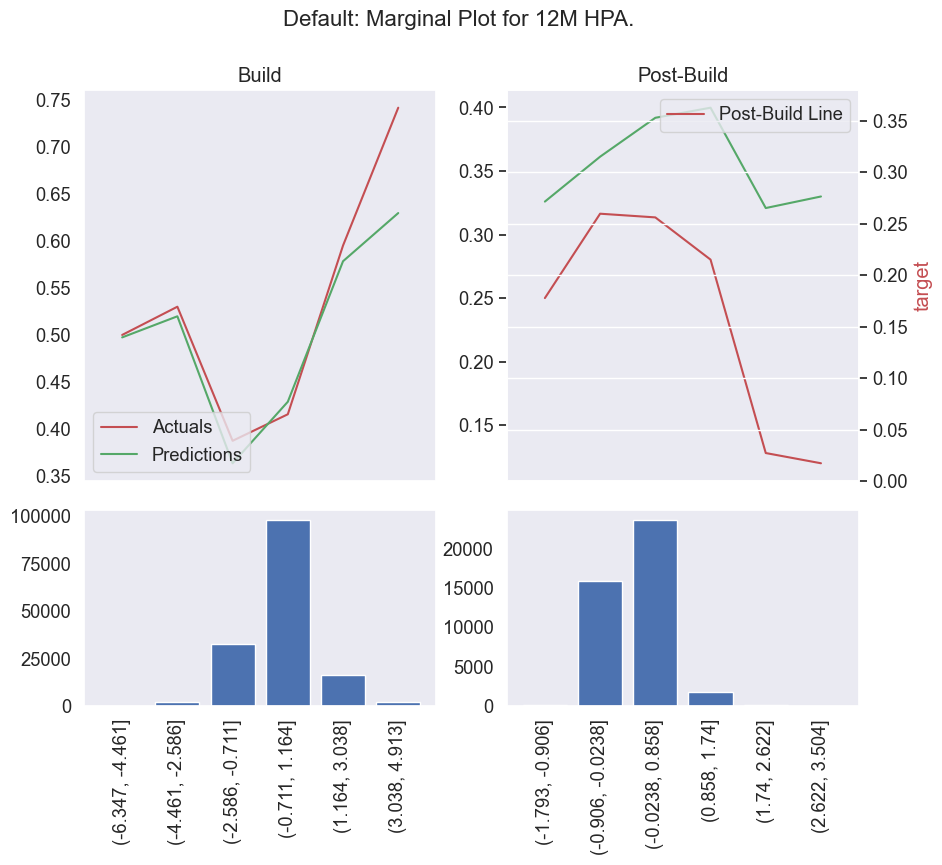

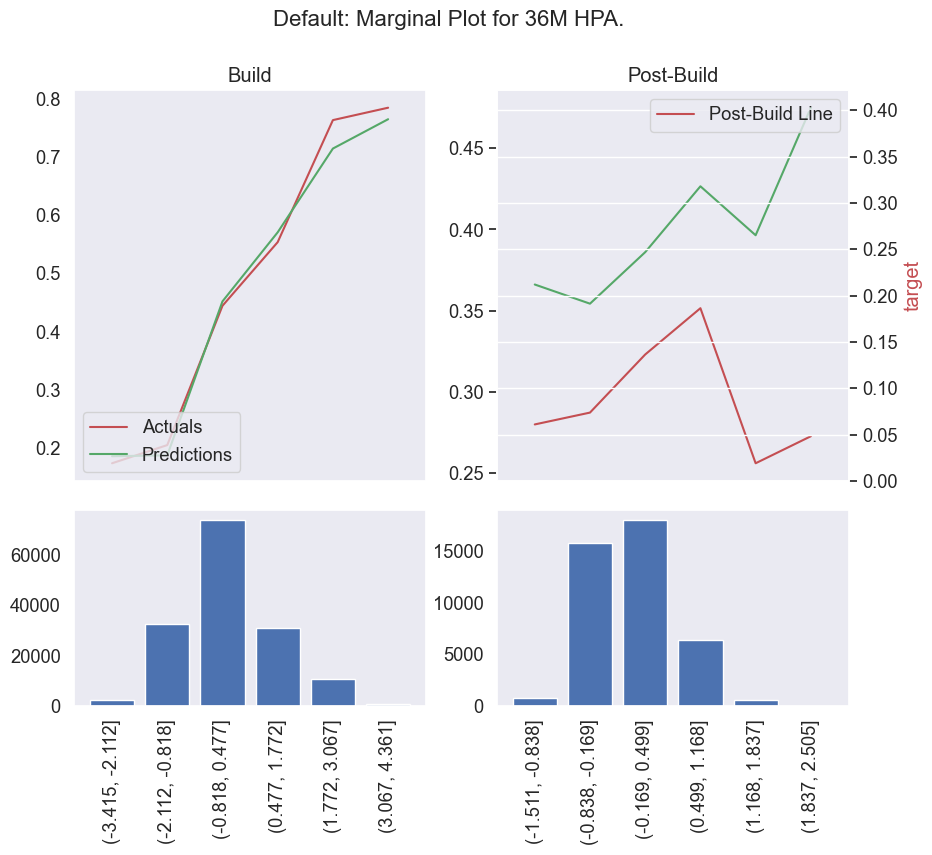

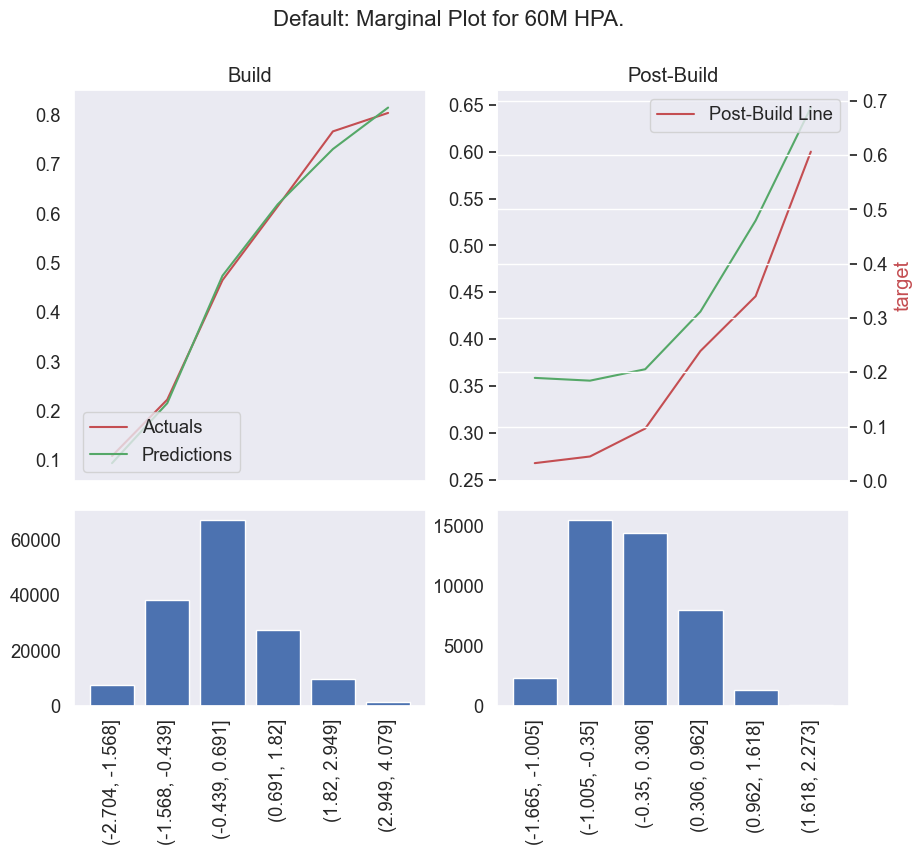

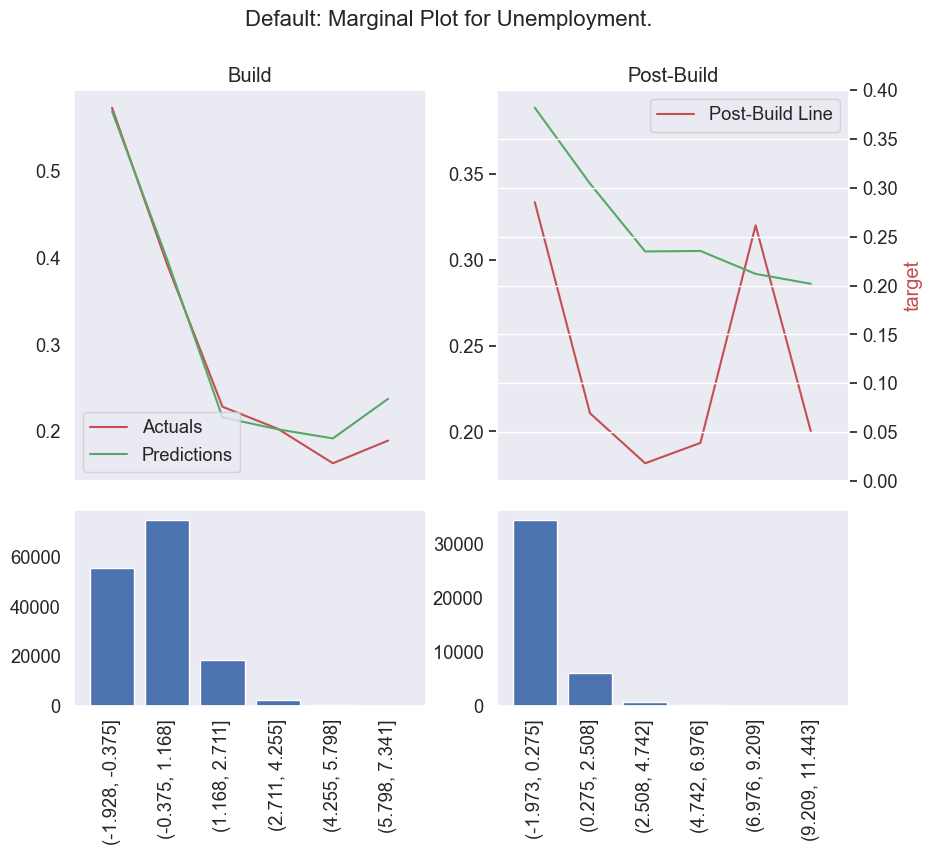

In [256]:

for i,j in zip(x_var_list, x_var_name):

    marginal_plots(df_ins_4plot,df_oot_4plot,i,j,y_var,y_pred,bin_size)

# Cubic Spline

 - Let's try cubic spline and check how change the result
 - From the numerical features all of them require splining even after scaling

In [594]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

x = df_model_log[num_vars].values #returns a numpy array

scaler = StandardScaler()

centered_data = scaler.fit_transform(x)

In [595]:
x.shape

(193374, 17)

In [596]:
from sklearn import preprocessing
from sklearn.preprocessing import SplineTransformer
spline = SplineTransformer(degree=1, n_knots=2)
#x1_trans=spline.fit_transform(x)
x1_trans=spline.fit_transform(centered_data)
spline_cols=spline.get_feature_names_out(input_features=num_vars)

df_model_log_num_spline=pd.DataFrame(x1_trans, index = df_model_log.index,columns=spline_cols)

In [597]:
x1_trans.shape

(193374, 34)

In [598]:
### since I have only centered numeric features I need to reconstitute the model dataset

l_cat=list(df_model_log.columns)
#l_cat.remove(num_vars)
l_cat = [i for i in l_cat if i not in num_vars]
l_cat.remove('Default')

**Concatenation**

In [599]:
#df_model_log_spline.isnull().sum()

In [600]:
df_model_log_spline = pd.concat([df_model_log_num_spline, df_model_log[l_cat],df_model_log['Default']], axis=1)

In [601]:
### the variables below created issues with logistic regression. Therefore I dropped them
### TO DO: create a variable for num_bo so I can combine any number of borrowers greater than 1 into one category

l=list(df_model_log_spline.columns)
l.remove('Default')

In [602]:
df_oot_log_spline=df_model_log_spline.loc[oot_index_names]
X_oot_log_spline=df_oot_log_spline[l]
Y_oot_log_spline=df_oot_log_spline["Default"]

In [603]:
#X_oot_log_spline.isnull().sum()

In [604]:
df_ins_log_spline=df_model_log_spline.drop(oot_index_names)
X_ins_log_spline=df_ins_log_spline[l]
Y_ins_log_spline=df_ins_log_spline["Default"]

In [605]:
X_ins_log_spline= sm.add_constant(X_ins_log_spline)
final_features_log_spline=list(X_ins_log_spline.columns)
# Instantiate a binomial family model with the default link function.
#log_model = sm.GLM(Y_ins_log, X_ins_log, family=sm.families.Binomial(),offset=offset)
log_model_spline = sm.GLM(Y_ins_log_spline, X_ins_log_spline, family=sm.families.Binomial())

In [608]:
log_results_spline = log_model_spline.fit()

print(log_results_spline.summary()) #I increase the frac that is why machine couldnt calculate it. I keep 0.05 frac plot

In [609]:
ypred_log_spline = pd.DataFrame(log_results_spline.predict(X_ins_log_spline.values),columns=['pred'])

df1=pd.DataFrame(X_ins_log_spline.values,columns=final_features_log_spline)
df2=pd.DataFrame(Y_ins_log.values,columns =['target'])
df3 =df_models.drop(oot_index_names)
df_ins_4plot=pd.concat([df1,df2,df3[['Vintage']+num_vars],ypred_log],axis=1)

In [281]:
X_oot_log_spline= sm.add_constant(X_oot_log_spline)
ypred_log_oot_spline = pd.DataFrame(log_results_spline.predict(X_oot_log_spline.values),columns=['pred'])

df1_oot=pd.DataFrame(X_oot_log_spline.values,columns=final_features_log_spline)
df2_oot=pd.DataFrame(Y_oot_log_spline.values,columns =['target'])
df3_oot=df_models.loc[oot_index_names]

# to avoid mismatch index issue
df1_oot.reset_index(drop=True, inplace=True)
df2_oot.reset_index(drop=True, inplace=True)
df3_oot.reset_index(drop=True, inplace=True)
ypred_log_oot.reset_index(drop=True, inplace=True)
df_oot_4plot=pd.concat([df1_oot,df2_oot,df3_oot[['Vintage']+num_vars],ypred_log_oot],axis=1)

In [287]:
x_var_list=['Vintage',
            'orig_rate',
 'orig_upb',
 'orig_val',
 'orig_term',
 'loan_age',
 'oltv',
 'ocltv',
 'dti',
 'cscore_b',
 'cscore_c',
 'cscore_min',
 'mi_pct',
 '12M Change',
 '36M Change',
 '60M Change',
 'unemp']
x_var_name=['Vintage',
            'Origination Rate',
            'Origination Balance',
            'Origination Value',
            'Origination Term',
            'Loan Age',
            'Origination LTV',
            'Origination CLTV',
            'Debt to Income',
            'Borrower FICO',
            'CoBorrower FICO',
            'Minimum FICO',
            'Mortgage Insurance Percent',
            '12M HPA',
            '36M HPA',
            '60M HPA',
            'Unemployment']

In [288]:
def marginal_plots(df_ins_4plot,df_oot_4plot,x_var,x_var_plot,y_var,y_pred,bin_size=6):
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('Default: Marginal Plot for {}.'.format(x_var_plot), fontsize=16)
    gs = gridspec.GridSpec(2, 2, hspace=.1,height_ratios=[2, 1])


    # the first subplot for model performance along the feature of interest in-sample
    ax0 = plt.subplot(gs[0])

    s=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_var]
    line0, = ax0.plot(s.index.astype(str), s.values, color='r',label='line1')
    sp=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).mean() [y_pred]
    line1, = ax0.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Build")

    # the second subplot for counts for that feature in-sample
    # shared axis X
    ax1 = plt.subplot(gs[2], sharex = ax0)
    ax0.grid()
    ax1.grid()



    t=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax0.get_xticklabels(), visible=False)
    line2= ax1.bar(t.index.astype(str), t.values, color='b')
    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    # put legend on first subplot
    ax0.legend((line0, line1), ('Actuals', 'Predictions'), loc='lower left')


    # the third subplot for model performance along the feature of interest in holdout
    
#post-build 
    ax2 = plt.subplot(gs[1])
    # log scale for axis Y of the first subplot
    s=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_var]
    line4, = ax2.plot(s.index.astype(str), s.values, color='r',label='line1')
    sp=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_pred]+0.20
    line5, = ax2.plot(sp.index.astype(str), sp.values, color='g',label='line2')
    plt.title("Post-Build")

    # # the fourth subplot for counts for that feature in holdout
    # shared axis X
    ax3 = plt.subplot(gs[3], sharex = ax2)
    ax2.grid()
    ax3.grid()



    t=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).count() [x_var]
    plt.setp(ax2.get_xticklabels(), visible=False)
    line6= ax3.bar(t.index.astype(str), t.values, color='b')


    plt.xticks(rotation = 90)
    # remove last tick label for the second subplot
    yticks = ax3.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    plt.show()

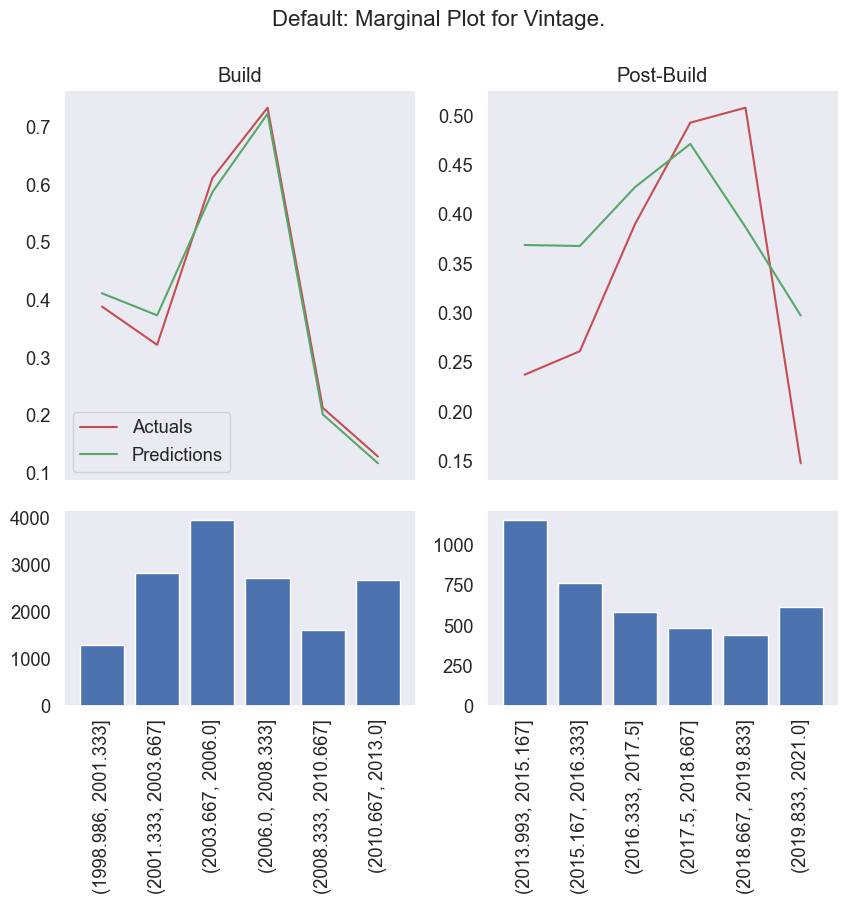

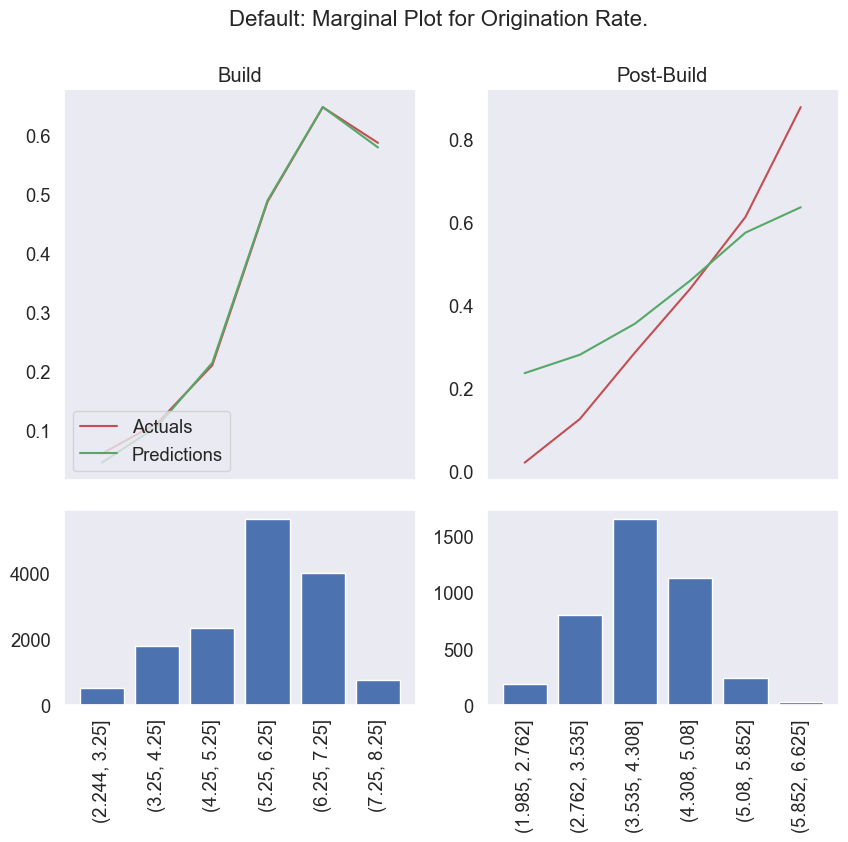

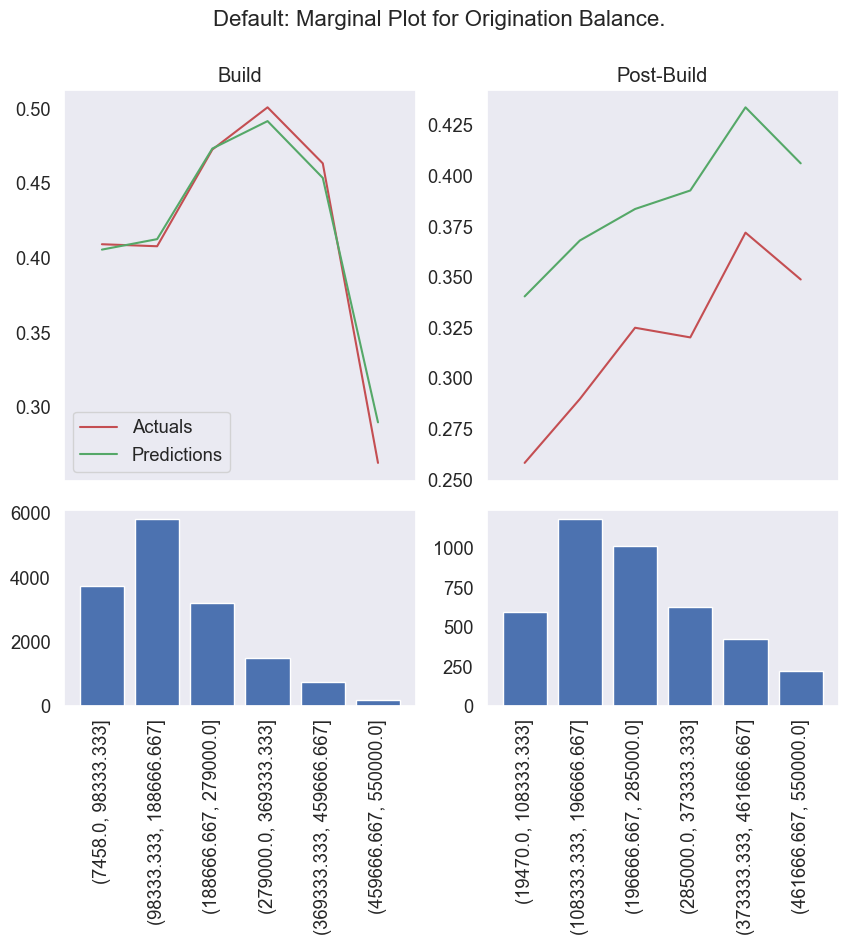

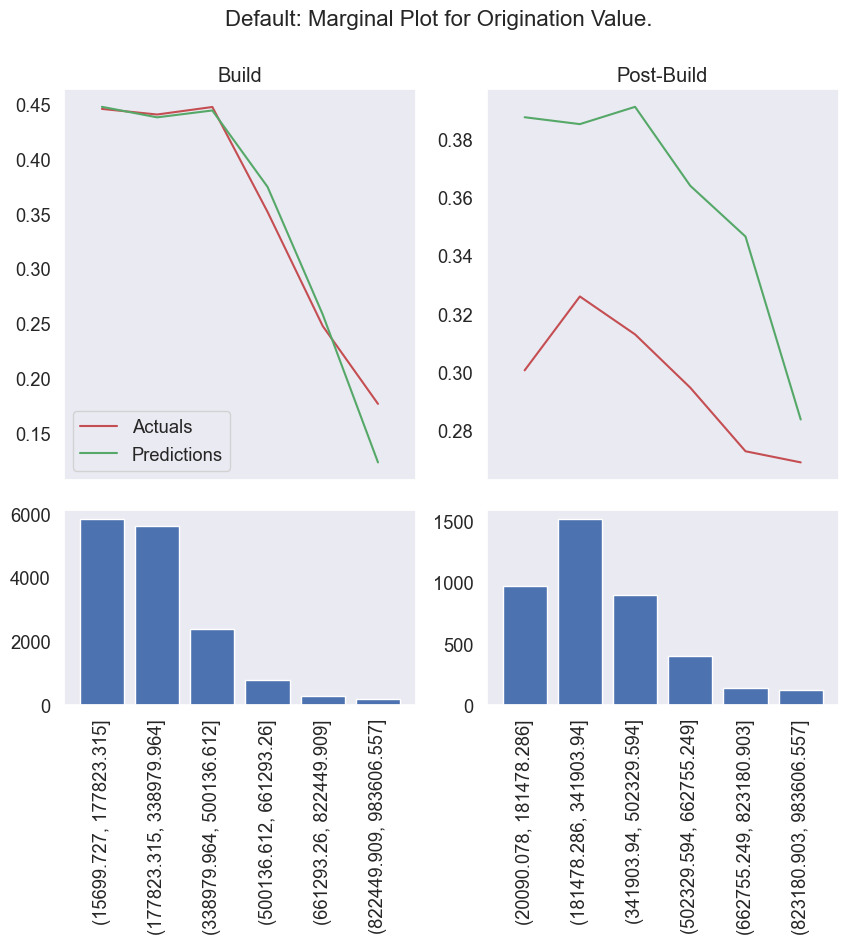

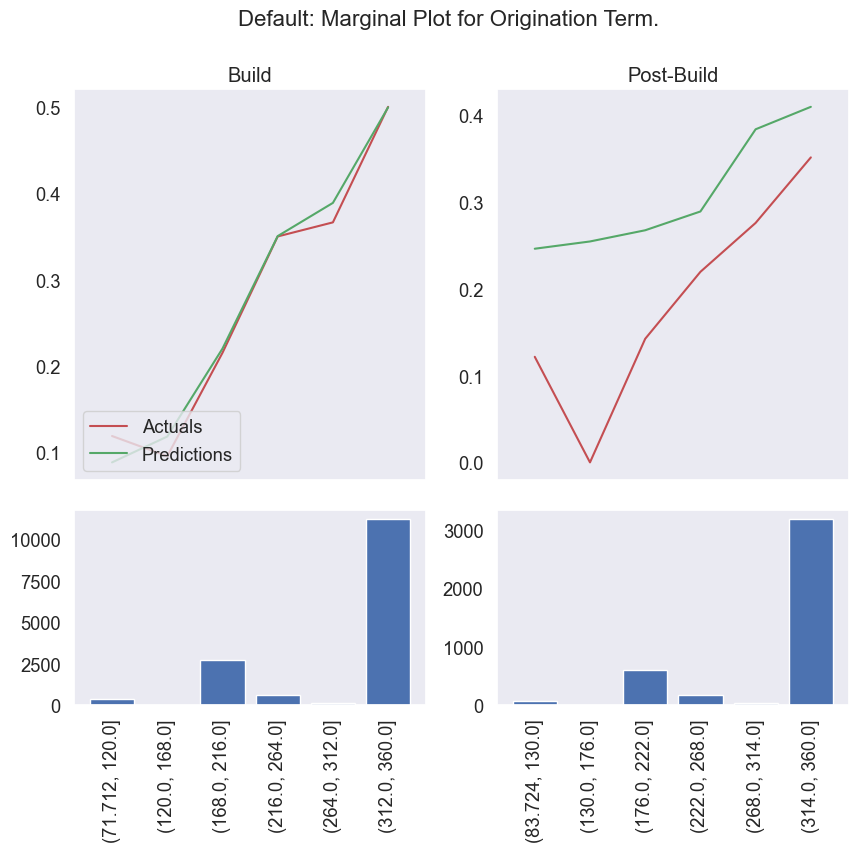

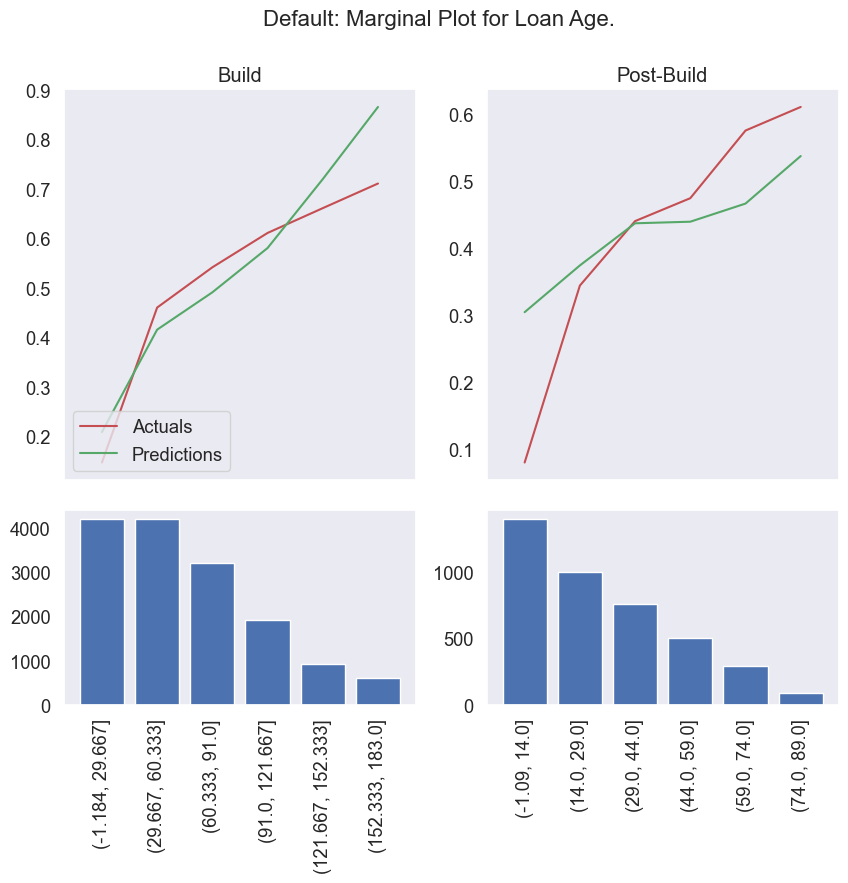

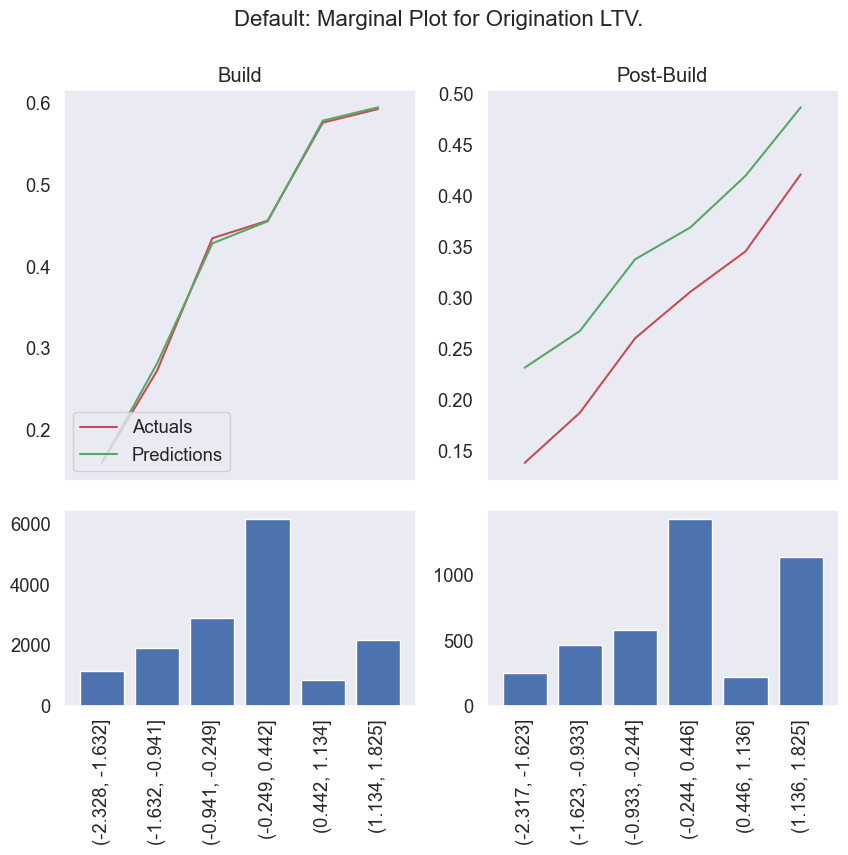

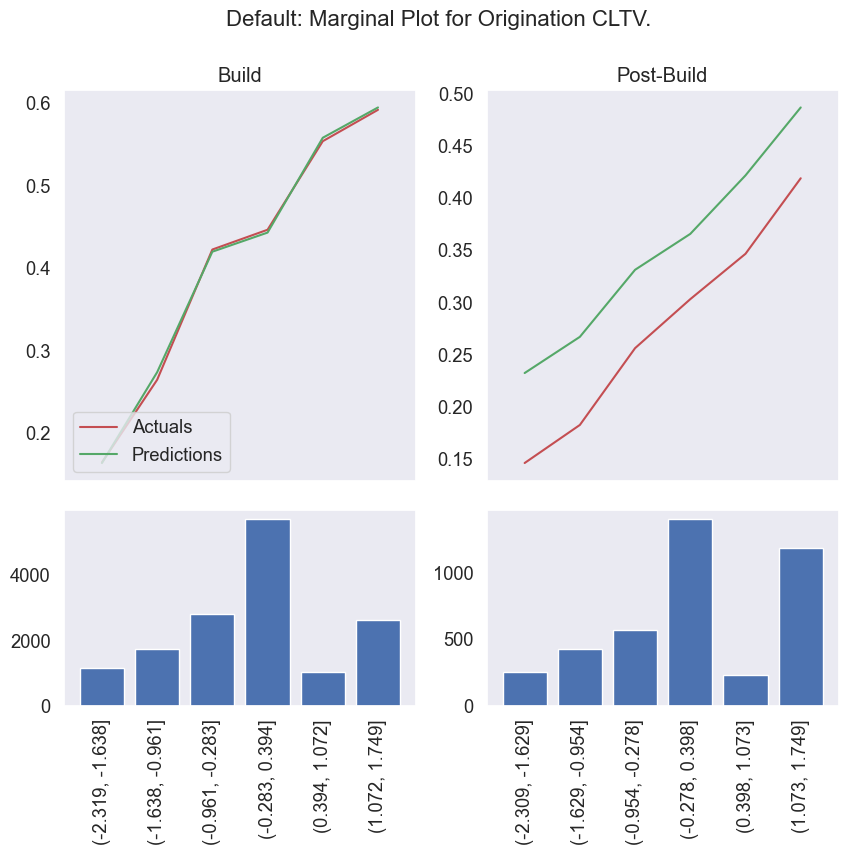

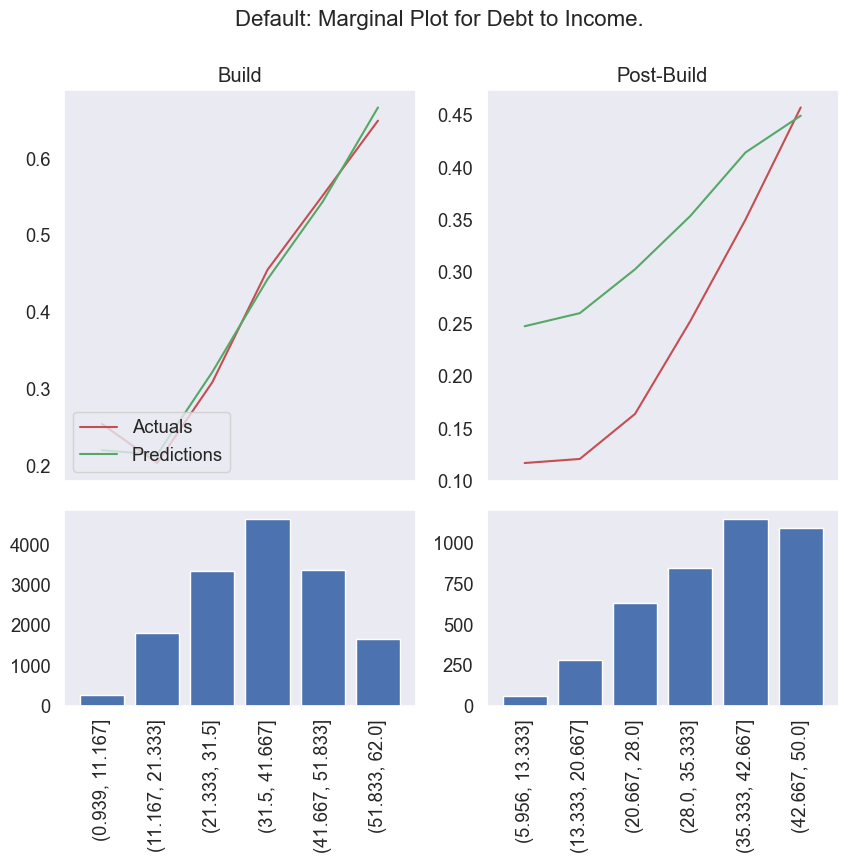

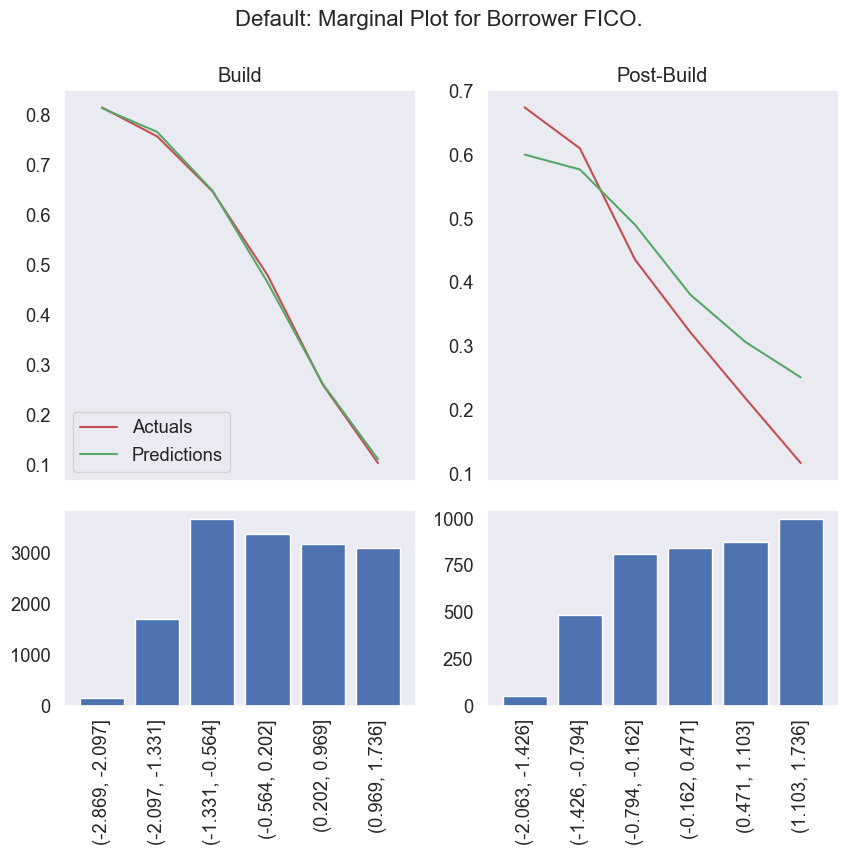

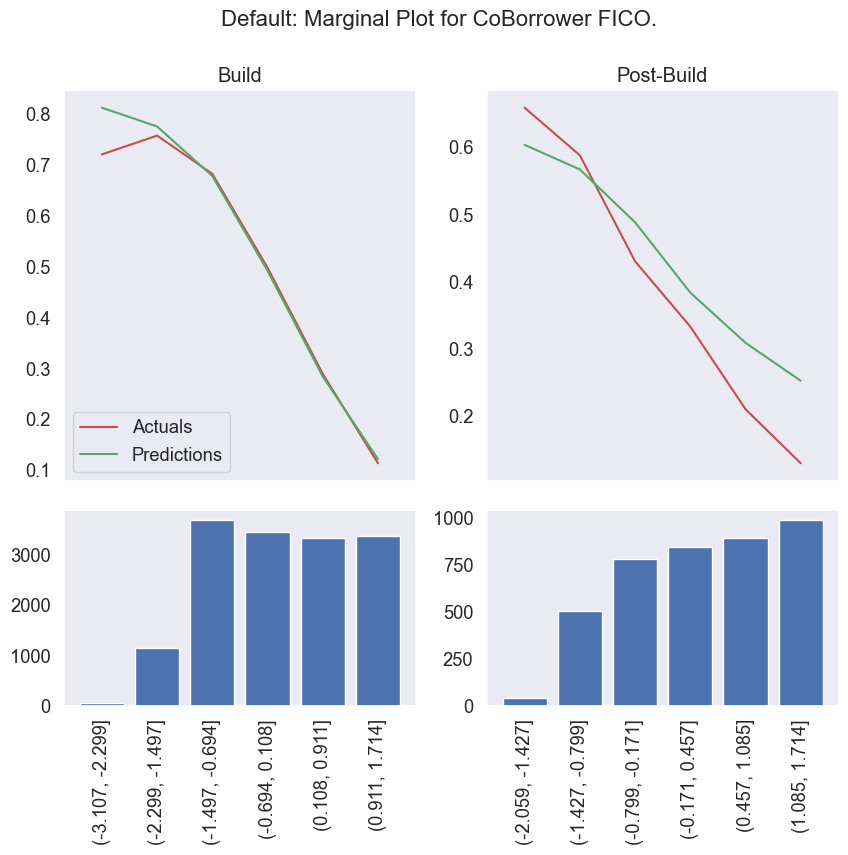

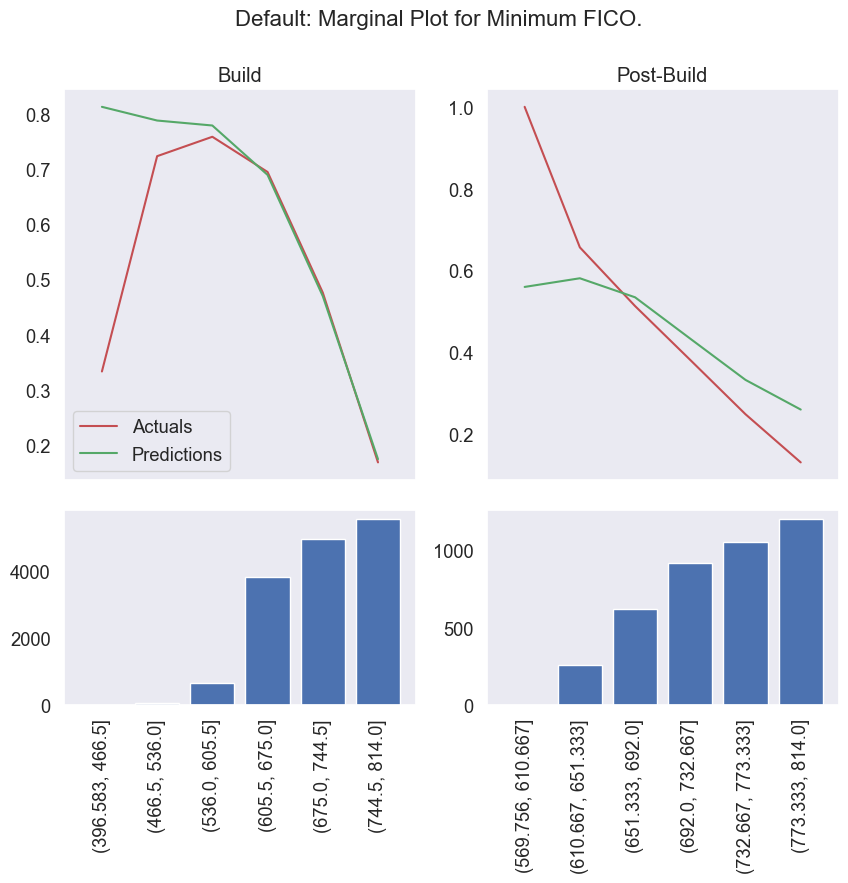

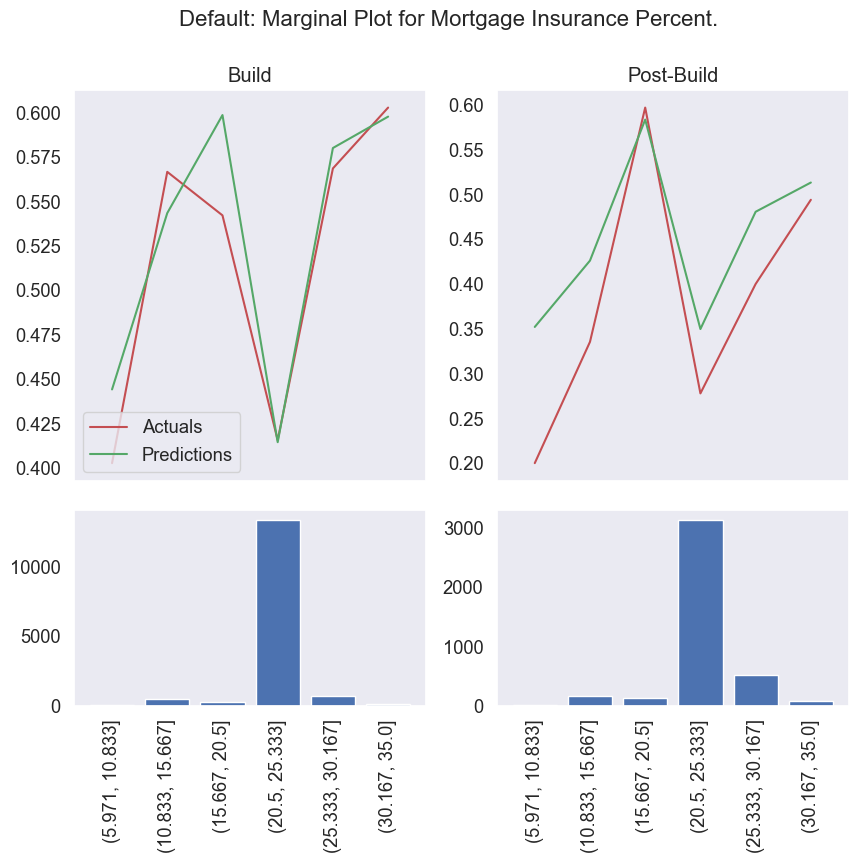

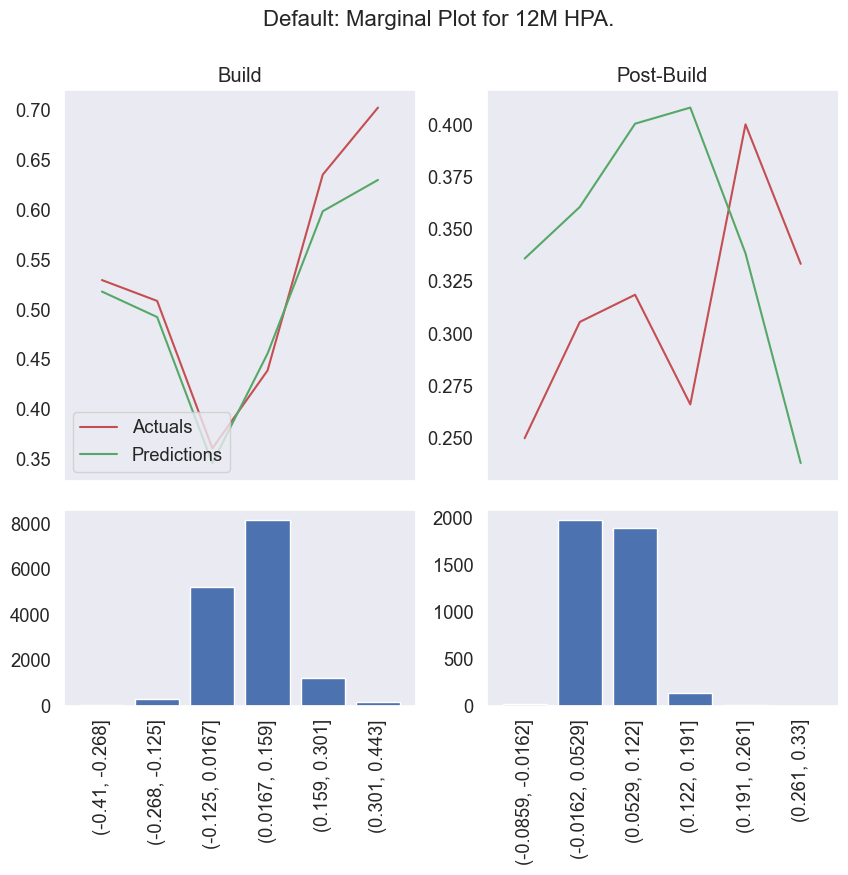

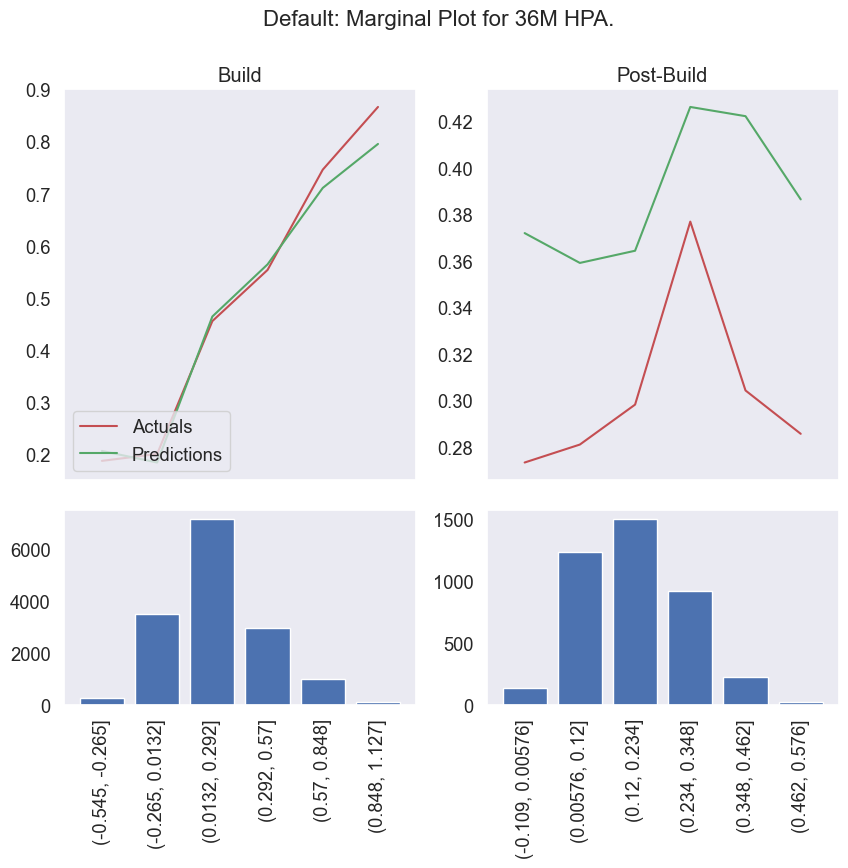

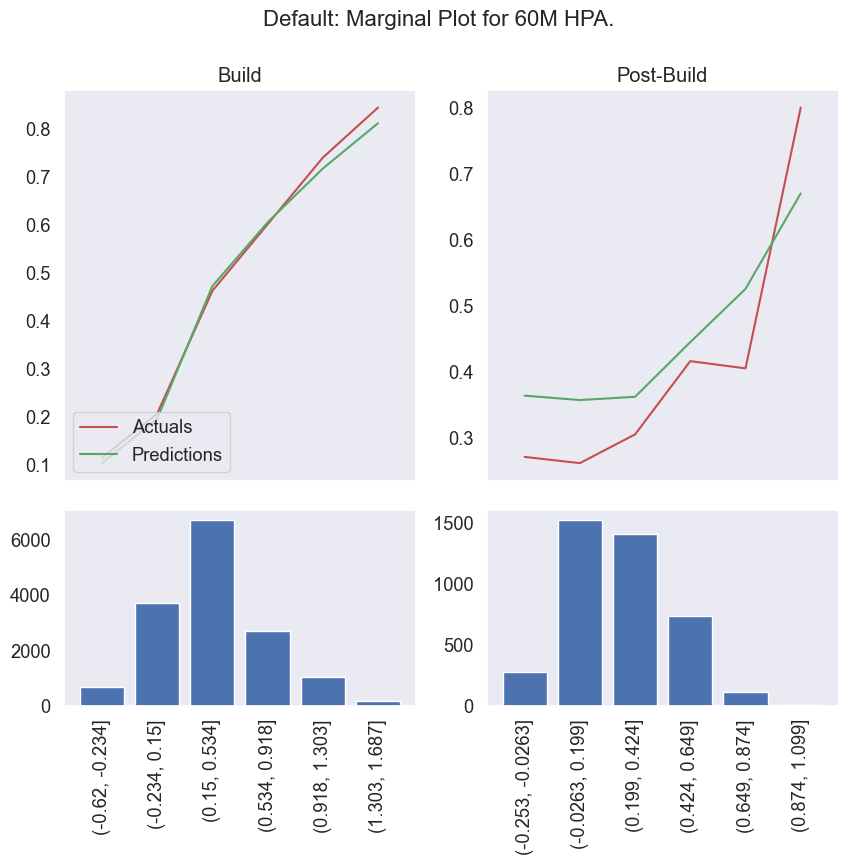

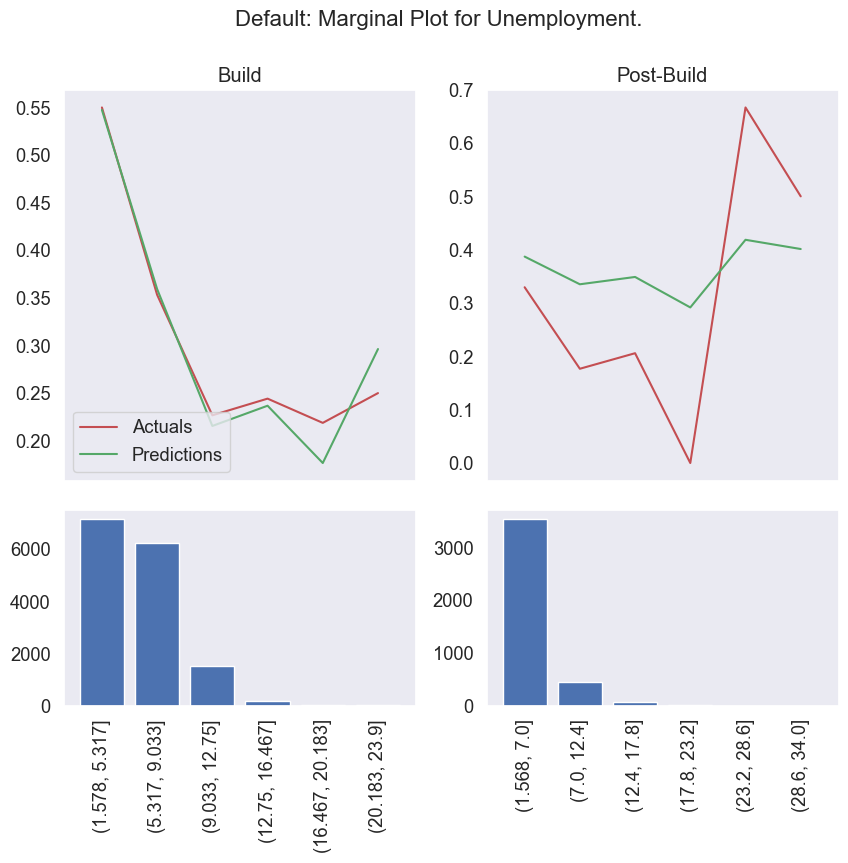

In [289]:
for i,j in zip(x_var_list, x_var_name):

    marginal_plots(df_ins_4plot,df_oot_4plot,i,j,y_var,y_pred,bin_size)

In [290]:
ypred = log_results.predict(X_oot_log)

In [291]:
ypred

15079    0.071617
15080    0.095399
15081    0.314805
15082    0.386934
15083    0.056636
           ...   
19129    0.024571
19130    0.071313
19131    0.008883
19132    0.024241
19133    0.034772
Length: 4055, dtype: float64

In [292]:
ypred_log = log_results.predict(X_oot_log.values)
roc_auc_score(Y_oot, ypred_log)

0.8349278951499819

# Conclusion  

If we interpret the line plots and bar plots one by one we can understand insight of graphs. Let's start: 

**Vintage** at vintage graph, there is a difference between the train and test datasets because Test set sees the data first time. Also training set includes a recession years but test set does not have. This is because the y-axis default rate starts at 0.445 in the training set and in the test set this range is between 0.22 - 0.36. This plots are as expected. According to this graph we can delve deeper into the model's behavior with respect to different X variables.
  

**Origination rate**, an increase in it, leads to an increase in the default rate. It means it' s good for separation. If there is a gap between prediction and actual rate lines,it might be due to the small number of observations. The observation count can be viewed from the bar plot. In some instances, the line aligns with our rate, which is also a good sign.  

**Origination Balance**  
It appears fine from a trend perspective. However, there is a gap. Typically, FNMA has a loan limit, and beyond a certain threshold, it takes on a different underwriting stance. We can identify this by adding an indicator for loans with a higher limit, and we will penalize them consistently. A quick Google search for Fannie loan limits reveals the yearly variations.


**Loan age** appears satisfactory. 

_Concerning risky loans, higher DTI, LTV, CLTV values indicate risk for our model. Underpredict implieshigh risk, while overprediction implies less risk. In my graphs all of them are over predicted._  

**Borrower FICO** is expected.where an increase in FICO corresponds to an increase in default risk.   

**Mortgage in Percentage** also follows a similar trend and it looks nice.  

**12M HPA**  despite our efforts to control the economic environment and enhance our dataset, it's not sufficient for predicting default rates. ,  on the other hand it looks it is not enough for our default rate prediction. Negative values in the count bar, indicate falling home prices, and positive values signify rising home prices. We built this model during a severe recession, where increasing home prices imply increased default rates. This explains the downward curve in the training set and the absence of it in the test set.

**36M HPA** a sharp drop suggests limited observations in that region.  

**60M HPA** looks good. 

**Unemployment**: If you have loan when the unemployment is very high, which means you have a really good social income. It means your default risk is very low. That’s why you can see downword trend it is intuitive.As we see from bars we do not have enough data, if we had we could see better trend as expected.

I applied the intercept adjustment and spline method to understand coefficients, standard deviations, and mean insights. While it didn't significantly alter the results, it provided valuable experience.


All these interpretations of line and bar graphs, along with the Logistic Regression and XGBoost models' F1-score and ROC-AUC Scores and an examination of the confusion matrix, provide substantial evidence about the model. **This model appears to be well-suited for rank ordering butnot very good model for prediction**.


The long-term Mortgage Default Project consisting of 5 project that I conducted with this real-life dataset taught me a lot. Playing with it, diving deep, trying to understand, reading the visuals, and learning was truly enjoyable and educatory.  

This Mortgage Default Project contains:  
- Mortgage Default Project -AWS    
- Mortgage Default Project -1  
- Mortgage Default Project -2  
- **Mortgage Default Project -3**  
- Mortgage Default Project Explainabilty. 
